# Data Analysis 3 - Home Assignment 2
## Data preparation script
## Author: Márton Nagy

## Finding fast growing firms 2025

### The assignment

Your task is to build a model to predict fast growth of firms using the bisnode-firms data we used in class.

You should design the target (fast growth), it can be measured in any way you like over one (2013 vs 2012) or two years (2014 vs 2012).
You need to argue for your choice, discussing a few alternatives, maybe 2-3 paragraphs using concepts and ideas from corporate finance.
Build three different models and pick the one you like the most.

Should include at least one logit and one random forest.

### Data management, sample design

- The dataset is very close to what you saw in seminar.
- But you need to start with the panel for 2010-2015.
- Two pieces of code, sample design and prediction:
  - `ch17-firm-exit-data-prep`
  - Starts from `cs_bisnode_panel.csv`
  - Yields `bisnode_firms_clean.csv`
  - `ch17-predicting-firm-exit`.

On the sample, you can make changes, but do not need to.

### Features

- You may use similar variables and features we used for exit prediction.
- You may do differently.
- Look at descriptives, lowess, tabulate factors, make decisions.

### Tasks 1

#### PART I: Probability prediction

- Predict probabilities.
- Look at cross-validated performance and pick your favorite model.

#### PART II: Classification

- Think about the business problem, and define your loss function (like FP=X dollars, FN=Y dollars).
- For each model:
- Predict probabilities.
- Look for the optimal classification threshold.
- Calculate expected loss with your loss function.
- Pick the model that has the smallest average (over 5 folds) expected loss.

#### PART III: Discussion of results

- Show a confusion table (on a selected fold or holdout set).
- Discuss results, evaluate how useful your model may be.

### Tasks 2

- There are two industry categories in the dataset: manufacturing and services (repair, accommodation, food).
- Define a single loss function, but carry out the exercise for two groups separately.
- Pick a prediction model, carry out classification for manufacturing and then repeat for services.
- Compare the model performance across two samples.

### Submit two documents to moodle

- A summary report (pdf), max 5 pages including tables and graphs discussing your work.
  - It is targeted to data science team leaders and senior managers.
  - Can use technical language but explain briefly.
  - But need to be the point!
  - Focus on key decision points, results, interpretation, decision.
- Technical report – a markdown/notebook in pdf/html with more technical discussion.
  - May include code snippets (not verbose, avoid iterations, etc.).
  - May include additional tables and graphs.
  - Detail all decisions you made.
  - Reports should link to code in GitHub.

### Scoring weights

- Task	Weight
- Task 1: Project design, introduction	10%
- Task 1: Data prep, label and feature engineering	15%
- Task 1: Model building and probability prediction and model selection	20%
- Task 1: Classification	15%
- Task 2: Technical execution and write-up	10%
- Discussion of steps, decisions and results	15%
- Explain shortly every modeling decision	
- Final discussion of findings (2-3 paragraphs)	
- Quality of the write-up, prettiness of graphs, etc.	15%

In [4]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
from plotnine import *

warnings.filterwarnings("ignore")
from utils.py_helper_functions import *
from IPython.display import display

Raw data file from OSF (`cs_bisnode_panel.csv`).

In [6]:
#data = pd.read_csv("https://osf.io/download/3qyut/")
data = pd.read_csv('cs_bisnode_panel.csv')

Filtering to have a panel from 2010 until 2015.

In [8]:
data = data[(data['year'] >= 2010) & (data['year'] <= 2015)]

Percentage of missing values per feature.

In [10]:
missing_pct = (data.isna().sum() / data.shape[0]) * 100
missing_pct

comp_id                   0.000000
begin                     0.000000
end                       0.000000
COGS                     94.600432
amort                     2.456356
curr_assets               0.034008
curr_liab                 0.034008
extra_exp                 2.237987
extra_inc                 2.237987
extra_profit_loss         2.240373
finished_prod            94.778827
fixed_assets              0.034008
inc_bef_tax               2.232617
intang_assets             0.034008
inventories               0.034008
liq_assets                0.034008
material_exp              2.456356
net_dom_sales            94.600432
net_exp_sales            94.600432
personnel_exp             2.456356
profit_loss_year          0.039975
sales                     2.232617
share_eq                  0.034008
subscribed_cap            0.034008
tang_assets               0.034008
wages                    94.690524
D                       100.000000
balsheet_flag             0.000000
balsheet_length     

Dropping columns with too many missing values (above 90%).

In [12]:
data = data.drop(columns = list(missing_pct[missing_pct > 90].index))

In [13]:
data = (
    data.set_index(['year', 'comp_id'])
    .unstack(fill_value='toReplace')
    .stack()
    .reset_index()
)
data = data.replace('toReplace', np.nan)

Defining the target variable, `fast_growth` binary indicator. This is set to 1 if the company's sales CAGR is above the yearly sample CAGR mean in a two-year period. Also, this indicator can only be 1 for those firms that were *alive* both at the beginning and at the end of the two-year period.

In [15]:
data['status_alive'] = (data['sales'] > 0 & (False == data['sales'].isna())).astype(int)

In [16]:
data = data.sort_values(by = ['comp_id', 'year'])

In [17]:
data['cagr_2y'] = np.where(
    (data['status_alive'] == 1) & (data.groupby('comp_id')['status_alive'].shift(-2) == 1),
    (data.groupby('comp_id')['sales'].shift(-2) / data['sales']) ** (1/2) - 1,
    np.nan
)

cagr_stats = (
    data.dropna(subset=['cagr_2y'])  # Exclude invalid cases
    .groupby('year')['cagr_2y']
    .agg(['mean', 'std'])
    .rename(columns={'mean': 'cagr_mean', 'std': 'cagr_std'})
)

data = data.merge(cagr_stats, on='year', how='left')

In [18]:
data['b_fast_growth'] = ((data['cagr_2y'] > (data['cagr_mean']))).astype(int)

In [19]:
cagr_stats

cagr_mean  cagr_std
year                     
2010   0.326111  3.457287
2011   0.331114  3.287820
2012   0.403879  4.081266
2013   0.401411  3.706282

In [20]:
data[(data['year'] == 2012) & (data['status_alive'] == 1)].b_fast_growth.describe()

count    22845.000000
mean         0.140687
std          0.347706
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: b_fast_growth, dtype: float64

Rows after 2013 are not needed anymore.

In [22]:
data = data[data['year'] <= 2013]

In [23]:
data.sales.describe()

count    1.083340e+05
mean     4.518607e+05
std      3.776005e+06
min     -2.553889e+05
25%      3.474074e+03
50%      2.604074e+04
75%      9.831481e+04
max      1.110294e+08
Name: sales, dtype: float64

Cleaning the sales variable:

- negative sales are set to 1, to take logs;
- simple log sales is calculated;
- sales in million EUR;
- log sales in million EUR;
- sales YoY log difference (growt rate) for last year and the year before.

In [25]:
data["sales"] = np.where(
    data["sales"] < 0, 1, data["sales"]
)
data = data.assign(
    ln_sales=np.where(
        data["sales"] > 0,
        np.log(data["sales"]),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),  # NaN remain NaN
    sales_mil=data["sales"] / 1000000,
    ln_sales_mil=np.where(
        data["sales"] > 0,
        np.log(data["sales"] / 1000000),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
)

In [26]:
data["d1_ln_sales_mil"] = data["ln_sales_mil"] - data.groupby("comp_id")["ln_sales_mil"].shift(1)

In [27]:
data["d2_ln_sales_mil"] = data.groupby("comp_id")["ln_sales_mil"].shift(1) - data.groupby("comp_id")["ln_sales_mil"].shift(2)

Calculate firm age, add dummy for new firms. Replace sales growth with 0 for new firms.

In [29]:
data["age"] = np.where(
    data["year"] - data["founded_year"] < 0, 0, data["year"] - data["founded_year"]
)
data["b_new"] = np.where(
    ((data["age"] <= 1) | (data["balsheet_notfullyear"] == 1)),
    1,
    (np.where(data["age"].isna(), np.nan, 0)),
)
data["d1_ln_sales_mil"] = np.where(data["b_new"] == 1, 0, np.where(data["b_new"].isna(), np.nan, data["d1_ln_sales_mil"]))
data["d2_ln_sales_mil"] = np.where(data["b_new"] == 1, 0, np.where(data["b_new"].isna(), np.nan, data["d2_ln_sales_mil"]))
data["b_new"] = np.where(data["d1_ln_sales_mil"].isna(), 1, data["b_new"])
data["d1_ln_sales_mil"] = np.where(data["d1_ln_sales_mil"].isna(), 0, data["d1_ln_sales_mil"])
data["d2_ln_sales_mil"] = np.where(data["d2_ln_sales_mil"].isna(), 0, data["d2_ln_sales_mil"])

Clean up 2-digit industry code.

In [31]:
data["ind2_cat"] = data["ind2"].copy()
data["ind2_cat"] = np.where(data["ind2"] > 56, 60, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"] < 26, 20, data["ind2_cat"])
data["ind2_cat"] = np.where(
    (data["ind2"] < 55) & (data["ind2"] > 35), 40, data["ind2_cat"]
)
data["ind2_cat"] = np.where(data["ind2"] == 31, 30, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"].isna(), 99, data["ind2_cat"])

Add foreign and female management dummy (as there is no point in keeping these continous, given theire distributions), factorize categorical variables.

<Axes: >

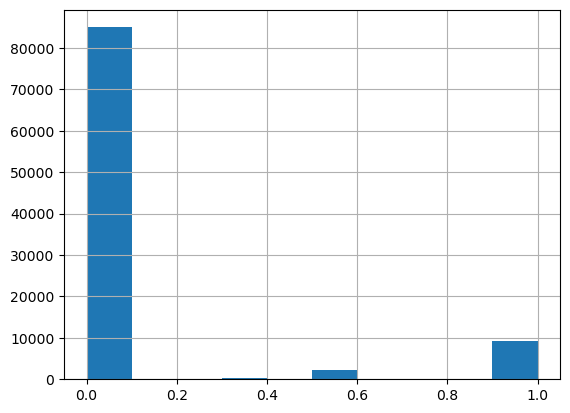

In [33]:
data.foreign.hist()

<Axes: >

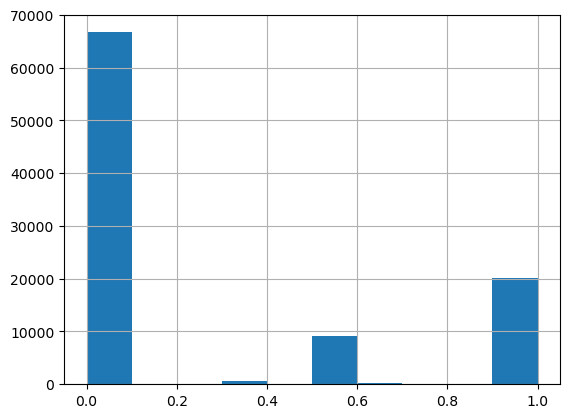

In [34]:
data.female.hist()

<Axes: >

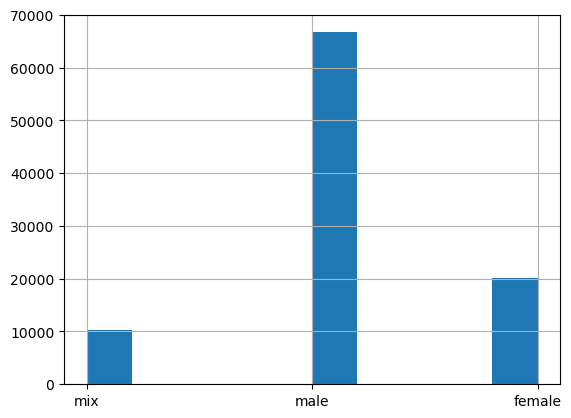

In [35]:
data.gender.hist()

<Axes: >

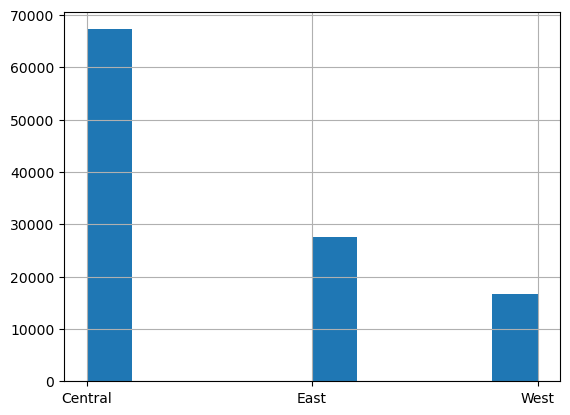

In [36]:
data.region_m.hist()

In [37]:
data["b_foreign_management"] = np.where(data["foreign"] >= 0.5, 1, np.where(data["foreign"].isna(), np.nan, 0))
data["b_female_management"] = np.where(data["female"] >= 0.5, 1, np.where(data["female"].isna(), np.nan, 0))
data["f_gender"] = data["gender"].astype("category")
data["f_region_m"] = data["region_m"].astype("category")

Add flags for negative asset values.

In [39]:
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"] < 0)
        | (data["curr_assets"] < 0)
        | (data["fixed_assets"] < 0)
    ),
    1,
    0,
)
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"].isna())
        | (data["curr_assets"].isna())
        | (data["fixed_assets"].isna())
    ),
    np.nan,
    data["flag_asset_problem"],
)

Set negative asset values to 1 to take logs.

In [41]:
data["intang_assets"] = np.where(data["intang_assets"] < 0, 1, data["intang_assets"])
data["curr_assets"] = np.where(data["curr_assets"] < 0, 1, data["curr_assets"])
data["fixed_assets"] = np.where(data["fixed_assets"] < 0, 1, data["fixed_assets"])

Calculate total assets.

In [43]:
data["total_assets_bs"] = (data["intang_assets"] + data["curr_assets"] + data["fixed_assets"])

Add logs of key asset variables. Define log changes in the past two years.

In [45]:
data = data.assign(
    ln_intang_assets=np.where(
        data["intang_assets"] > 0,
        np.log(data["intang_assets"]),
        (np.where(data["intang_assets"].isna(), np.nan, 0)),
    ),
    ln_curr_assets=np.where(
        data["curr_assets"] > 0,
        np.log(data["curr_assets"]),
        (np.where(data["curr_assets"].isna(), np.nan, 0)),
    ),
    ln_fixed_assets=np.where(
        data["fixed_assets"] > 0,
        np.log(data["fixed_assets"]),
        (np.where(data["fixed_assets"].isna(), np.nan, 0)),
    ),
    ln_total_assets=np.where(
        data["total_assets_bs"] > 0,
        np.log(data["total_assets_bs"]),
        (np.where(data["total_assets_bs"].isna(), np.nan, 0)),
    ),
)

asset_vars = ['ln_intang_assets', 'ln_curr_assets', 'ln_fixed_assets', 'ln_total_assets']

for v in asset_vars:
    data[f'd1_{v}'] = data[v] - data.groupby("comp_id")[v].shift(1)
    data[f'd2_{v}'] = data.groupby("comp_id")[v].shift(1) - data.groupby("comp_id")[v].shift(2)
    data[f'd1_{v}'] = np.where(data["b_new"] == 1, 0, np.where(data["b_new"].isna(), np.nan, data[f'd1_{v}']))
    data[f'd2_{v}'] = np.where(data["b_new"] == 1, 0, np.where(data["b_new"].isna(), np.nan, data[f'd2_{v}']))
    data[f'd1_{v}'] = np.where(data[f'd1_{v}'].isna(), 0, data[f'd1_{v}'])
    data[f'd2_{v}'] = np.where(data[f'd2_{v}'].isna(), 0, data[f'd2_{v}'])

Add changes for key P&L variables (simple changes as log changes is not possible due to negative values).

In [47]:
pl_vars = ["inc_bef_tax", "inventories", "material_exp", "profit_loss_year", "personnel_exp",]
for v in pl_vars:
    data[f'd1_{v}'] = data[v] - data.groupby("comp_id")[v].shift(1)
    data[f'd2_{v}'] = data.groupby("comp_id")[v].shift(1) - data.groupby("comp_id")[v].shift(2)
    data[f'd1_{v}'] = np.where(data["b_new"] == 1, 0, np.where(data["b_new"].isna(), np.nan, data[f'd1_{v}']))
    data[f'd2_{v}'] = np.where(data["b_new"] == 1, 0, np.where(data["b_new"].isna(), np.nan, data[f'd2_{v}']))
    data[f'd1_{v}'] = np.where(data[f'd1_{v}'].isna(), 0, data[f'd1_{v}'])
    data[f'd2_{v}'] = np.where(data[f'd2_{v}'].isna(), 0, data[f'd2_{v}'])

Calculate ratio variables:

- divide P&L columns with sales;
- divide BS columns with total assets.

In [49]:
pl_names = [
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "inc_bef_tax",
    "inventories",
    "material_exp",
    "profit_loss_year",
    "personnel_exp",
]
bs_names = [
    "intang_assets",
    "curr_liab",
    "fixed_assets",
    "liq_assets",
    "curr_assets",
    "share_eq",
    "subscribed_cap",
    "tang_assets",
]

In [50]:
data[[col + "_pl" for col in pl_names]] = data[pl_names].div(
    data["sales"], axis="index"
)

In [51]:
data[[col + "_bs" for col in bs_names]] = (
    data[bs_names]
    .div(data["total_assets_bs"], axis="index")
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)
for col in bs_names:
    data[col + "_bs"] = np.where(
        data["total_assets_bs"].isna(), np.nan, data[col + "_bs"]
    )

For columns with theoretical 0-1 range:

- create flag for above 1 values, and cap these at 1;
- create flag for negative values, and assign 0.

In [53]:
zero = [
    "extra_exp_pl",
    "extra_inc_pl",
    "inventories_pl",
    "material_exp_pl",
    "personnel_exp_pl",
    "curr_liab_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
]

data[[col + "_flag_high" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] > 1).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero])
)
data[[col + "_flag_error" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] < 0).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero])
)

For columns with theoretical -1 - 1 range:

- create flag for lower than -1 values and assign -1;
- create flag for higher than 1 values and assign 1;
- create flag for 0 values;
- add quadratic values.

In [55]:
anyof = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]

data[[col + "_flag_low" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof])
)
data[[col + "_flag_high" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof])
)
data[[col + "_flag_zero" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int)
)

Filter dataset for cross-section:

- in year 2012,
- alive firms only,
- sales is between 1000 EUR and 10 M EUR.

In [57]:
data = data[(data['year'] == 2012) & (data['status_alive'] == 1)]
data = data[(data['sales_mil'] <= 10) & (data['sales_mil'] >= 0.001)]

Remove flags with no variation.

In [59]:
flag_columns = [col for col in data.columns if "flag" in col]
data = data.drop(
    data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1
)

Create CEO age variable, create dummies for low, high and missing values. Floor CEO age at 25 for lower values, cap CEU age at 75 for higher values. Impute missing values with sample mean. Create CEO young dummy for CEO age under 40.

In [61]:
data["ceo_age"] = data["year"] - data["birth_year"]
data = data.assign(
    flag_low_ceo_age=(data["ceo_age"] < 25).astype(int),
    flag_high_ceo_age=(data["ceo_age"] > 75).astype(int),
    flag_miss_ceo_age=(data["ceo_age"].isna()).astype(int),
)


data["ceo_age"] = np.where(data["ceo_age"] < 25, 25, data["ceo_age"])
data["ceo_age"] = np.where(data["ceo_age"] > 75, 75, data["ceo_age"])
data["ceo_age"] = np.where(
    data["ceo_age"].isna(), data["ceo_age"].mean(), data["ceo_age"]
)
data["b_ceo_young"] = (data["ceo_age"] < 40).astype(int)

<Axes: >

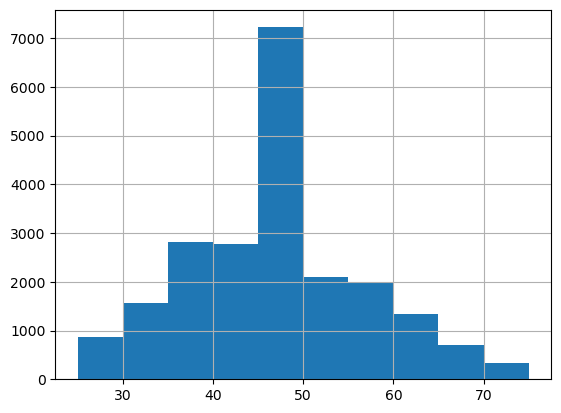

In [62]:
data.ceo_age.hist()

Impute yearly average number of employees with mean and add flag for this.

In [64]:
data["labor_avg_mod"] = np.where(
    data["labor_avg"].isna(), data["labor_avg"].mean(), data["labor_avg"]
)
data["flag_miss_labor_avg"] = (data["labor_avg"].isna()).astype(int)

In [65]:
data = data.drop(["labor_avg"], axis=1)

Add category variables.

In [67]:
data["f_urban_m"] = data["urban_m"].astype("category")
data["f_ind2_cat"] = data["ind2_cat"].astype("category")
data["f_fast_growth"] = data["b_fast_growth"].astype("category")
data["f_fast_growth"] = data["f_fast_growth"].cat.rename_categories(["slow_growth", "fast_growth"])

Drop missing observations which could not be imputed.

In [69]:
data = data.dropna(subset=["liq_assets_bs", "foreign", "ind"])

In [70]:
data = data.dropna(subset=["age", "foreign", "material_exp_pl", "f_region_m"])

Categorize CEO count.

In [72]:
data.ceo_count.value_counts()

ceo_count
1.0     14297
2.0      4189
3.0       470
4.0        65
5.0        10
6.0         4
15.0        1
Name: count, dtype: int64

In [73]:
f_ceo = pd.cut(data['ceo_count'].to_list(),
   pd.IntervalIndex.from_tuples([(0, 2), (2, 3), (3, max(data.ceo_count)+1)], closed="left"),
   labels=['1', '2', '2+'])
f_ceo = f_ceo.rename_categories([0, 1, 2])
data['f_ceo_count'] = f_ceo

In [74]:
data['f_origin'] = data['origin'].astype('category')
data['f_ind'] = data['ind'].astype('category')

Remove unused categories.

In [76]:
for col in data.select_dtypes(include=["category"]).columns:
    data[col] = data[col].cat.remove_unused_categories()

<Axes: >

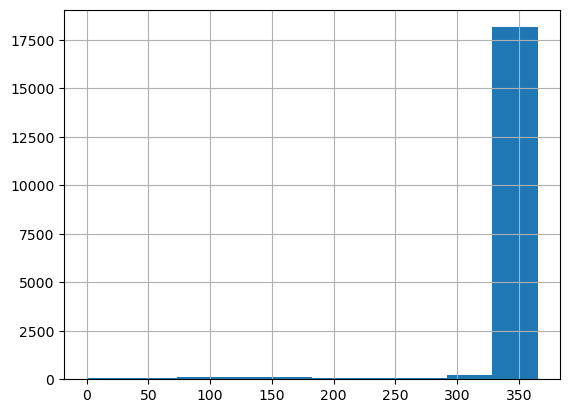

In [77]:
data.balsheet_length.hist()

In [78]:
data.drop(columns = ['begin', 'end', 'founded_year', 'founded_date', 'exit_year', 'exit_date', 'birth_year',
                     'cagr_2y', 'cagr_mean', 'cagr_std', 'status_alive', 'ind', 'ind2', 'ind2_cat', 'nace_main',
                     'origin', 'urban_m', 'region_m', 'ceo_count', 'foreign', 'female', 'gender', 'balsheet_length'], inplace = True)

In [79]:
data.rename(columns = {'balsheet_notfullyear' : 'flag_balsheet_notfullyear'}, inplace = True)

In [80]:
pd.set_option('display.max_rows', None)
data.describe().T

count          mean           std  \
year                            19036.0  2.012000e+03  0.000000e+00   
comp_id                         19036.0  1.529275e+11  1.377319e+11   
amort                           19036.0  9.274374e+03  4.975021e+04   
curr_assets                     19036.0  9.914862e+04  4.377075e+05   
curr_liab                       19036.0  8.567028e+04  4.202974e+05   
extra_exp                       19036.0  4.180172e+02  7.141930e+03   
extra_inc                       19036.0  1.641894e+03  3.283540e+04   
extra_profit_loss               19036.0  1.220200e+03  3.212567e+04   
fixed_assets                    19036.0  1.451590e+05  1.105861e+06   
inc_bef_tax                     19036.0  5.869079e+03  1.305634e+05   
intang_assets                   19036.0  3.365268e+03  5.193336e+04   
inventories                     19036.0  2.568260e+04  2.042495e+05   
liq_assets                      19036.0  2.458475e+04  1.507502e+05   
material_exp                    19036.0  1.676940e+05  5.583467e+05   
personnel_exp                   19036.0  5.353874e+04  2.108434e+05   
profit_loss_year                19036.0  5.230908e+02  1.152969e+05   
sales                           19036.0  2.357734e+05  7.704825e+05   
share_eq                        19036.0  9.144960e+04  5.644930e+05   
subscribed_cap                  19036.0  3.030463e+04  2.609142e+05   
tang_assets                     19036.0  1.334858e+05  1.059669e+06   
balsheet_flag                   19036.0  2.048750e-03  4.521791e-02   
flag_balsheet_notfullyear       19036.0  5.242698e-02  2.228924e-01   
inoffice_days                   19036.0  3.010447e+03  1.719525e+03   
b_fast_growth                   19036.0  1.248161e-01  3.305190e-01   
ln_sales                        19036.0  1.075797e+01  1.705081e+00   
sales_mil                       19036.0  2.357734e-01  7.704825e-01   
ln_sales_mil                    19036.0 -3.057544e+00  1.705081e+00   
d1_ln_sales_mil                 19036.0 -8.498686e-02  8.764572e-01   
d2_ln_sales_mil                 19036.0  3.042702e-02  1.121916e+00   
age                             19036.0  8.701828e+00  6.924531e+00   
b_new                           19036.0  1.858584e-01  3.890026e-01   
b_foreign_management            19036.0  1.057995e-01  3.075890e-01   
b_female_management             19036.0  3.109372e-01  4.628893e-01   
flag_asset_problem              19036.0  6.829166e-04  2.612443e-02   
total_assets_bs                 19036.0  2.476728e+05  1.315972e+06   
ln_intang_assets                19036.0  1.053811e+00  2.687378e+00   
ln_curr_assets                  19036.0  9.345988e+00  2.131539e+00   
ln_fixed_assets                 19036.0  7.213787e+00  4.544758e+00   
ln_total_assets                 19036.0  1.013877e+01  2.189317e+00   
d1_ln_intang_assets             19036.0 -2.019808e-02  1.332856e+00   
d2_ln_intang_assets             19036.0  1.028033e-02  1.357538e+00   
d1_ln_curr_assets               19036.0  7.390210e-04  1.027706e+00   
d2_ln_curr_assets               19036.0  8.064654e-02  9.539927e-01   
d1_ln_fixed_assets              19036.0 -1.645084e-02  1.698985e+00   
d2_ln_fixed_assets              19036.0  1.980435e-01  1.875217e+00   
d1_ln_total_assets              19036.0  3.177958e-03  8.093391e-01   
d2_ln_total_assets              19036.0  9.316131e-02  7.685200e-01   
d1_inc_bef_tax                  19036.0  1.068172e+03  1.321162e+05   
d2_inc_bef_tax                  19036.0  4.724430e+02  1.024338e+05   
d1_inventories                  19036.0  1.803186e+03  8.478519e+04   
d2_inventories                  19036.0  2.609082e+03  7.831966e+04   
d1_material_exp                 19036.0  2.031560e+03  2.148597e+05   
d2_material_exp                 19036.0  1.354893e+04  2.514655e+05   
d1_profit_loss_year             19036.0  1.607936e+03  1.269006e+05   
d2_profit_loss_year             19036.0 -7.490160e+02  9.816039e+04   
d1_personnel_exp                19036.0  1.661174e+03  4.6

In [81]:
pd.reset_option('display.max_rows')

Let's create winsorized variables now. As I have 66 variables, I resort to the simpler approach: the winsorization frame is defined by the 5th and 95th percentiles.

In [82]:
num_cols = []
for c in data.columns:
    if 'flag' not in c and c[0:2] != 'b_' and c[0:2] != 'f_' and c not in ['year', 'comp_id']:
        num_cols.append(c)

In [151]:
len(num_cols)

66

I only winsorize variables for which I did not set upper and lower bounds before. For those that have a 0 minimum, I only winsorize on the higher end.

In [84]:
hl_winsor = list(set(num_cols) - set(anyof) - set(['ceo_age']) - set(zero))
h_winsor = [c for c in hl_winsor if data[c].min() == 0]
hl_winsor = list(set(hl_winsor) - set(h_winsor))

In [139]:
toplot = []
for v in hl_winsor:
    low = np.quantile(data[v], 0.05)
    high = np.quantile(data[v], 0.95)
    data[f'flag_low_{v}'] = np.where(data[v] < low, 1, 0)
    data[f'flag_high_{v}'] = np.where(data[v] > high, 1, 0)
    data[f'{v}_wins']= np.where(
        data[v] < low,
        low,
        np.where(
            data[v] > high,
            high,
            data[v])
    )
    toplot.append(f'{v}_wins')

for v in h_winsor:
    high = np.quantile(data[v], 0.95)
    data[f'flag_high_{v}'] = np.where(data[v] > high, 1, 0)
    data[f'{v}_wins']= np.where(
            data[v] > high,
            high,
            data[v])
    toplot.append(f'{v}_wins')

toplot = toplot + zero + anyof + ['ceo_age']

In [141]:
toplot.sort()

Let's look at LOWESS plots now for quantitative columns (winsorized if applicable).

age_wins


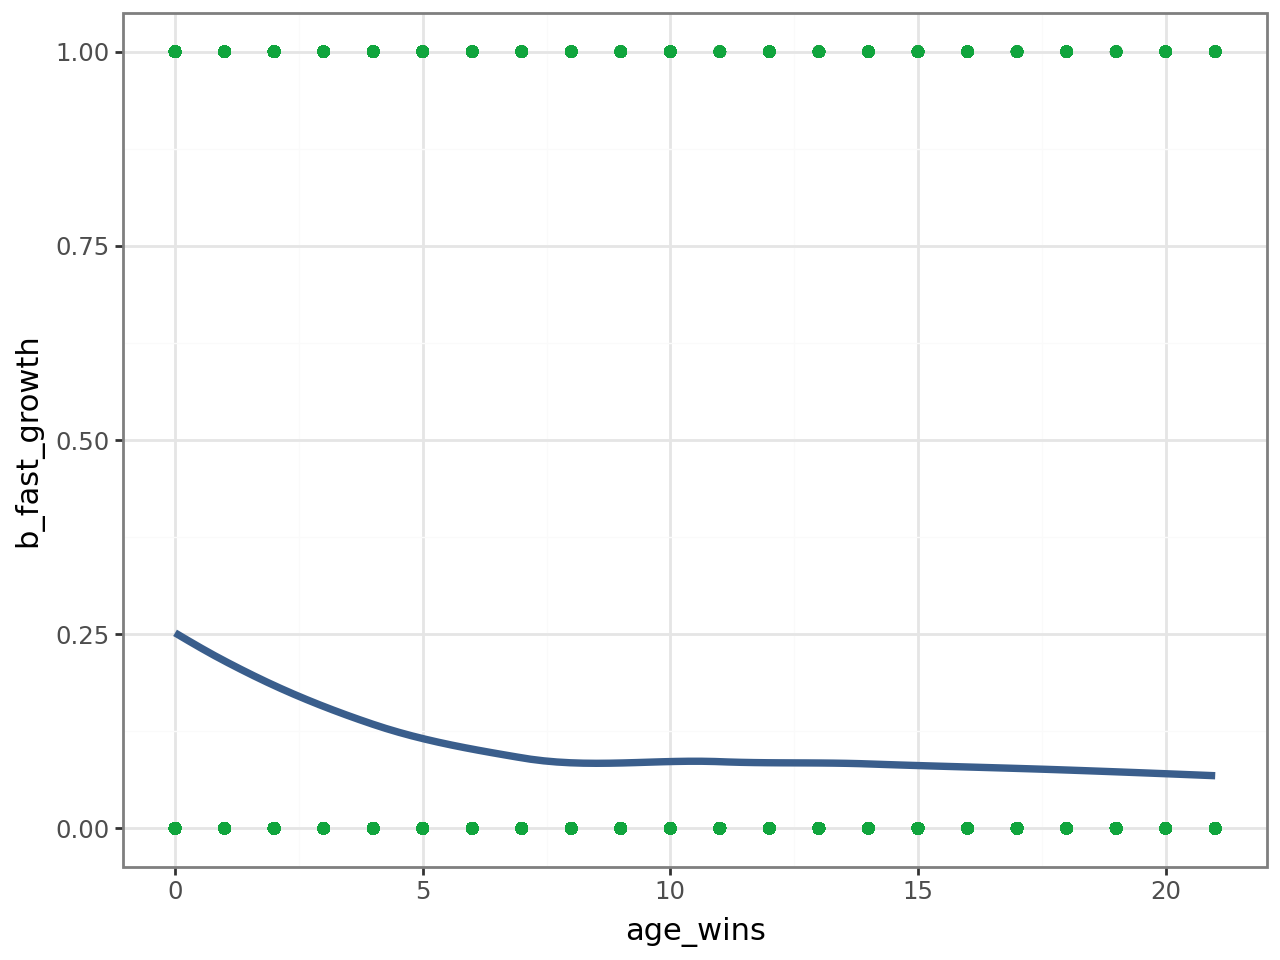

amort_wins


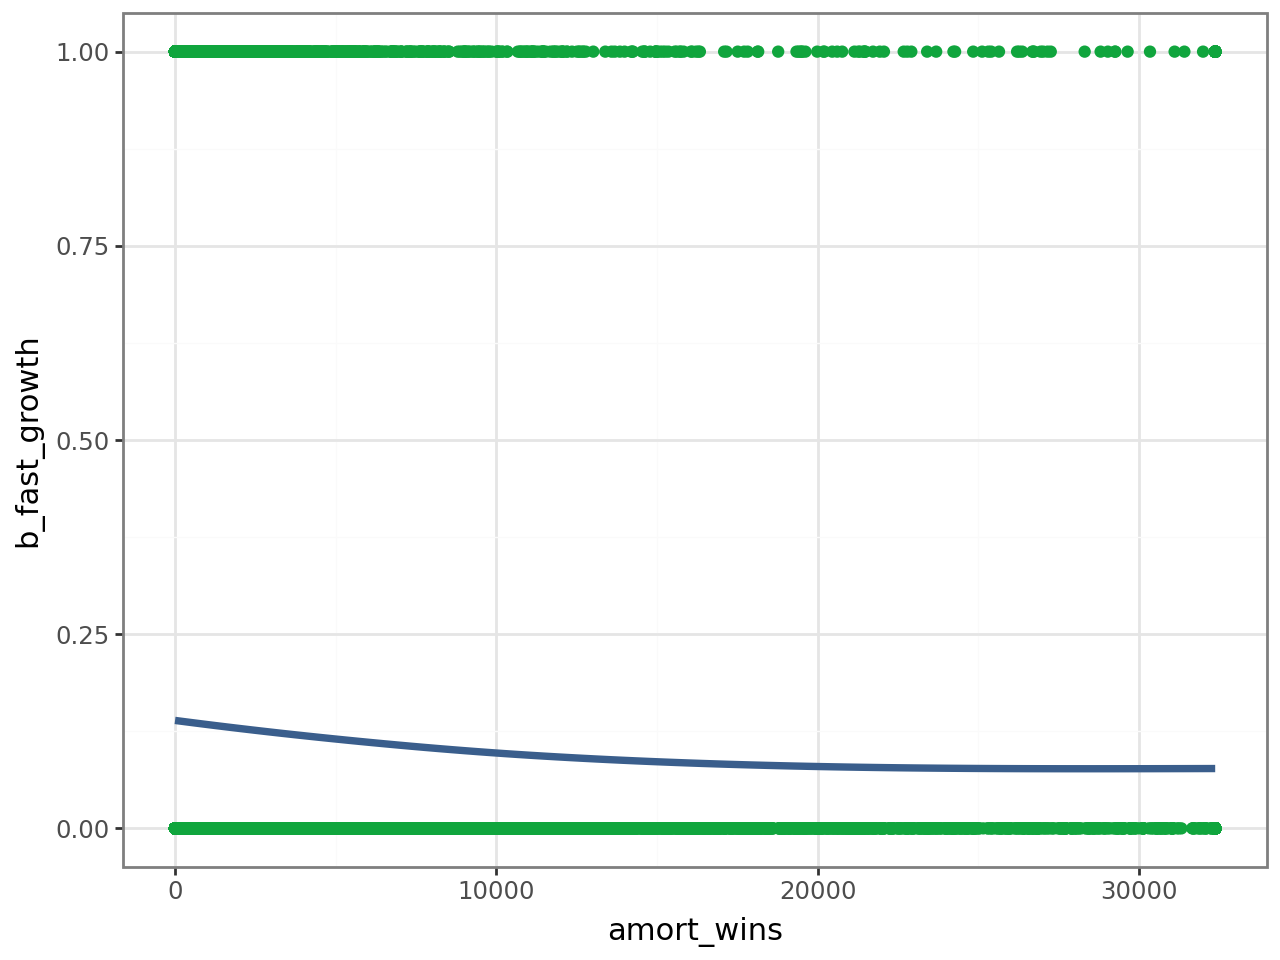

ceo_age


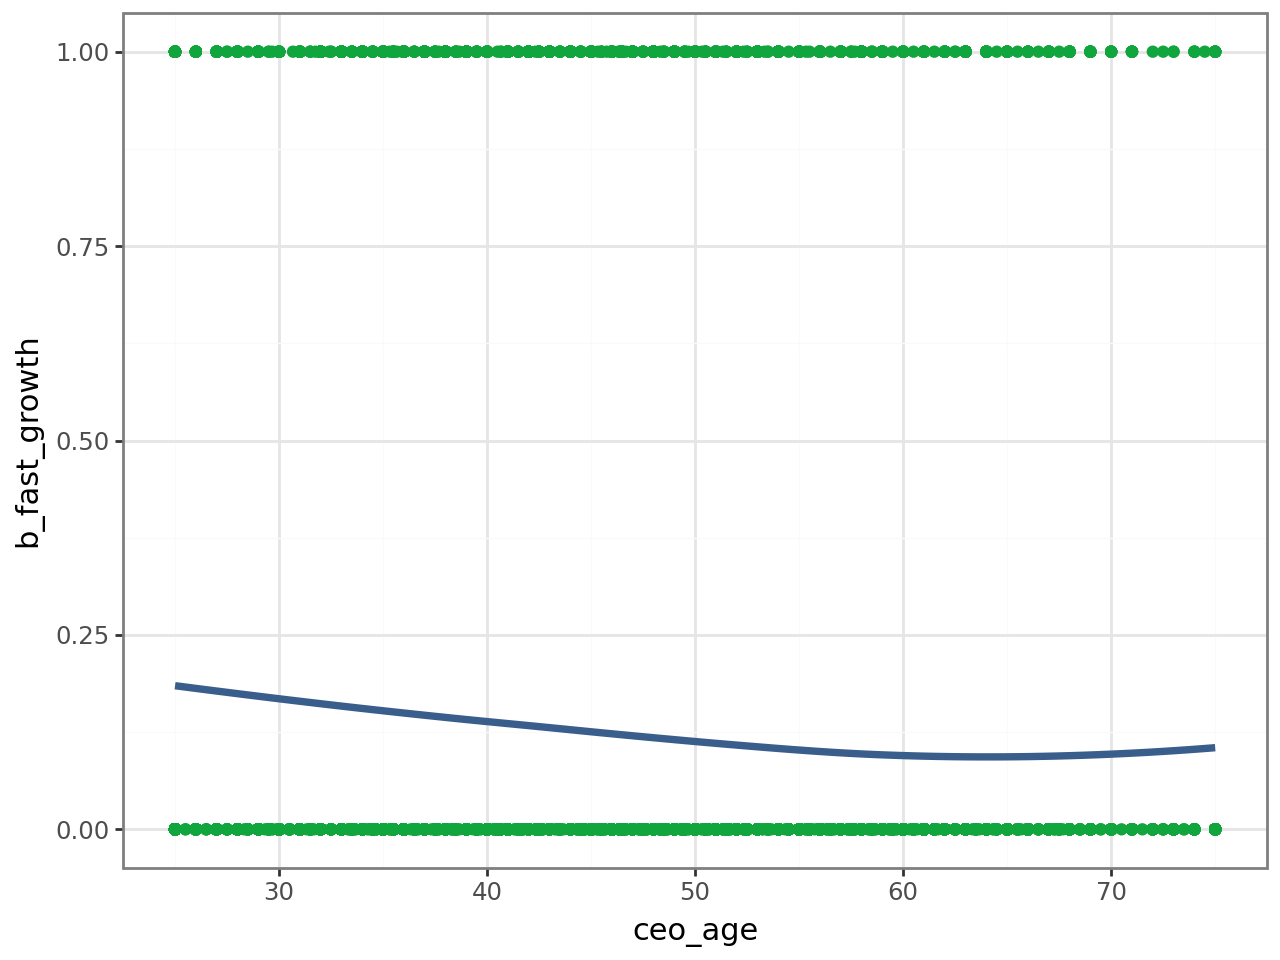

curr_assets_bs


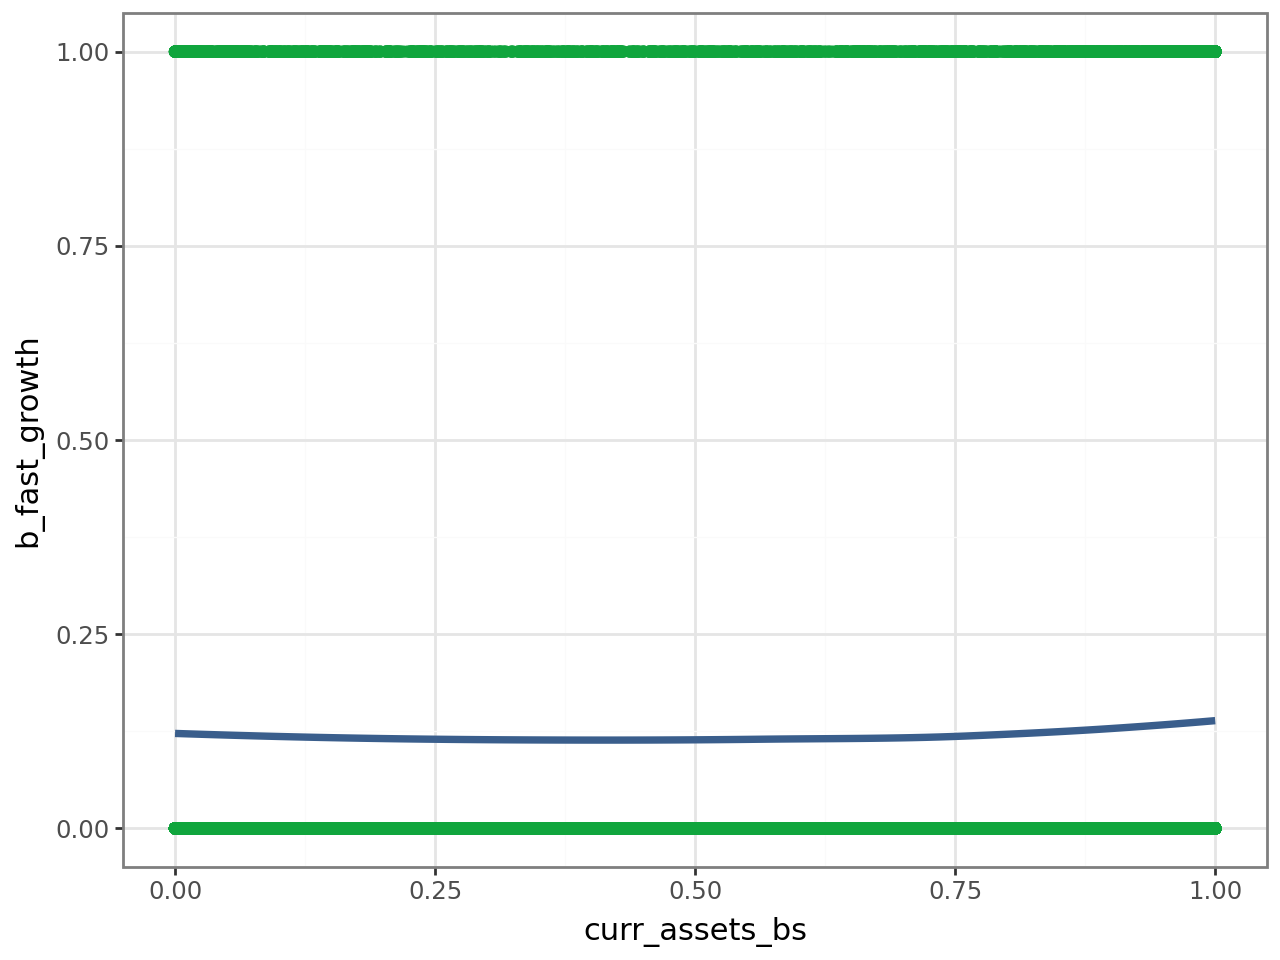

curr_assets_wins


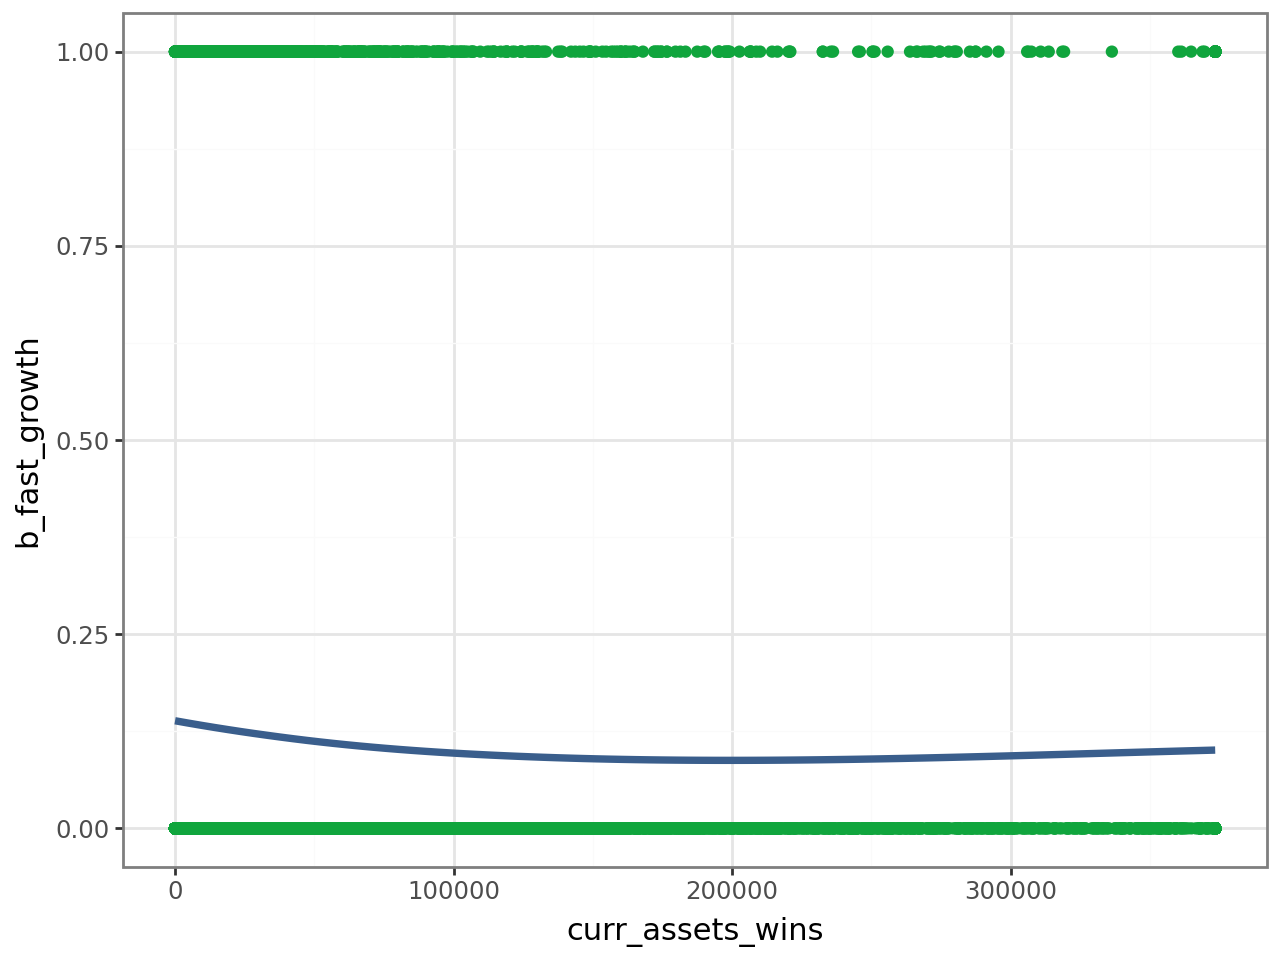

curr_liab_bs


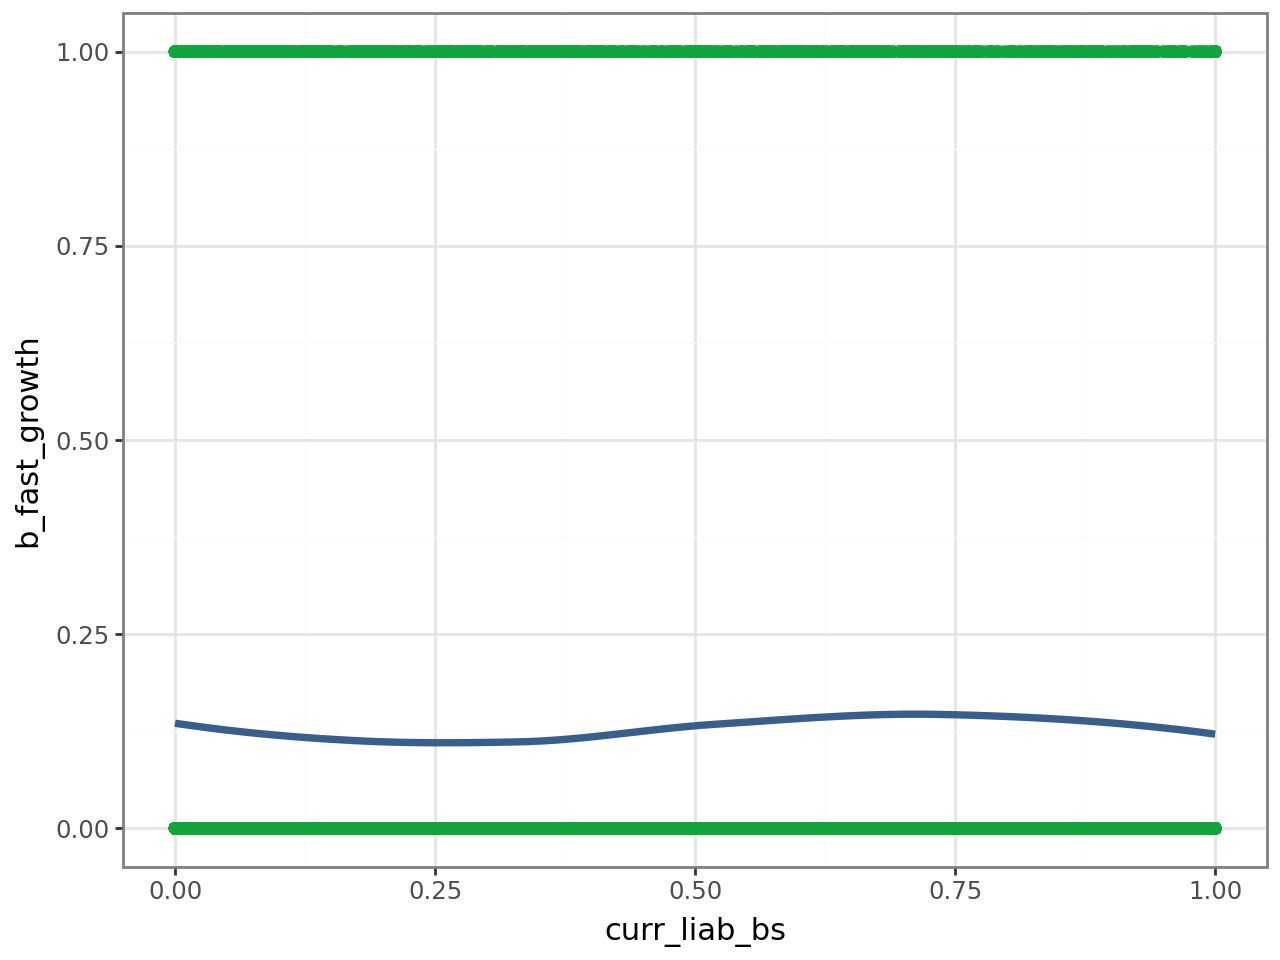

curr_liab_wins


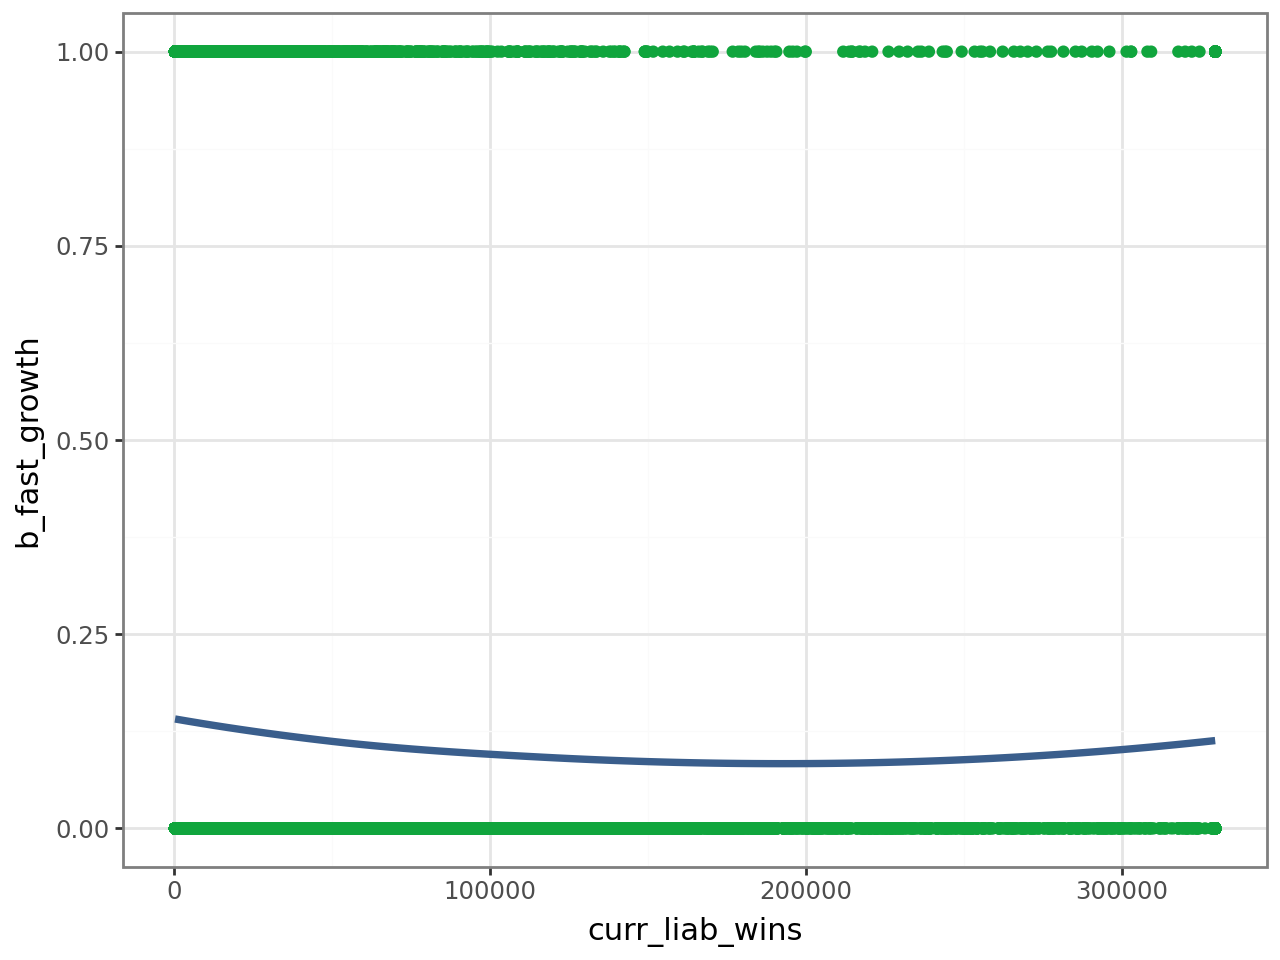

d1_inc_bef_tax_wins


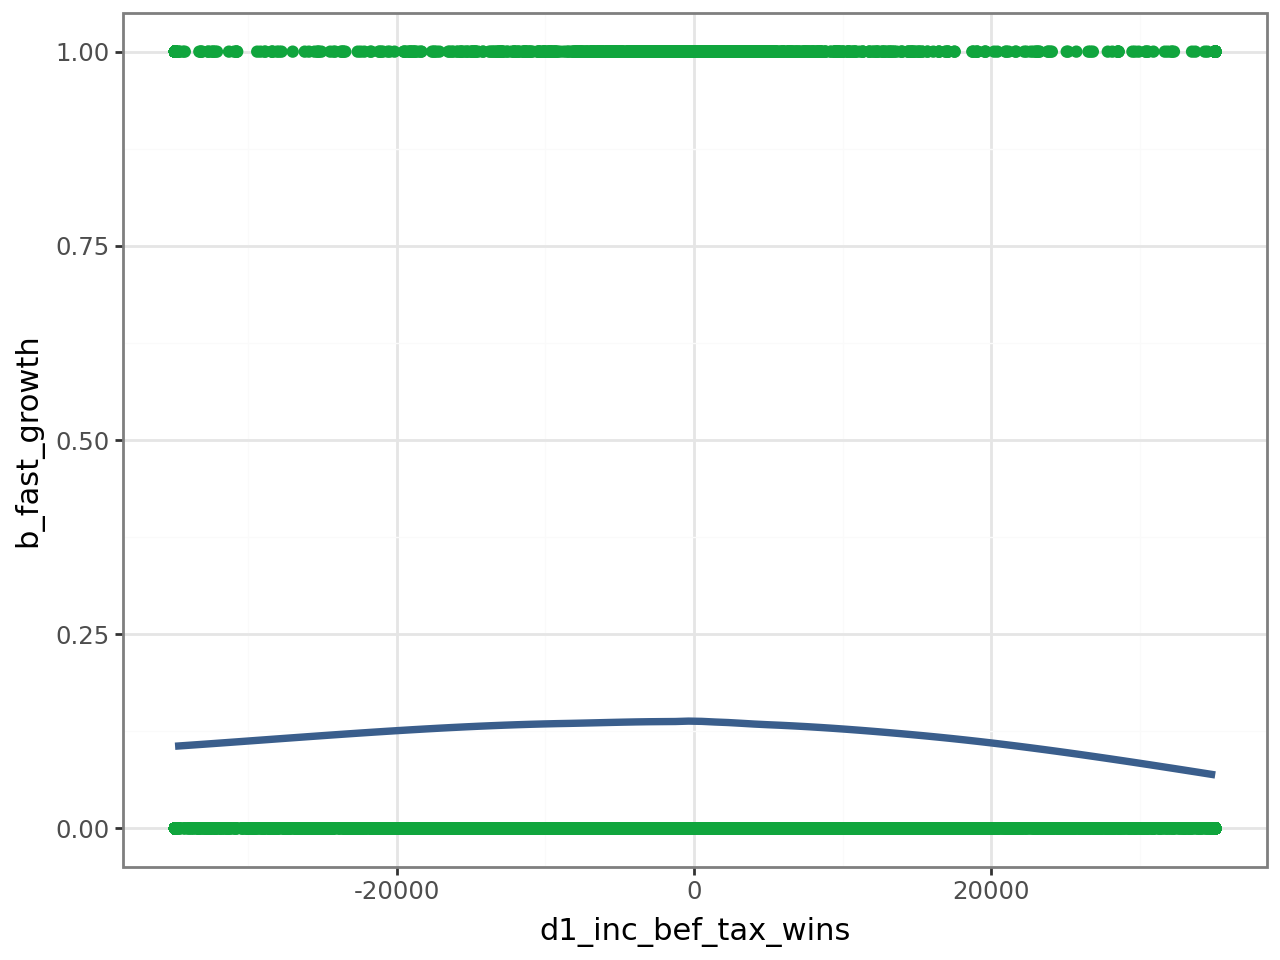

d1_inventories_wins


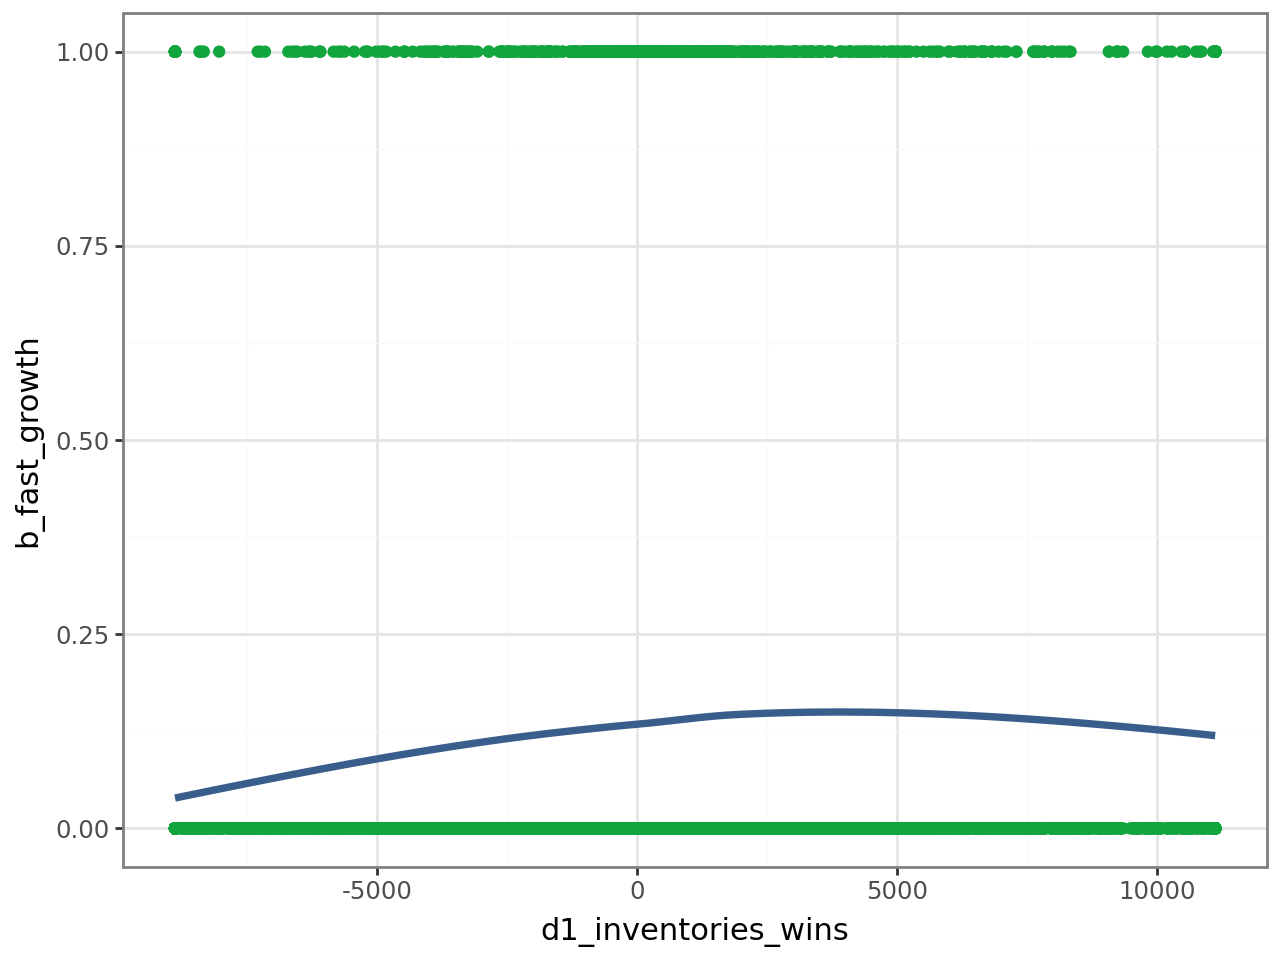

d1_ln_curr_assets_wins


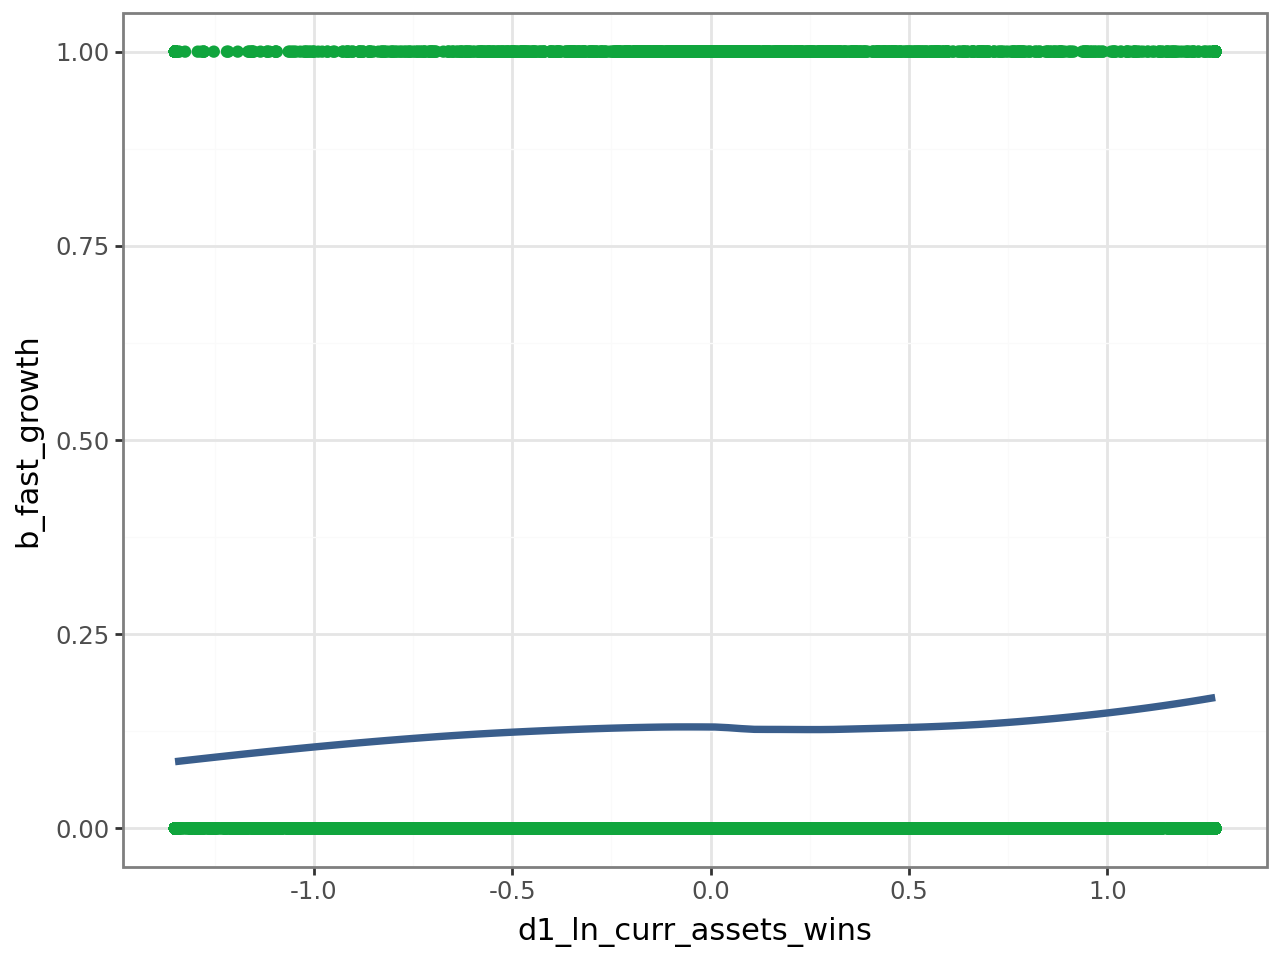

d1_ln_fixed_assets_wins


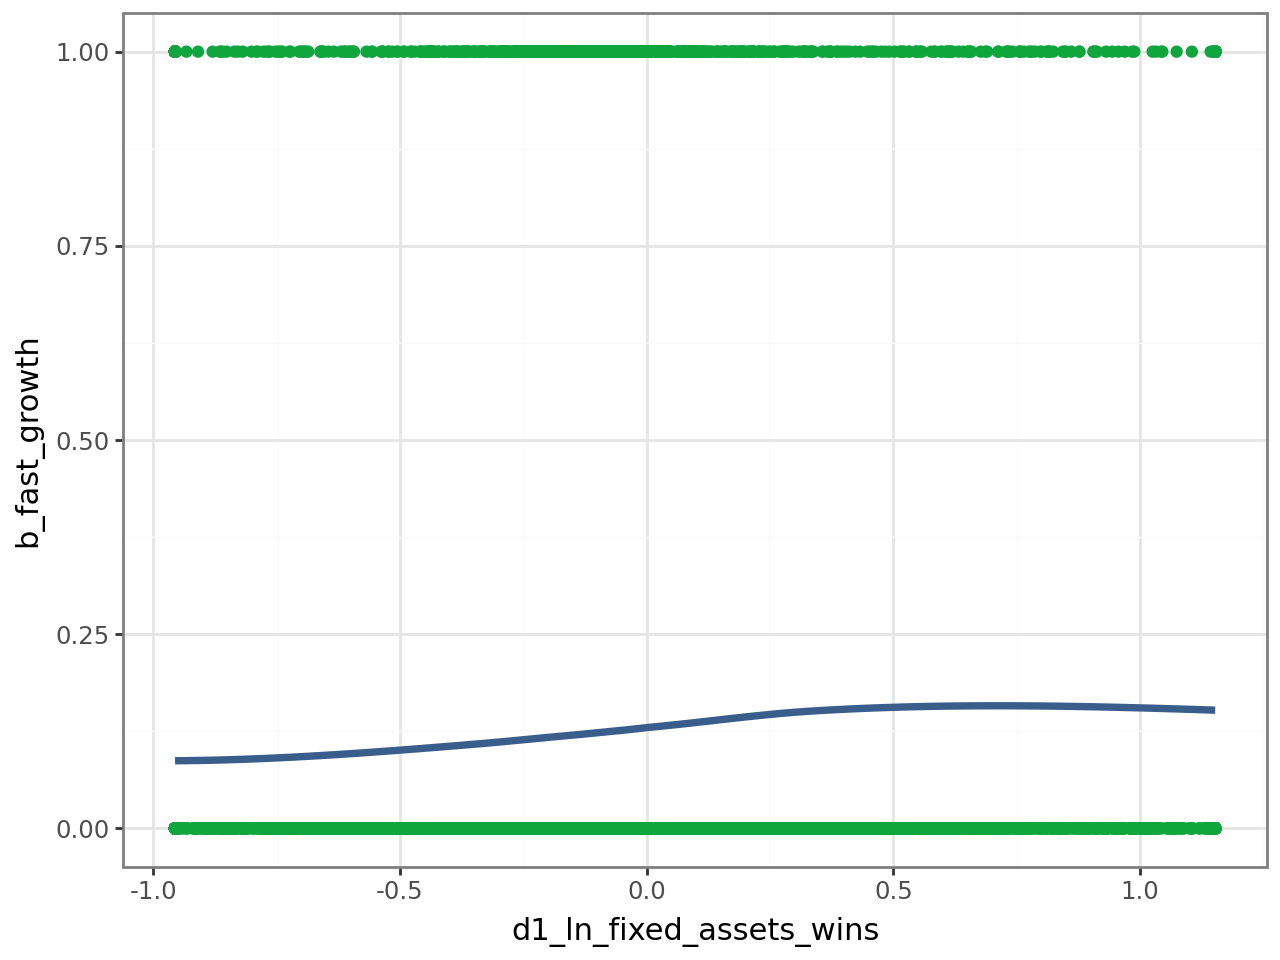

d1_ln_intang_assets_wins


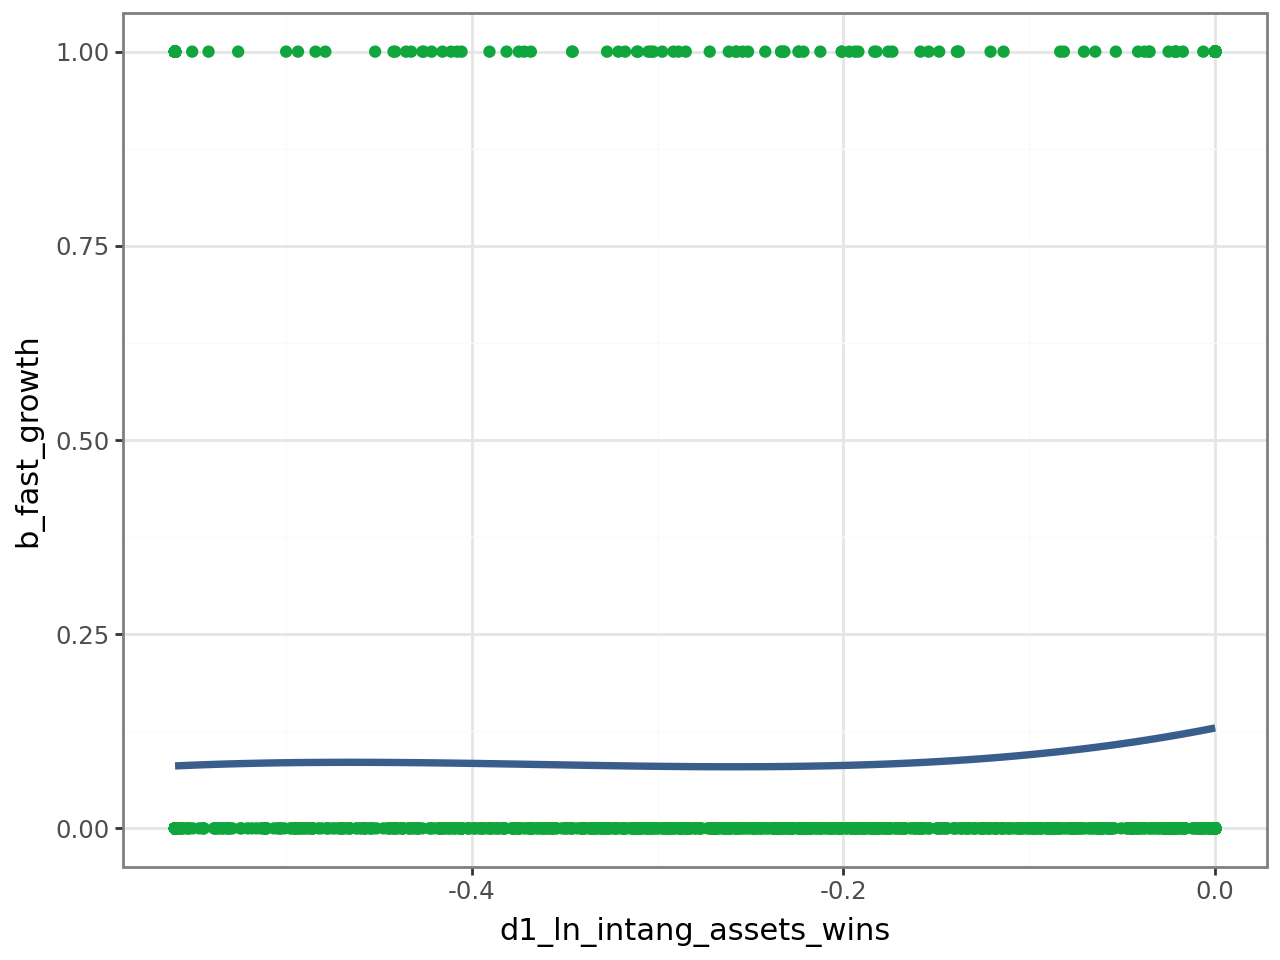

d1_ln_sales_mil_wins


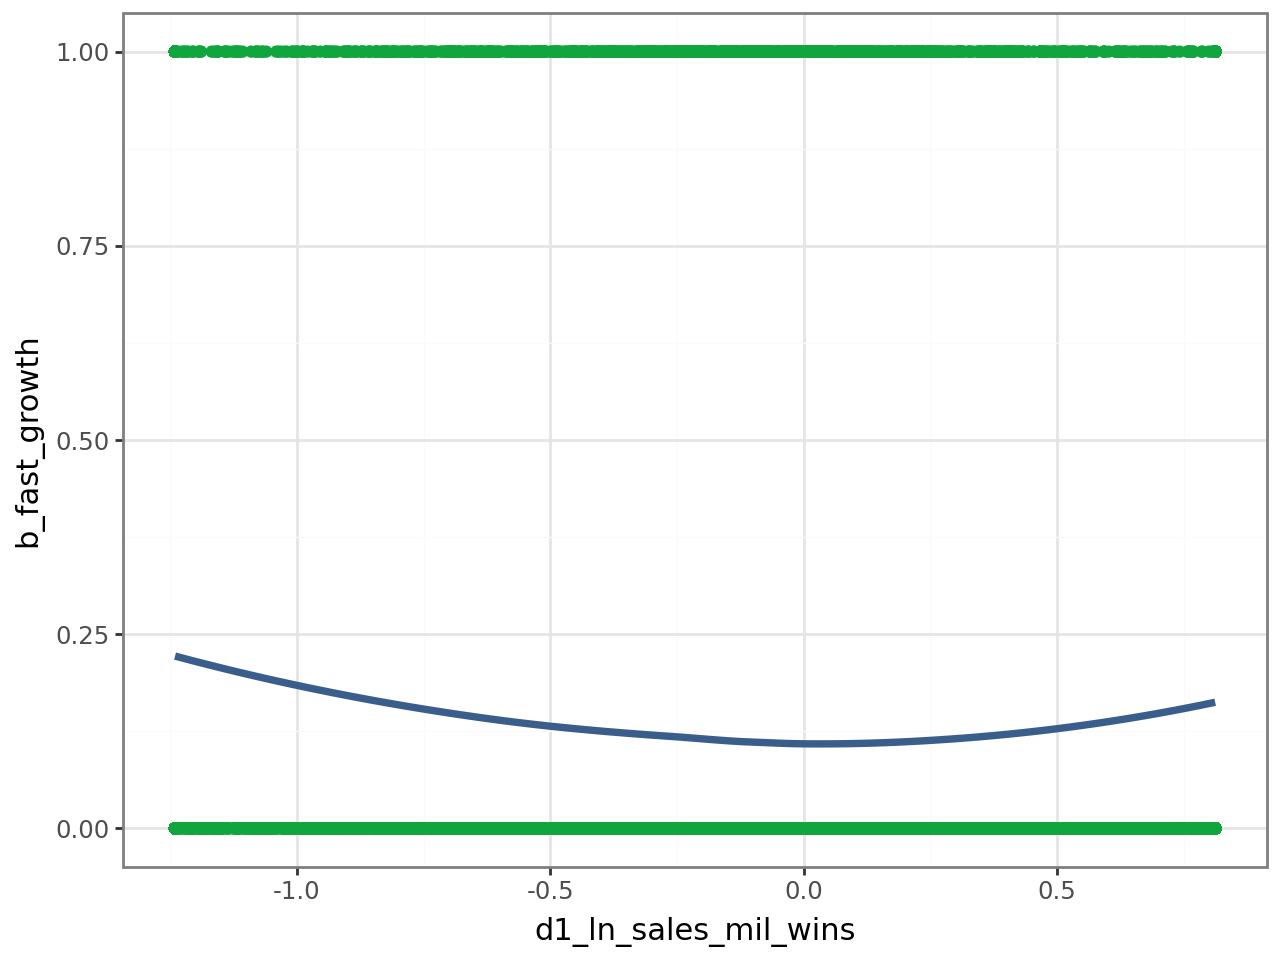

d1_ln_total_assets_wins


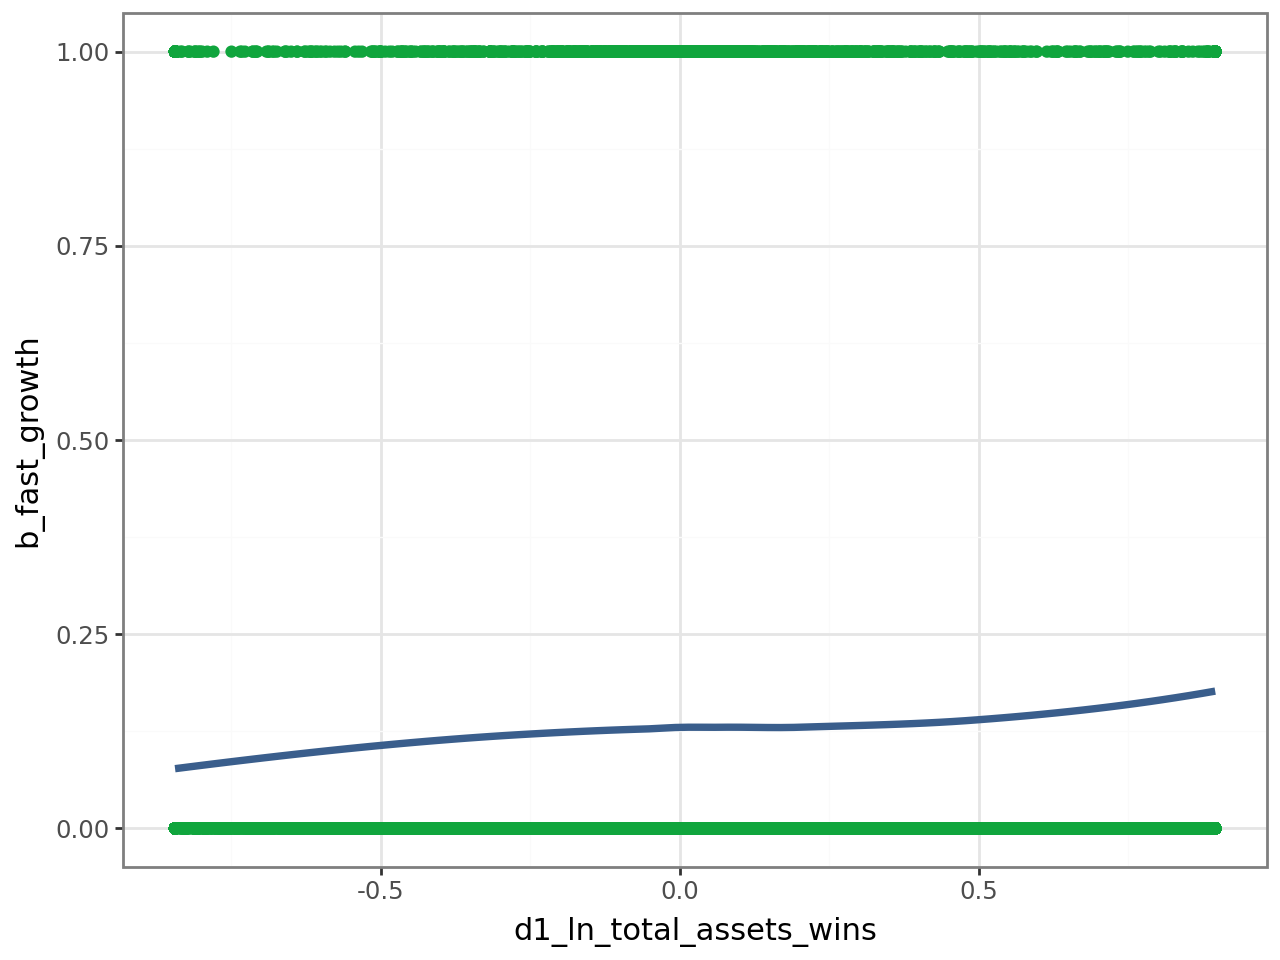

d1_material_exp_wins


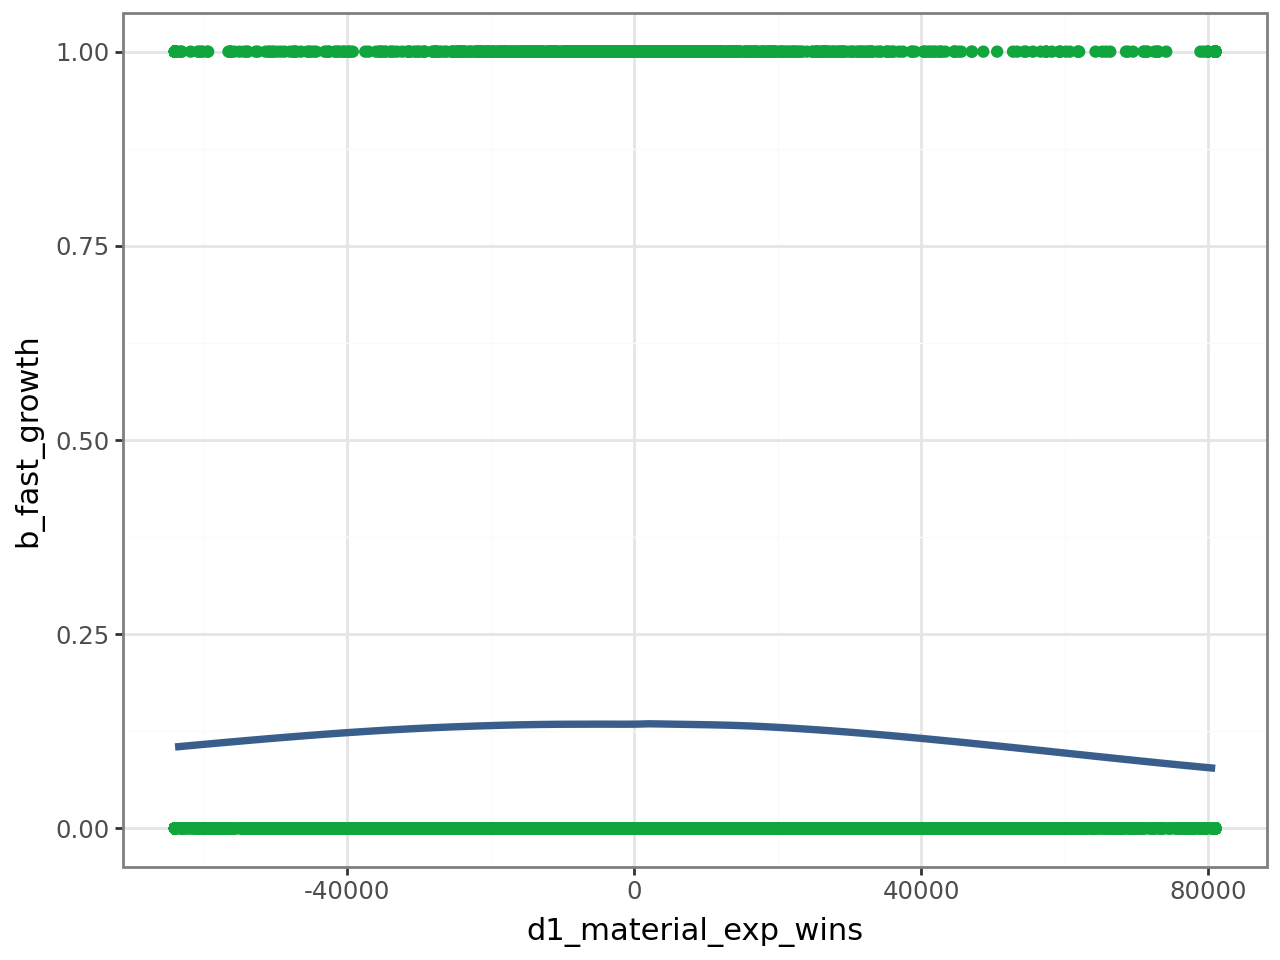

d1_personnel_exp_wins


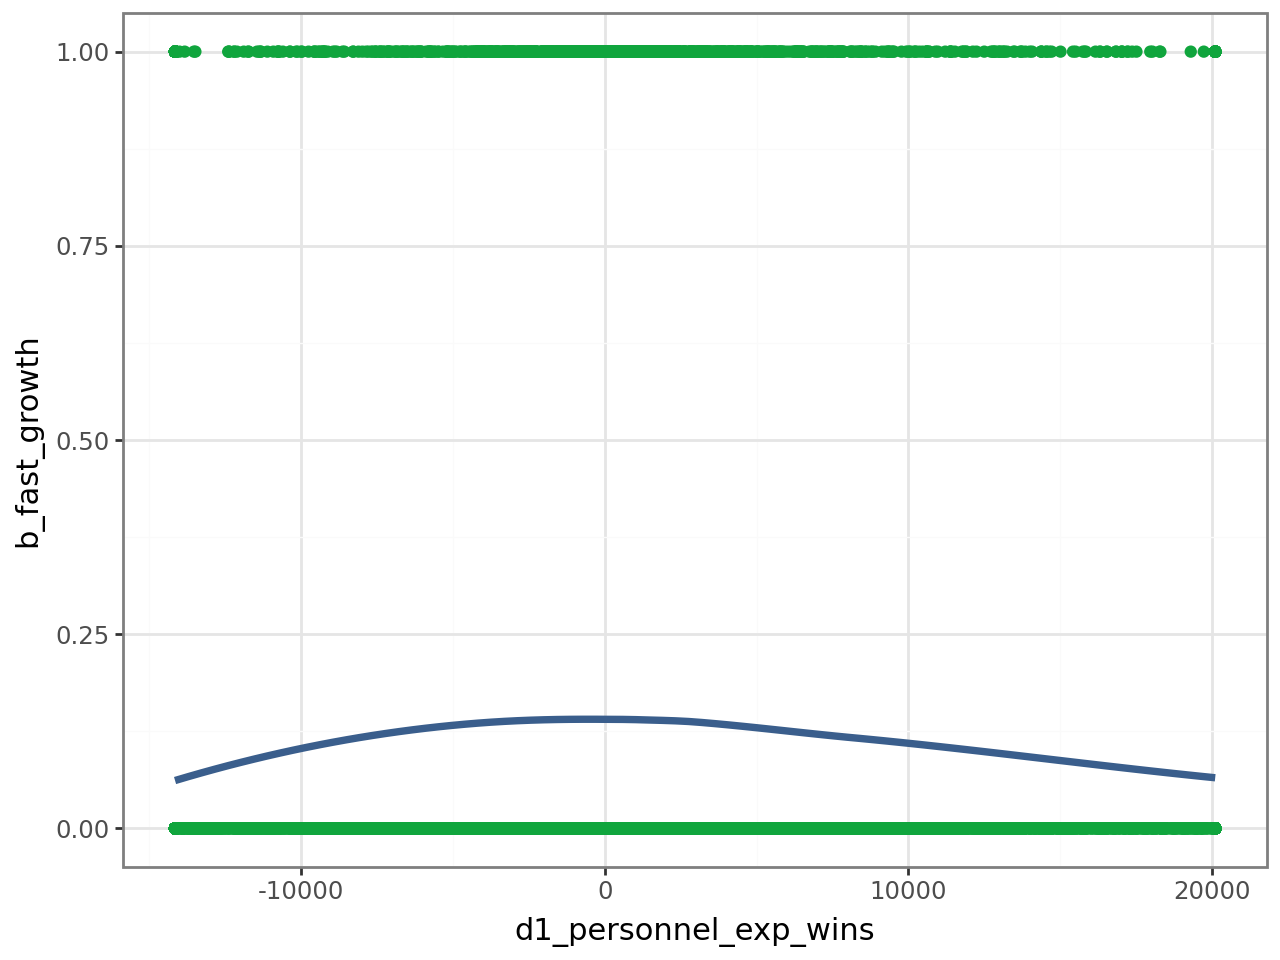

d1_profit_loss_year_wins


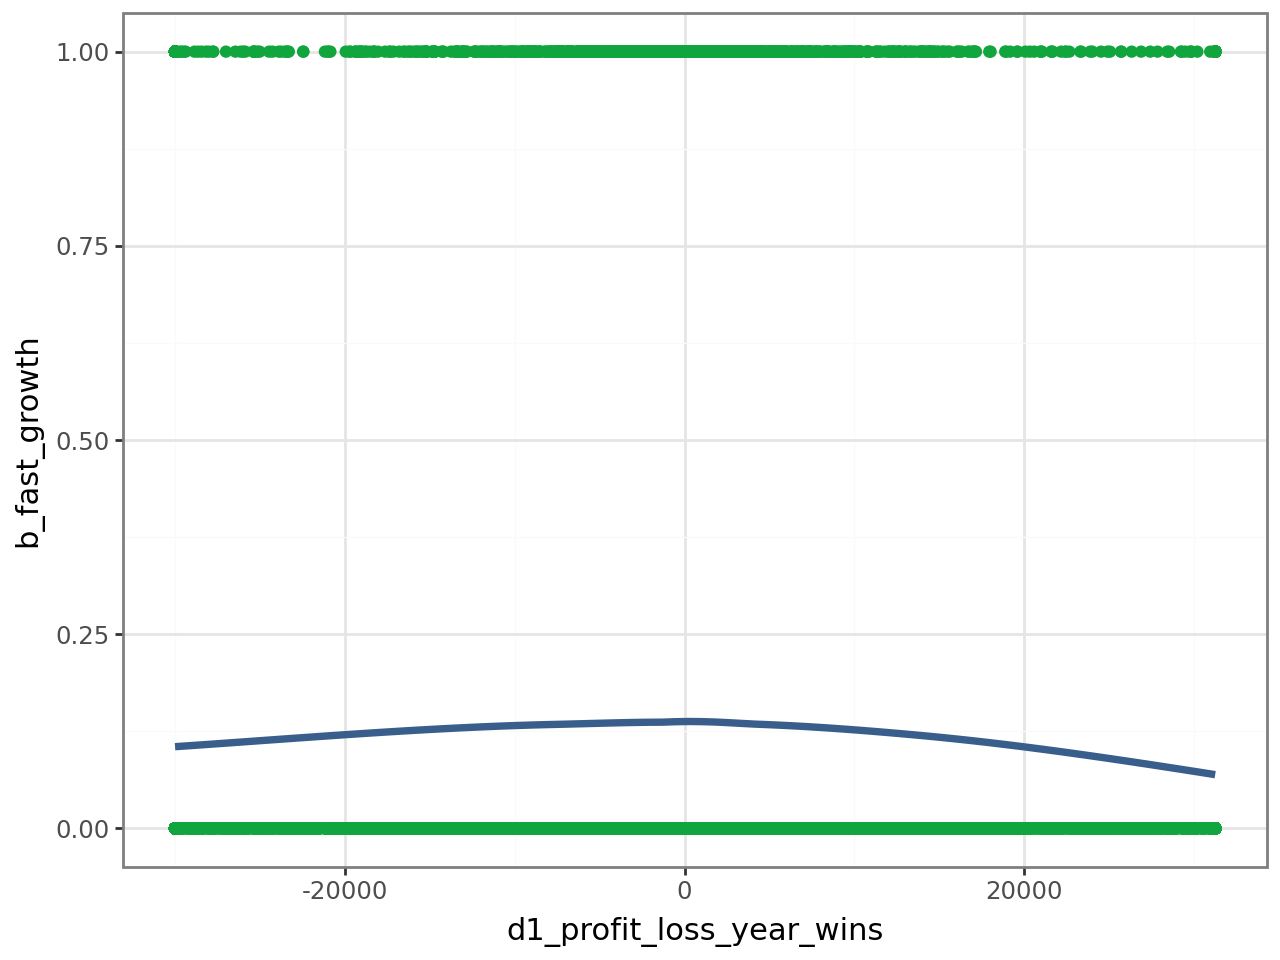

d2_inc_bef_tax_wins


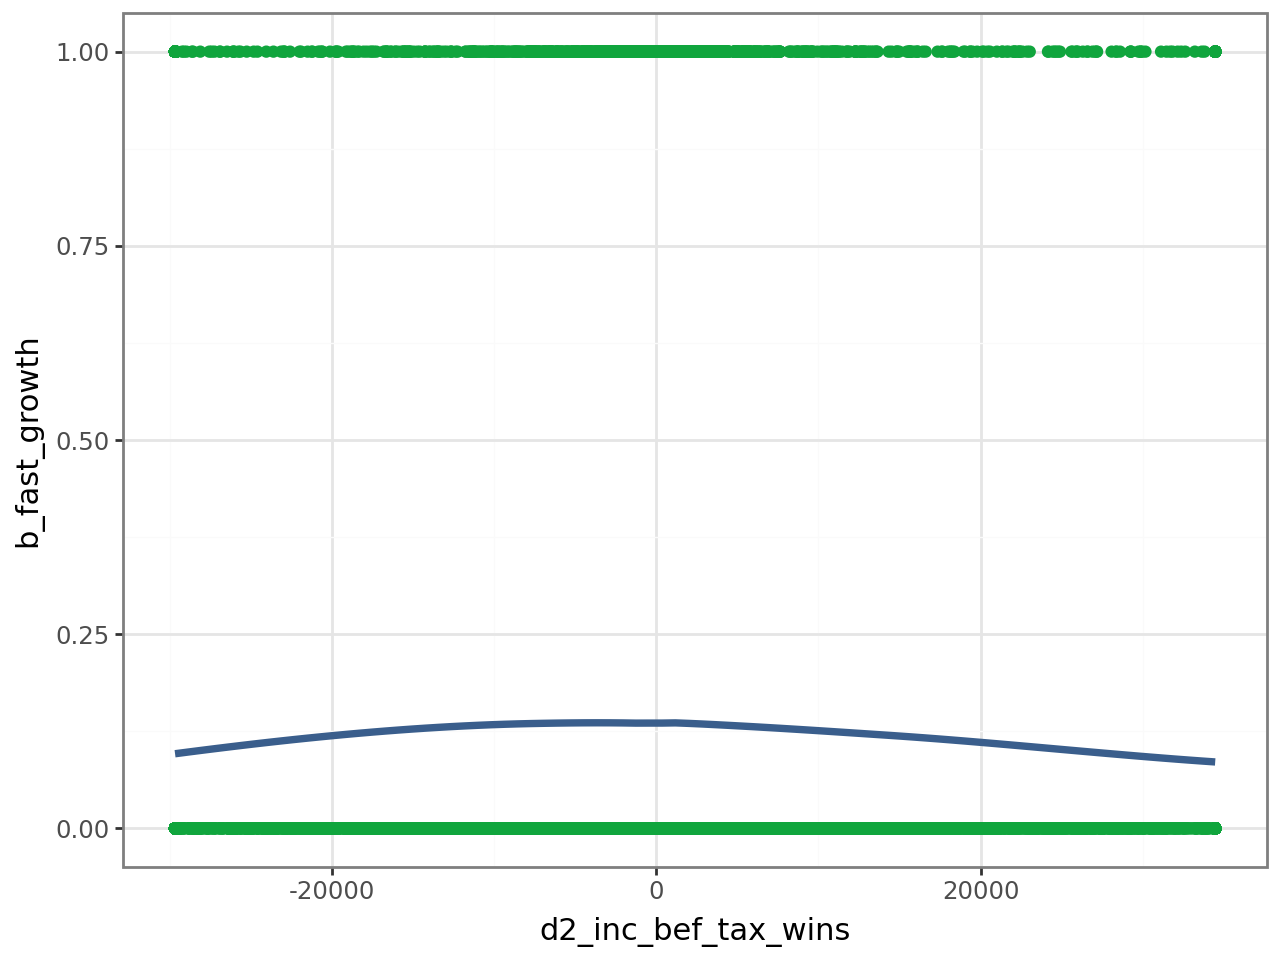

d2_inventories_wins


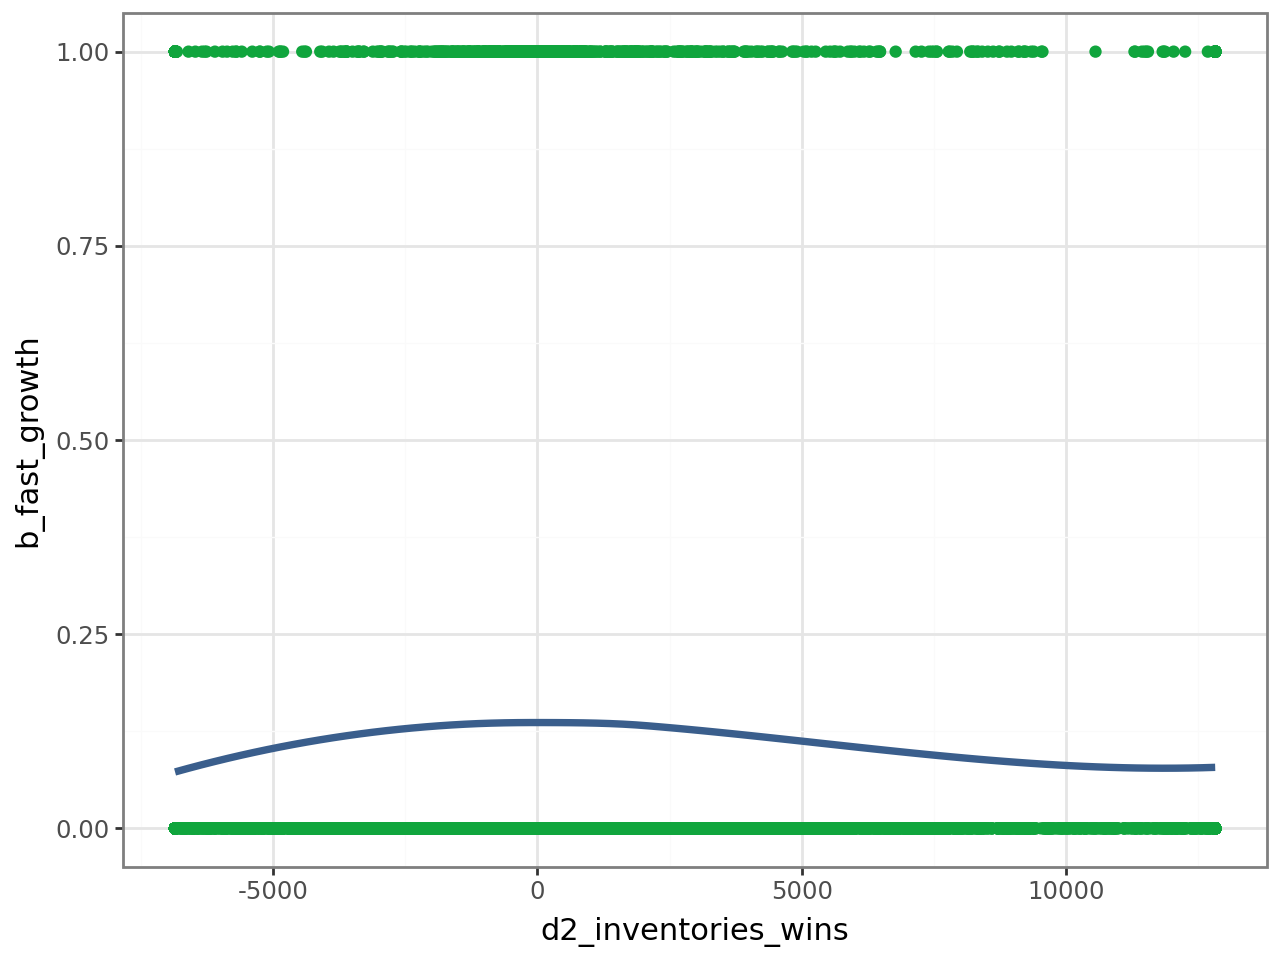

d2_ln_curr_assets_wins


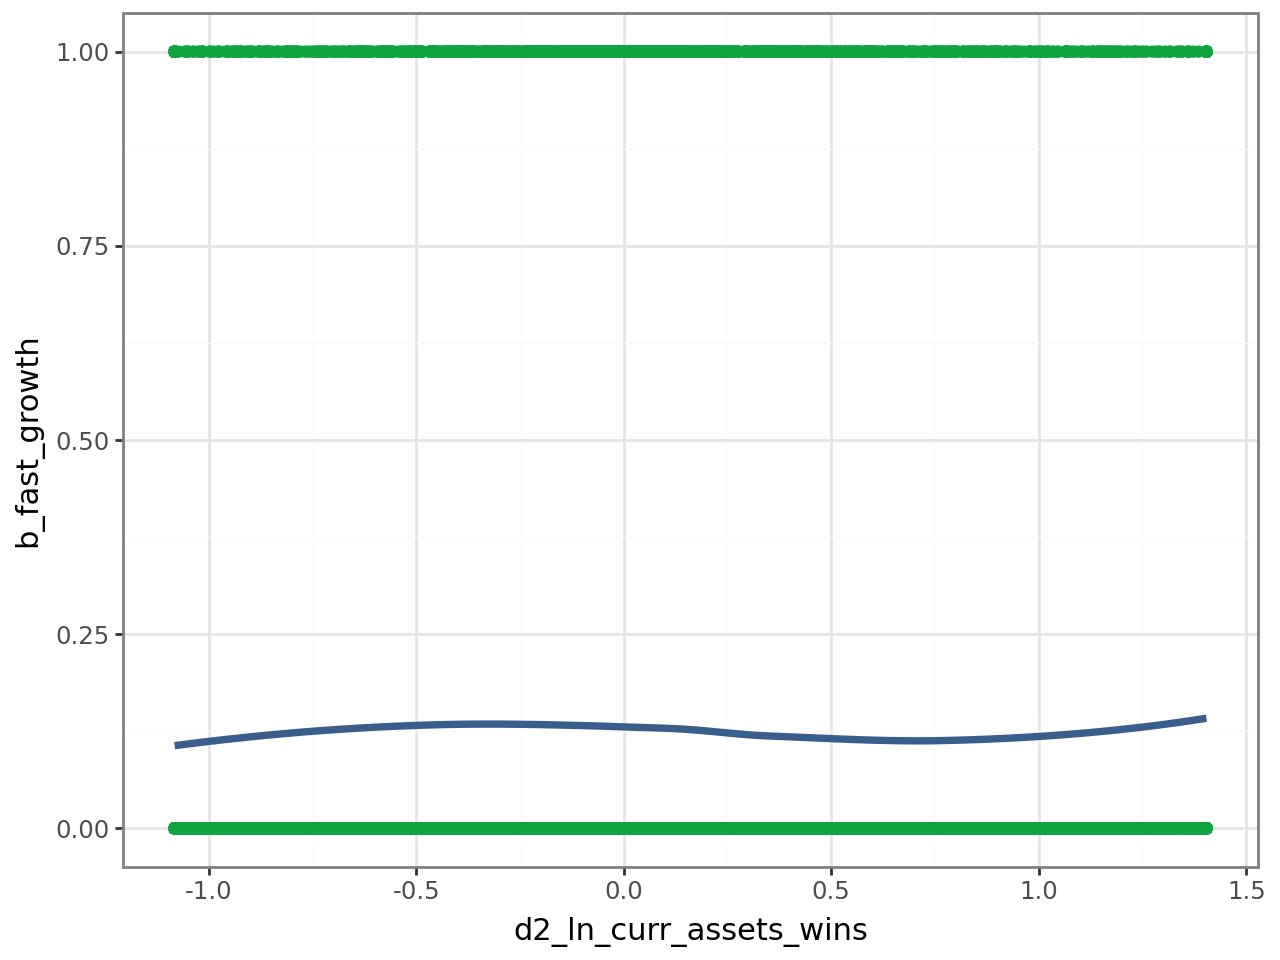

d2_ln_fixed_assets_wins


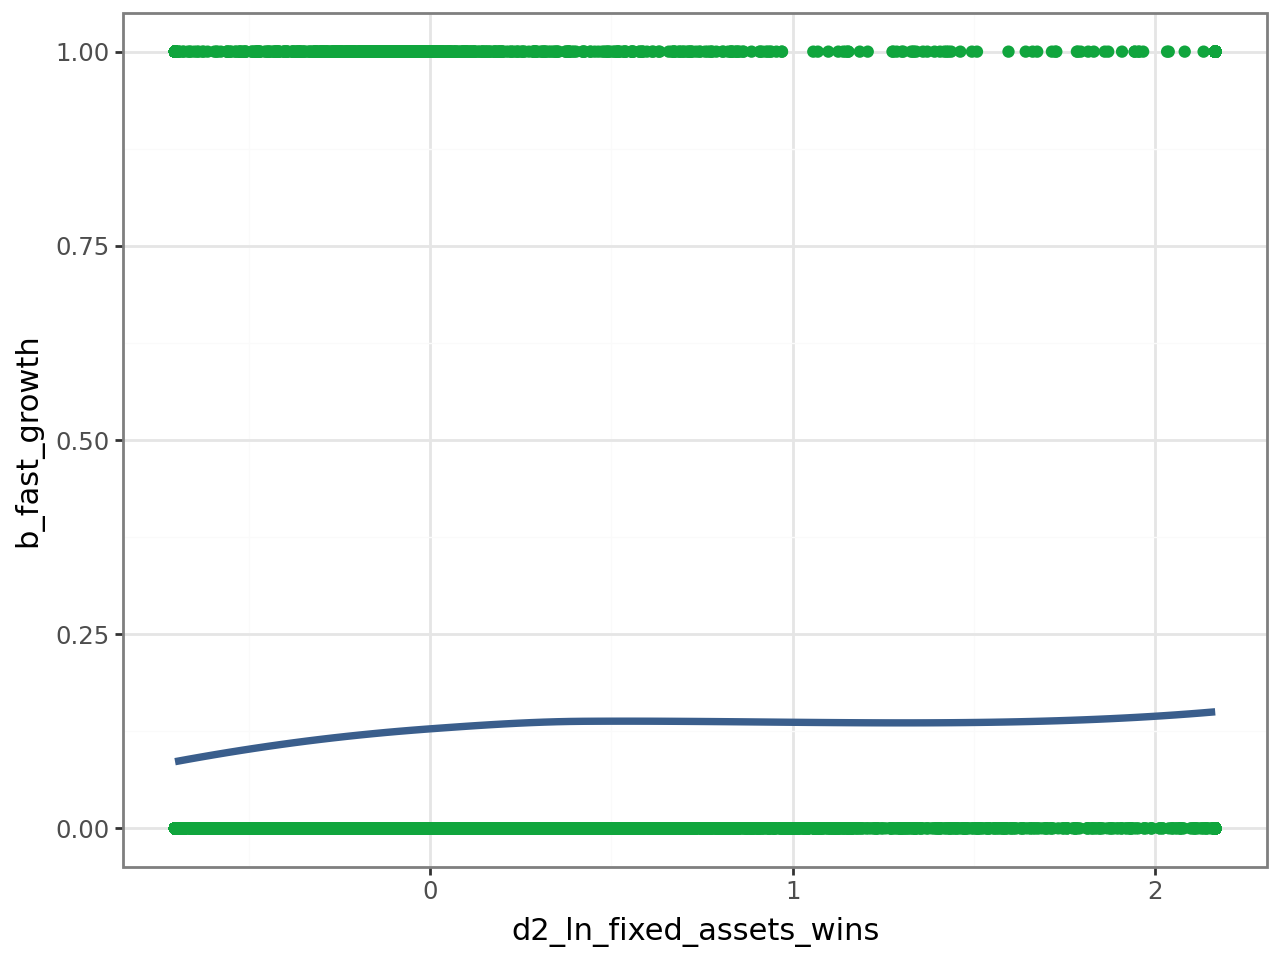

d2_ln_intang_assets_wins


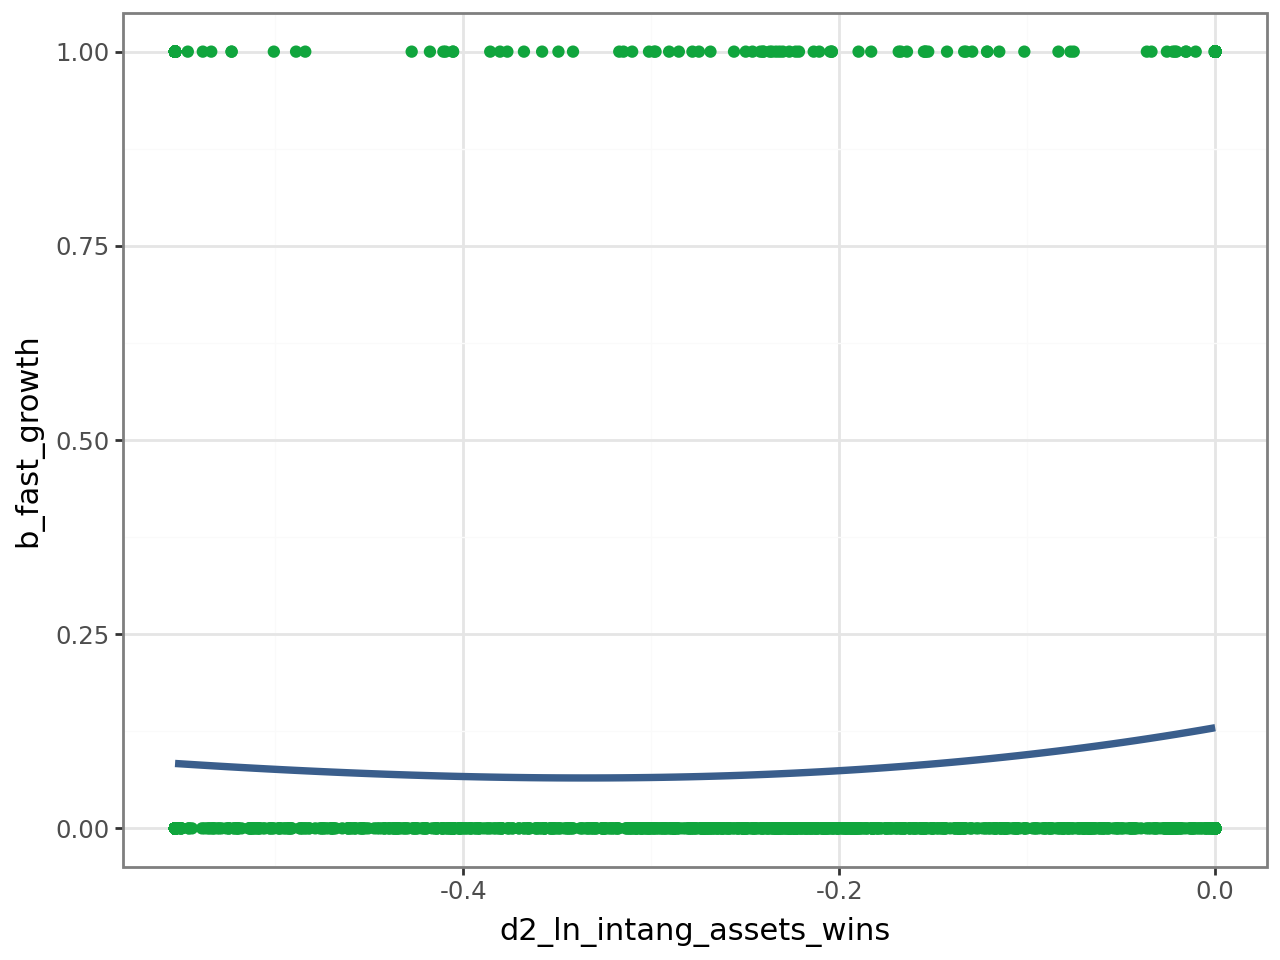

d2_ln_sales_mil_wins


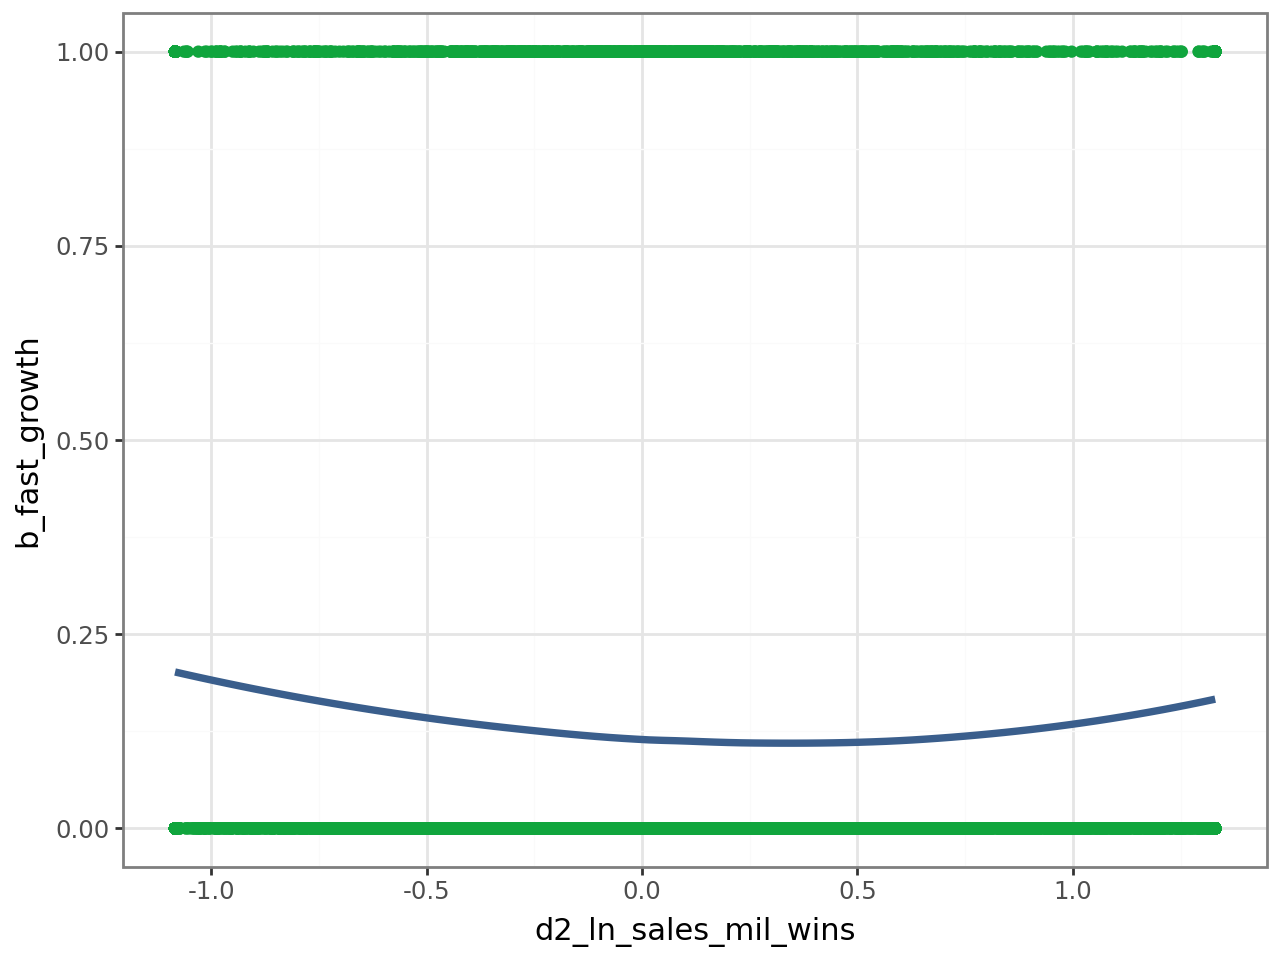

d2_ln_total_assets_wins


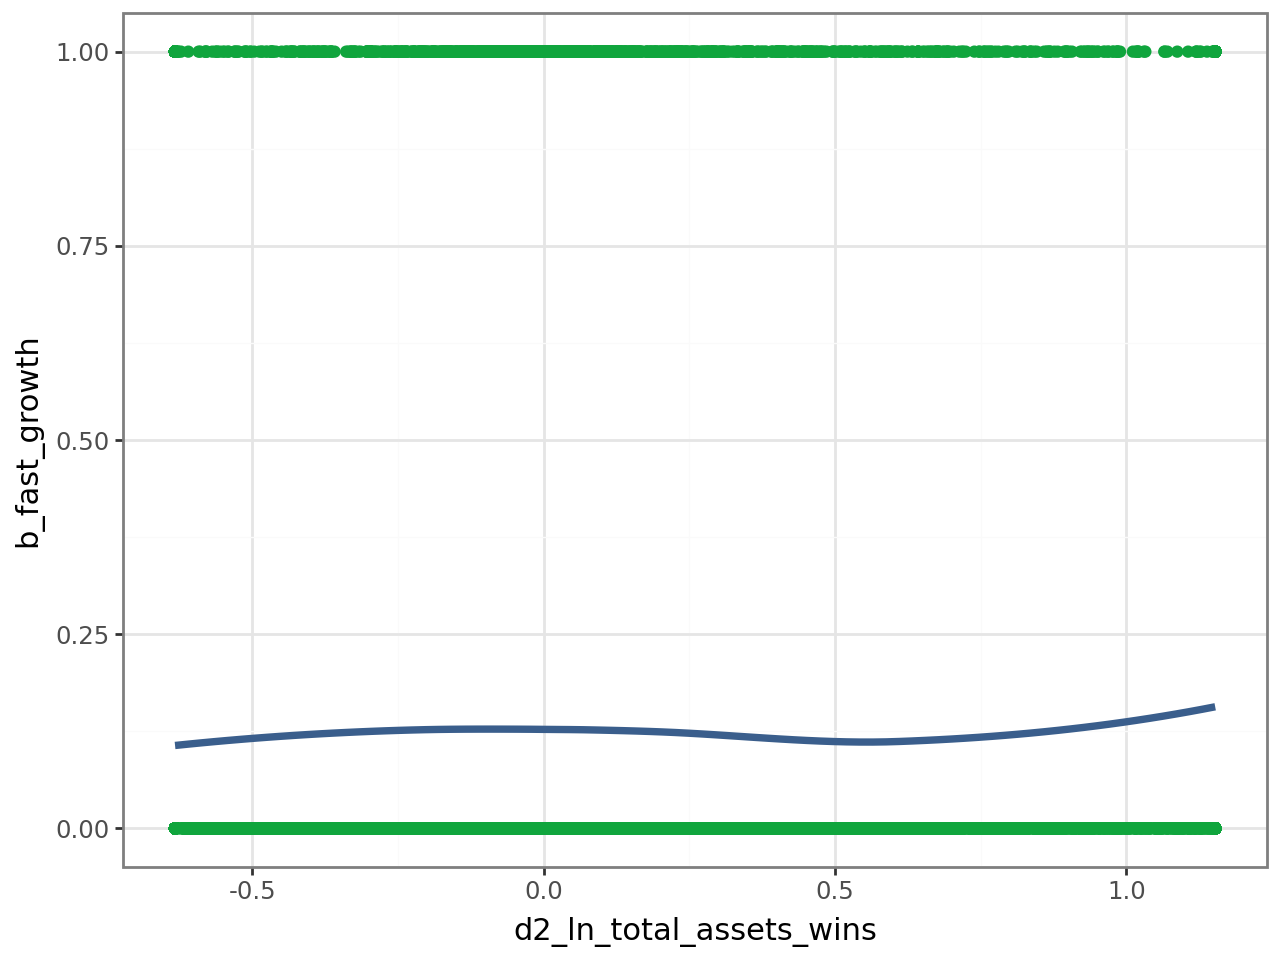

d2_material_exp_wins


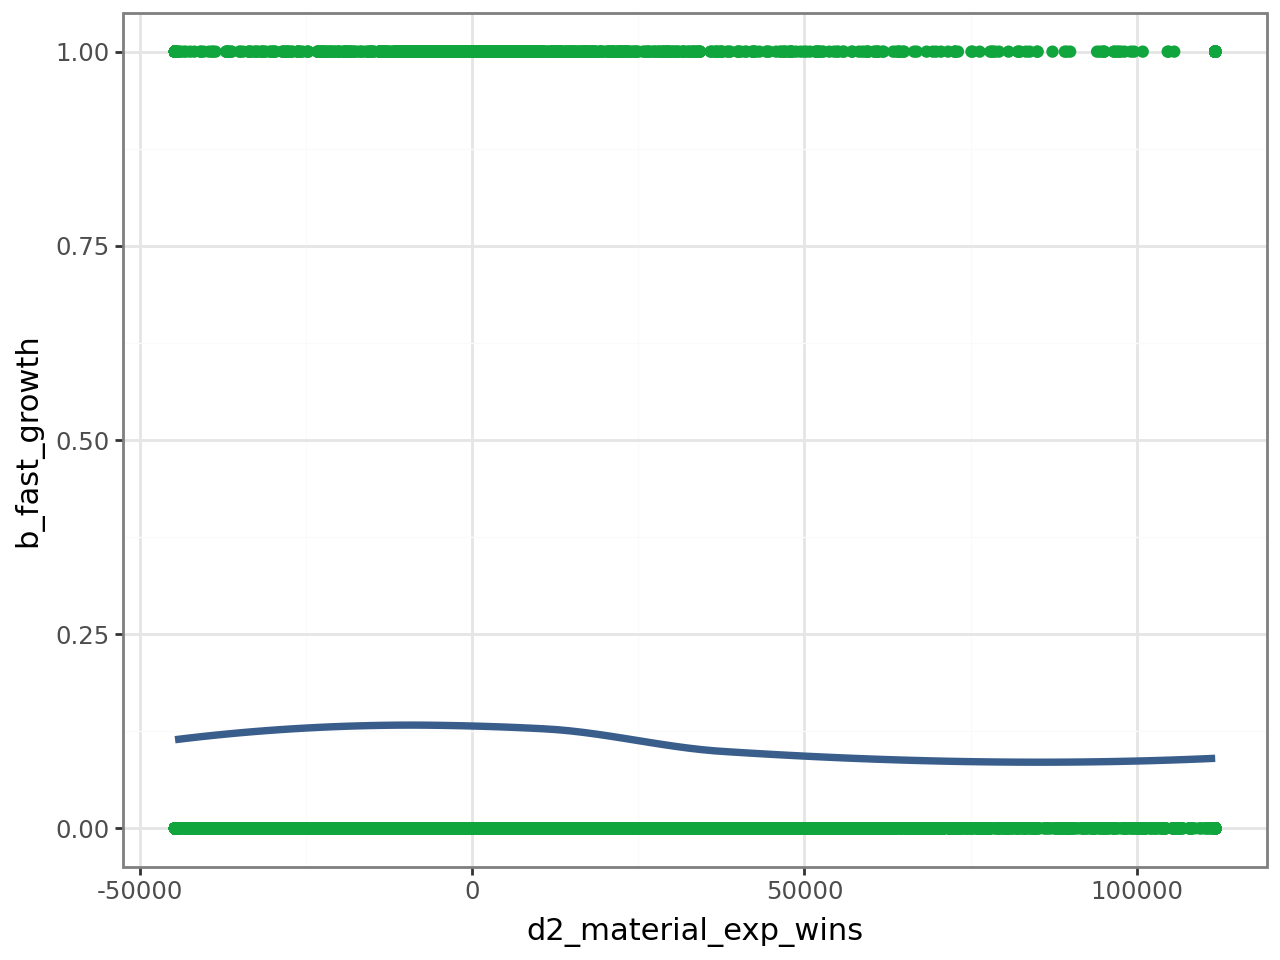

d2_personnel_exp_wins


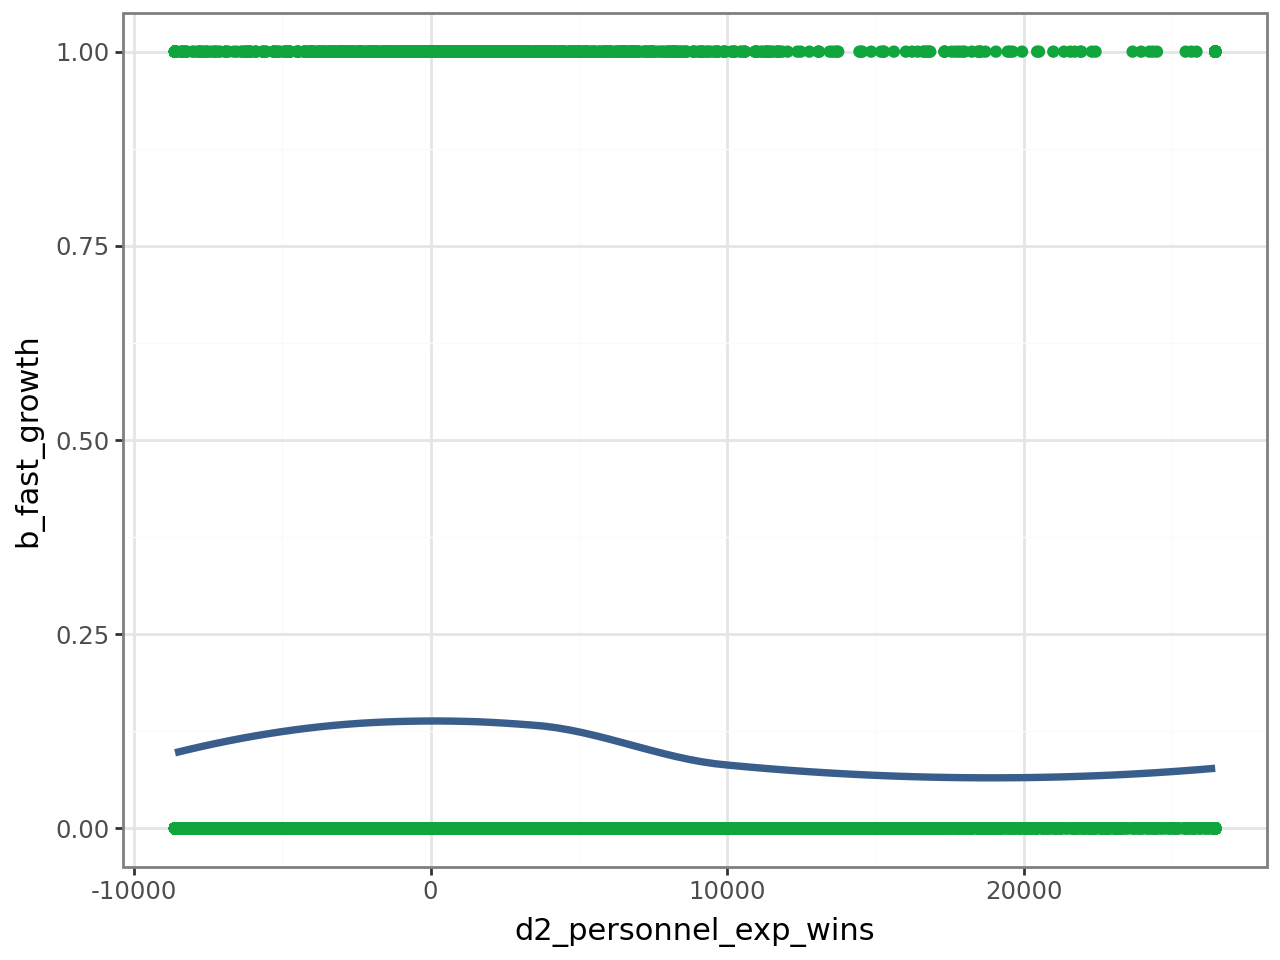

d2_profit_loss_year_wins


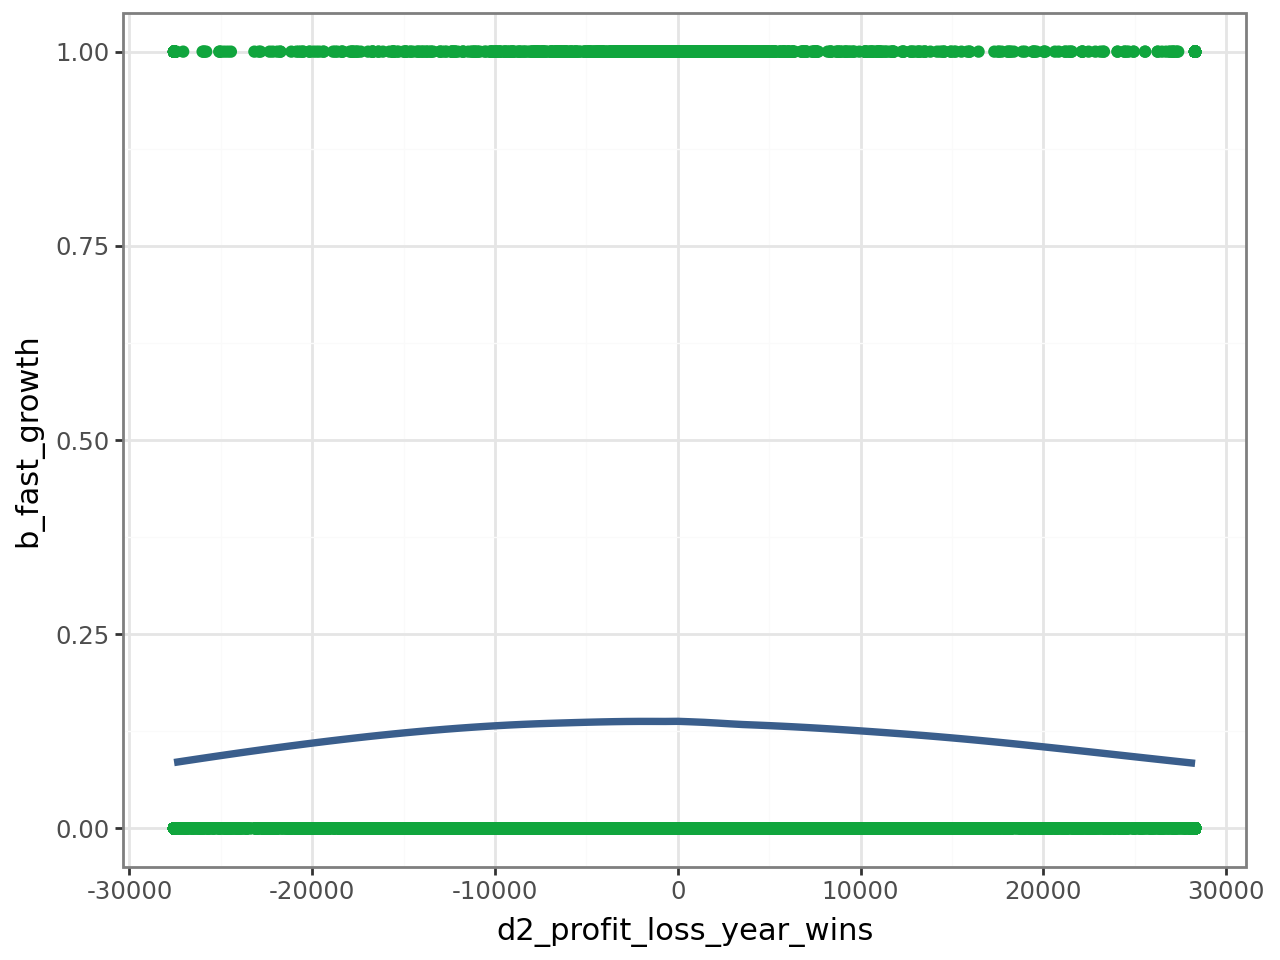

extra_exp_pl


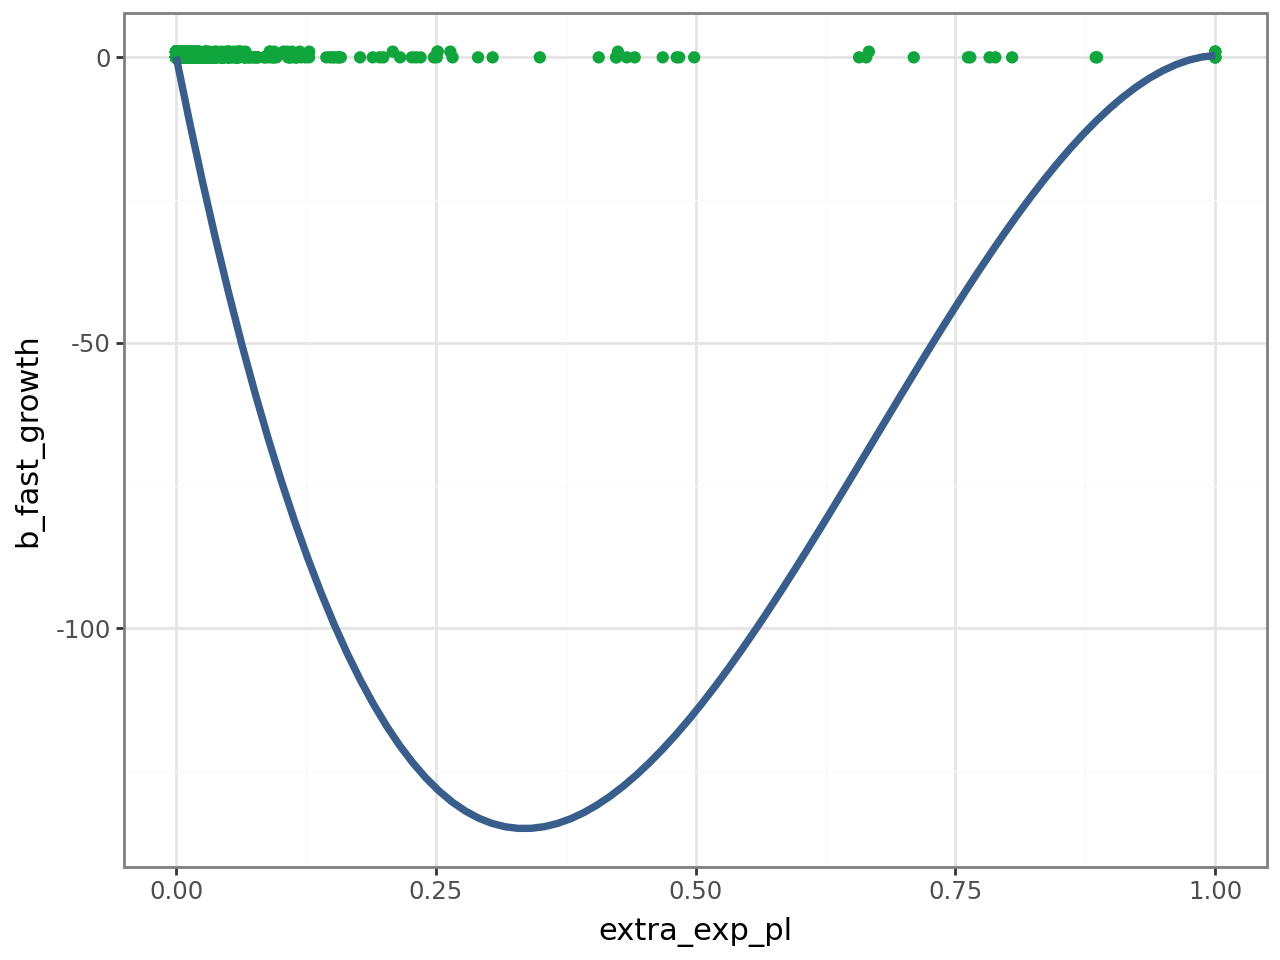

extra_exp_wins


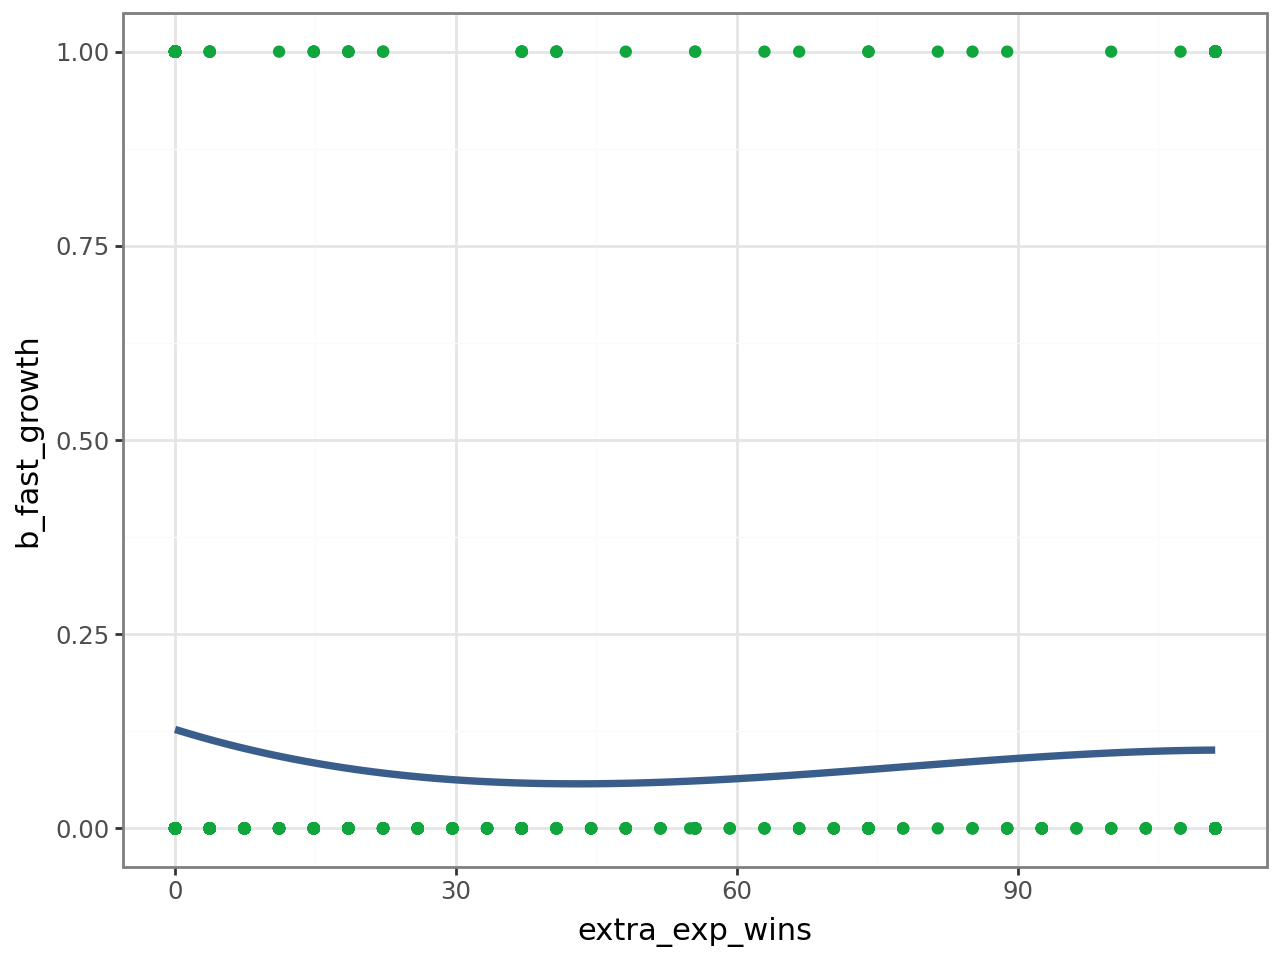

extra_inc_pl


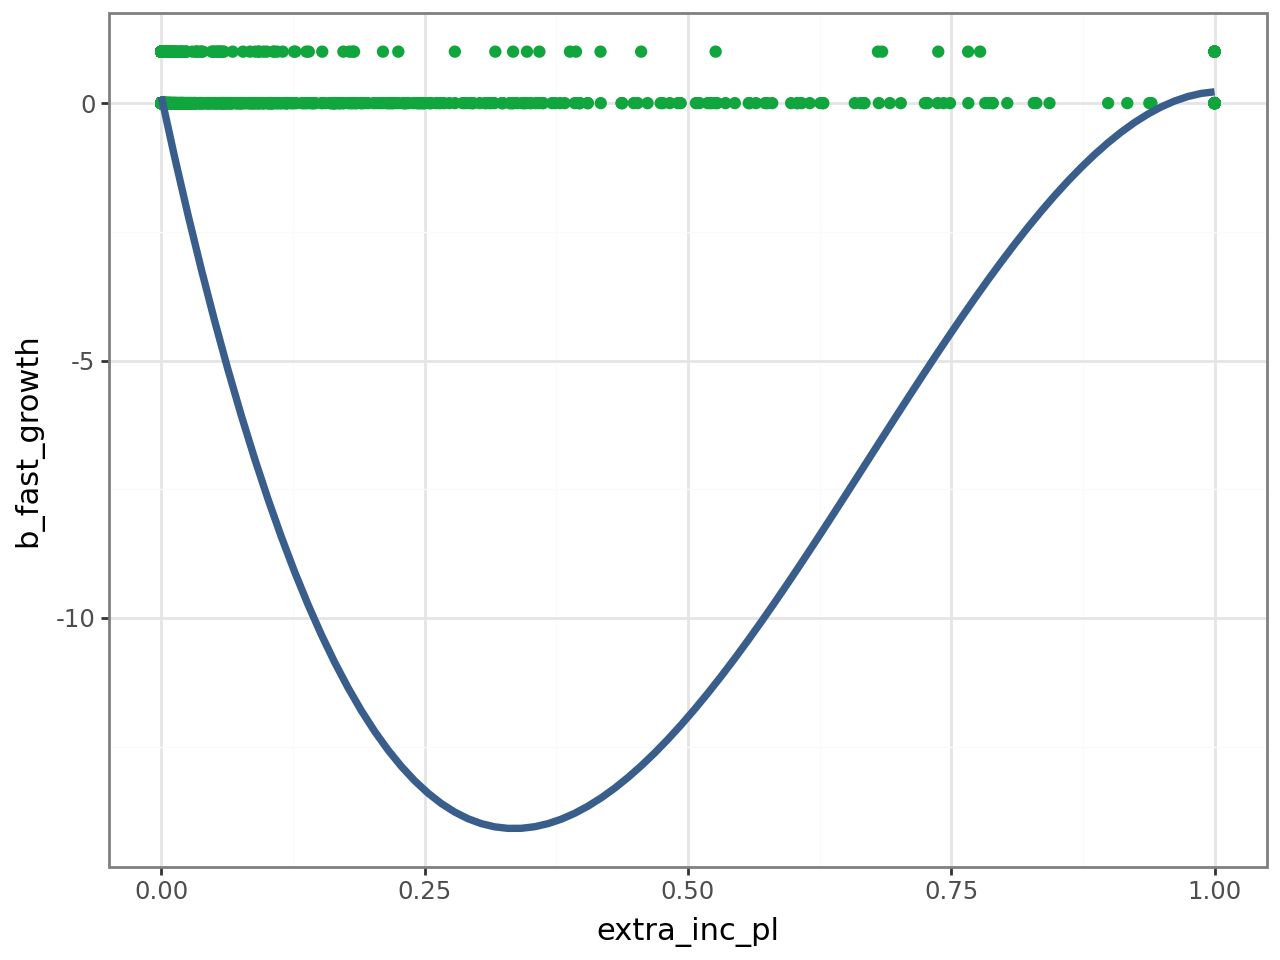

extra_inc_wins


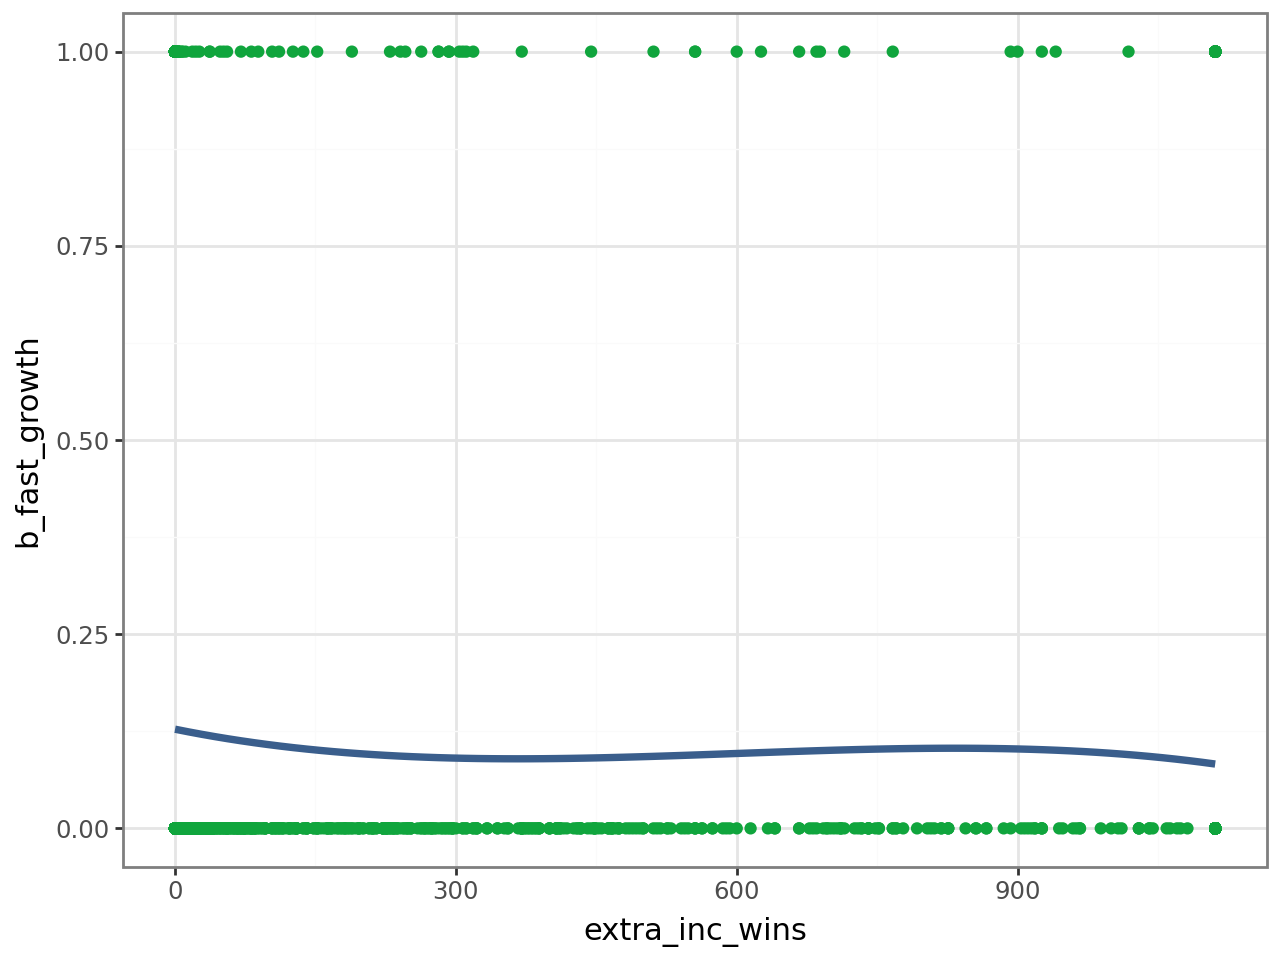

extra_profit_loss_pl


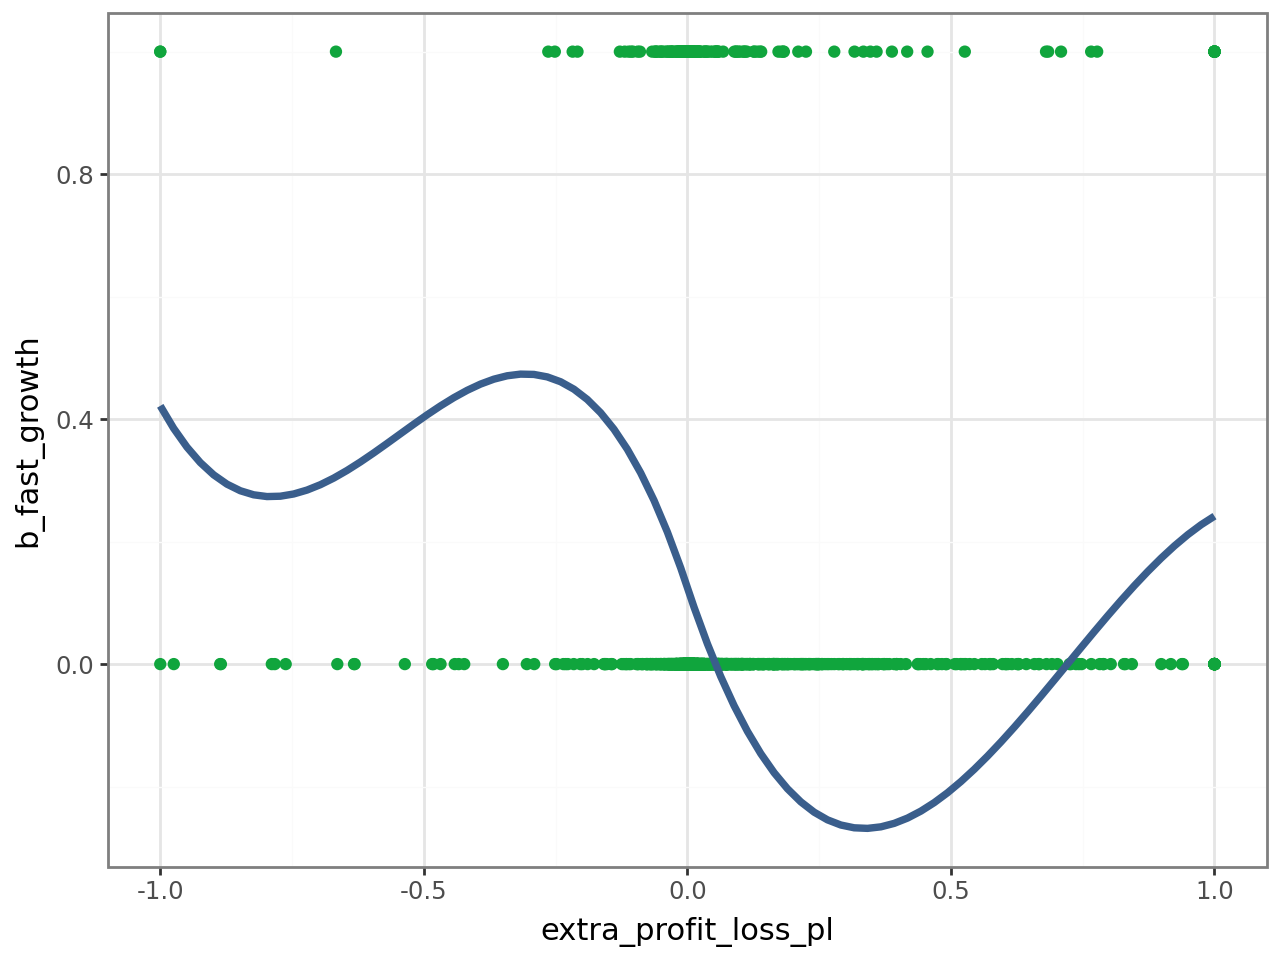

extra_profit_loss_wins


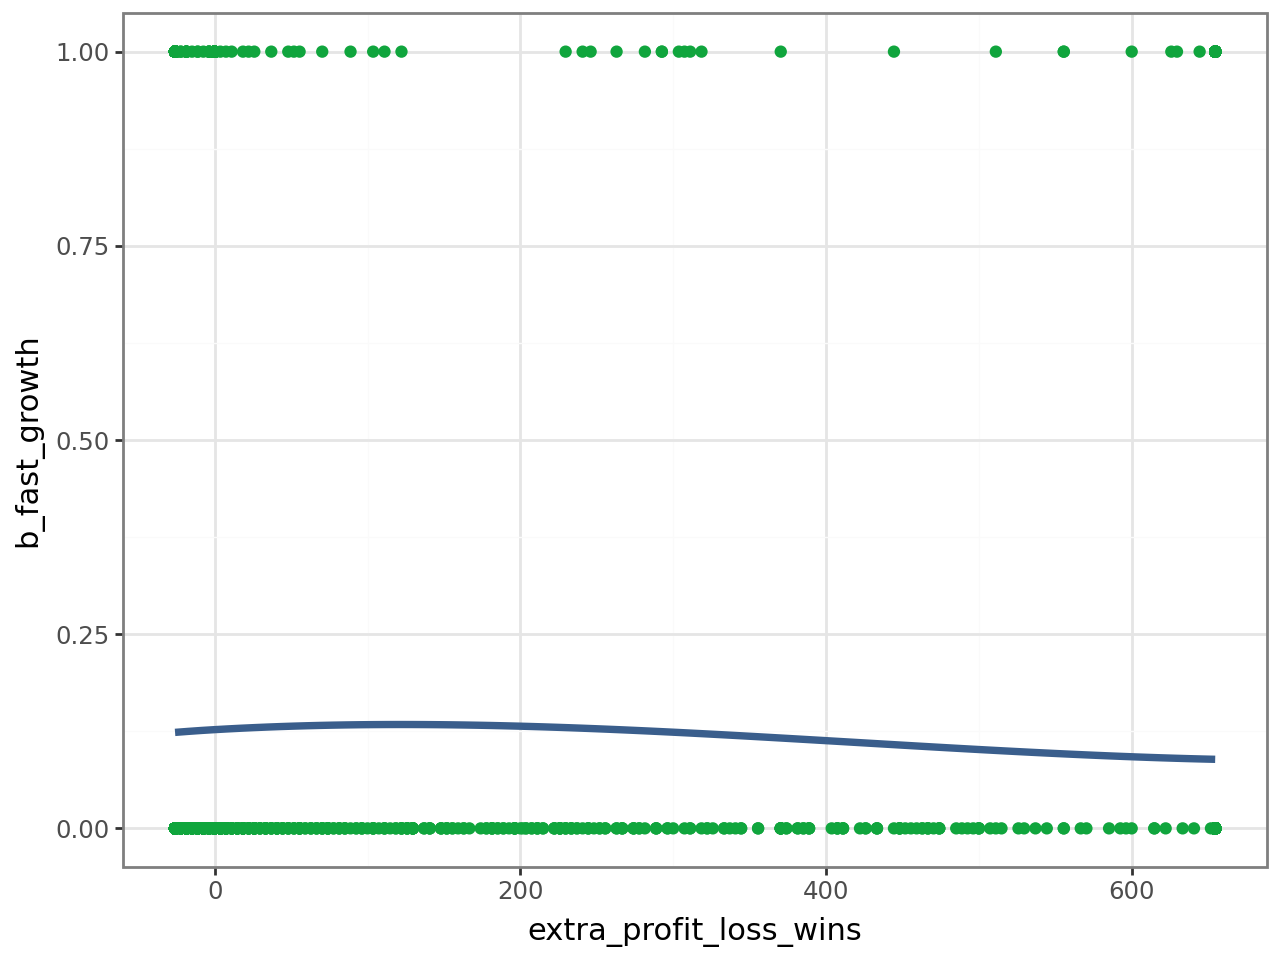

fixed_assets_bs


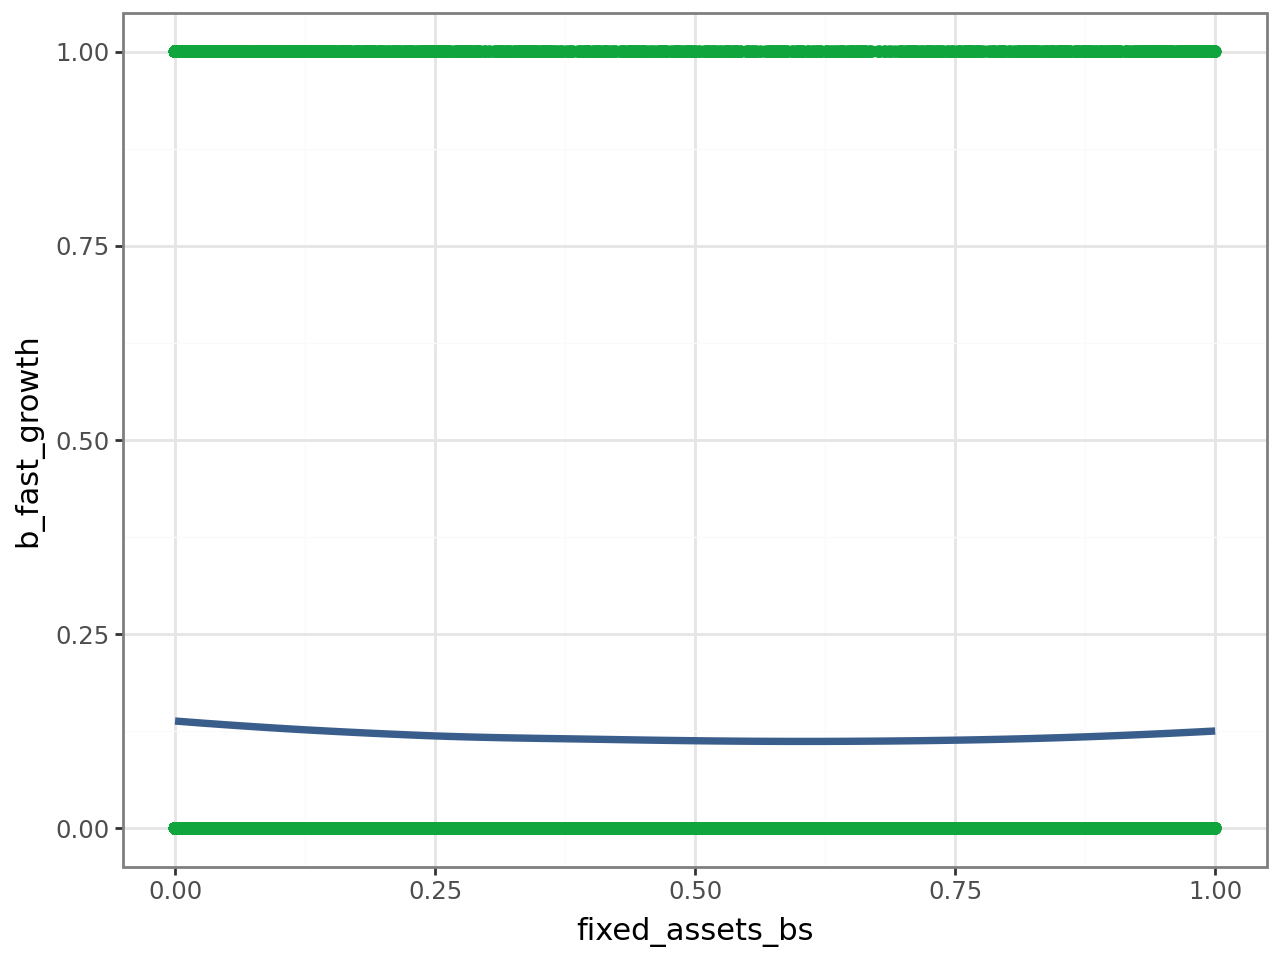

fixed_assets_wins


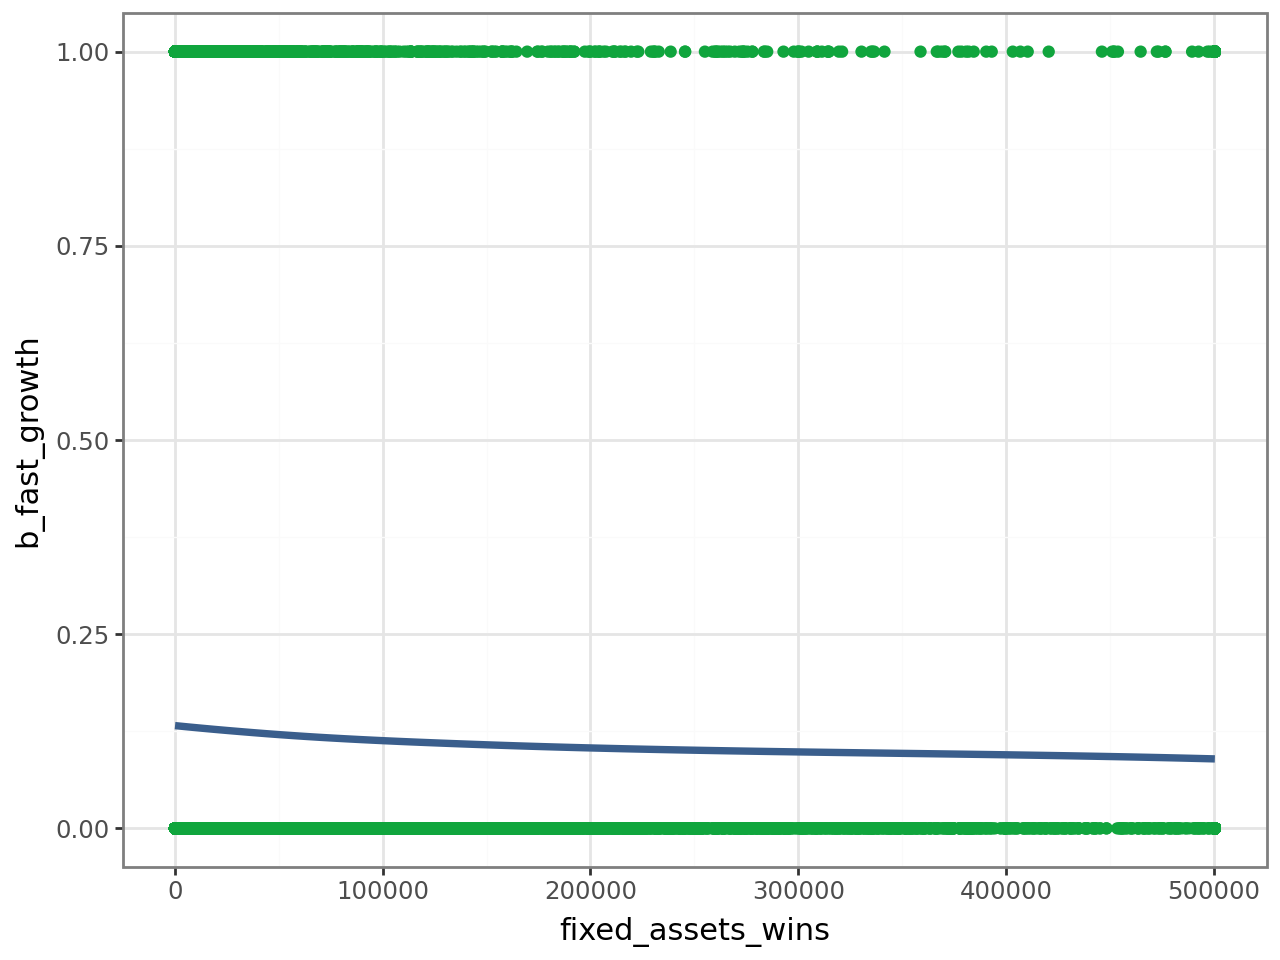

inc_bef_tax_pl


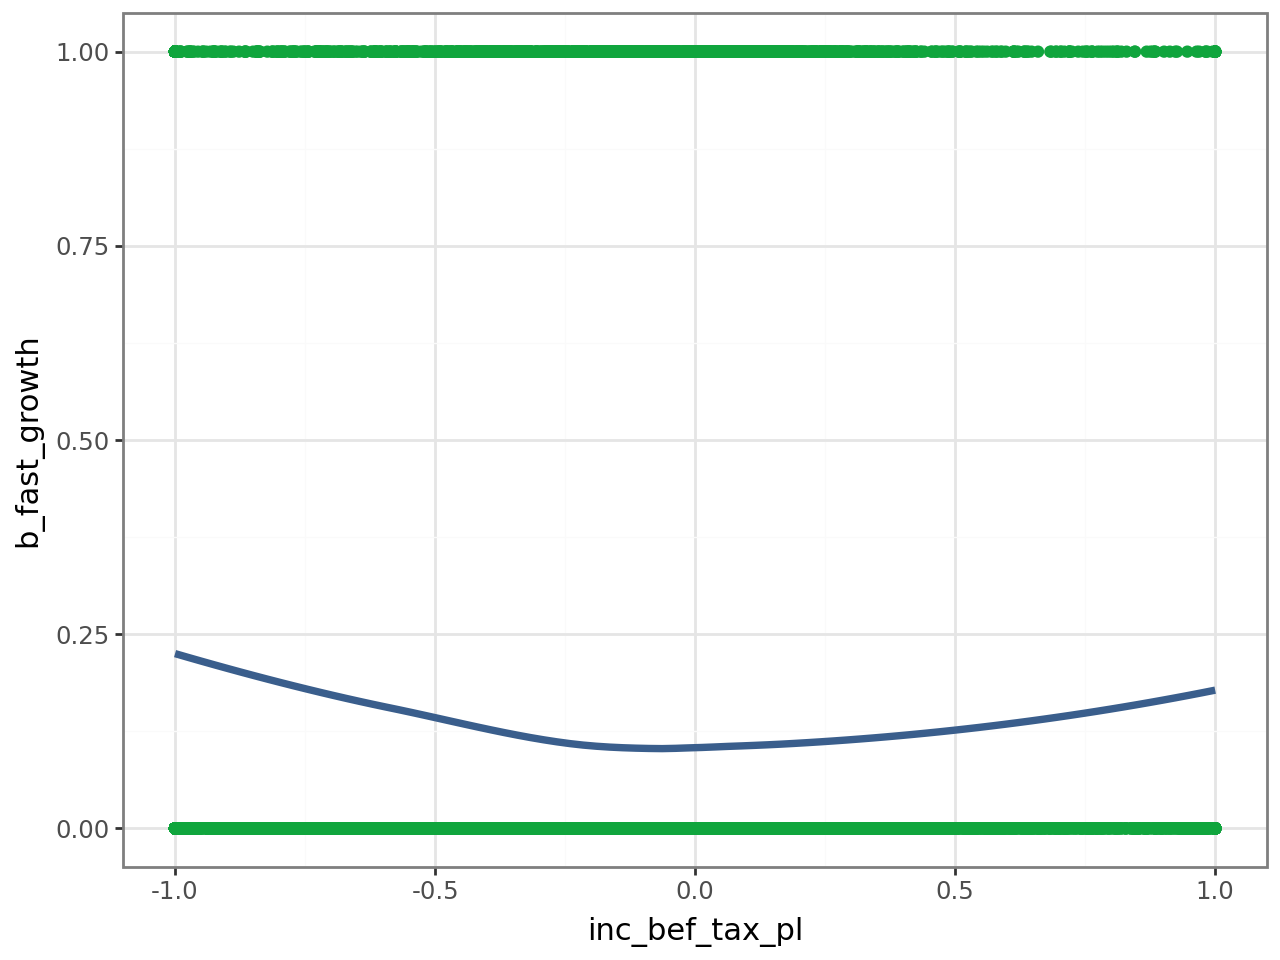

inc_bef_tax_wins


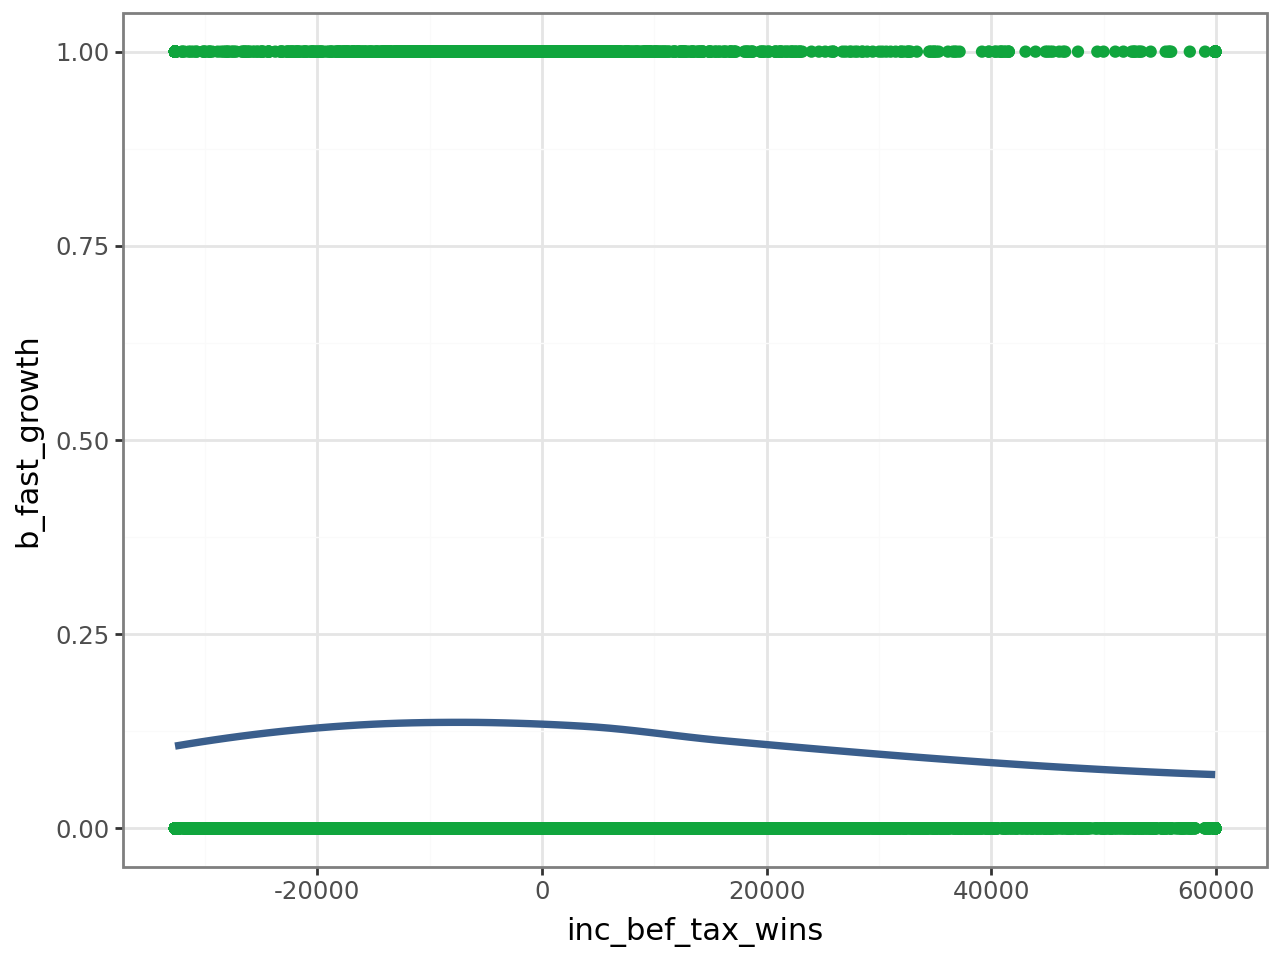

inoffice_days_wins


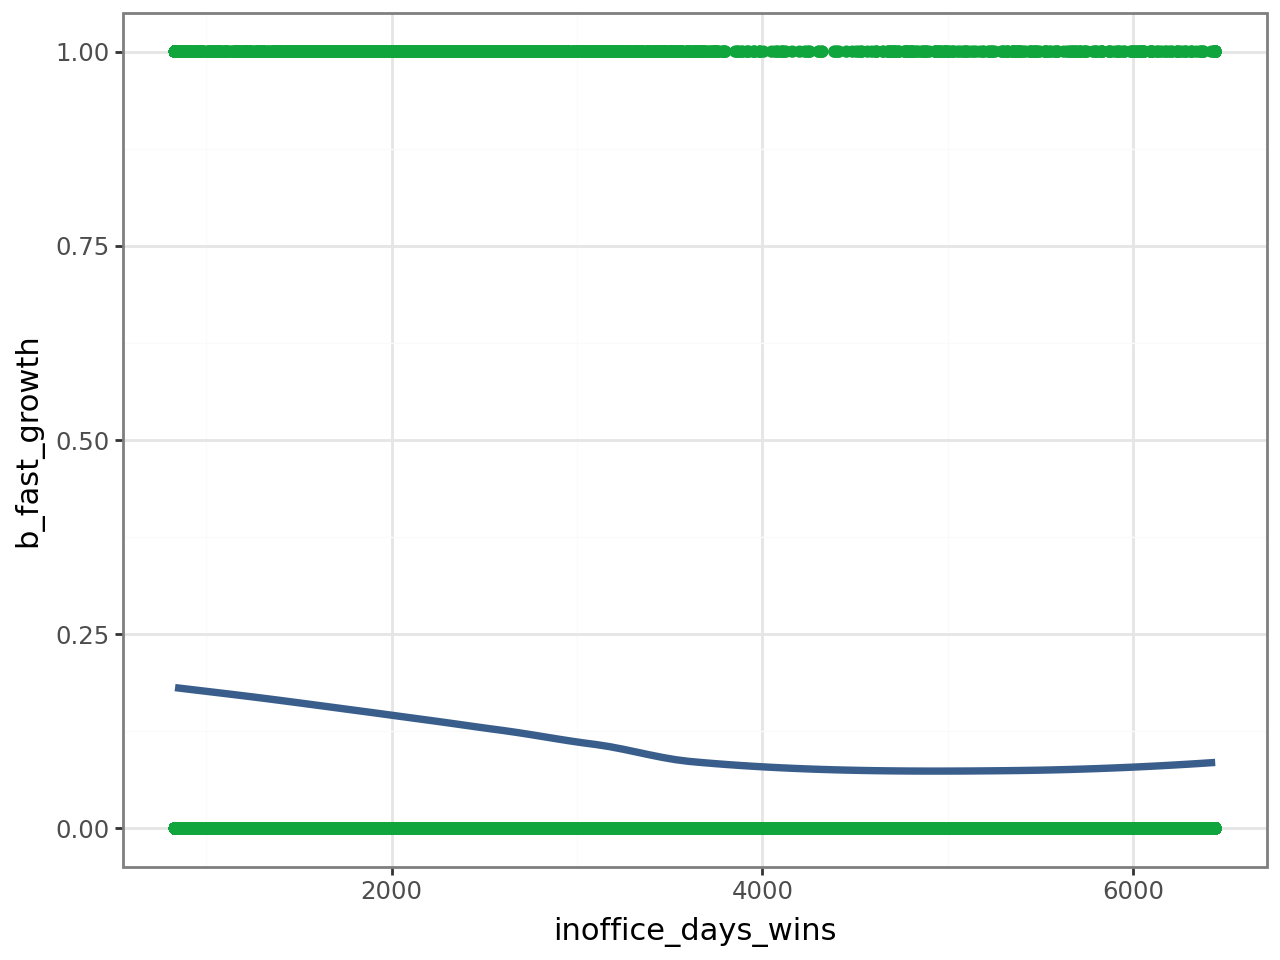

intang_assets_bs


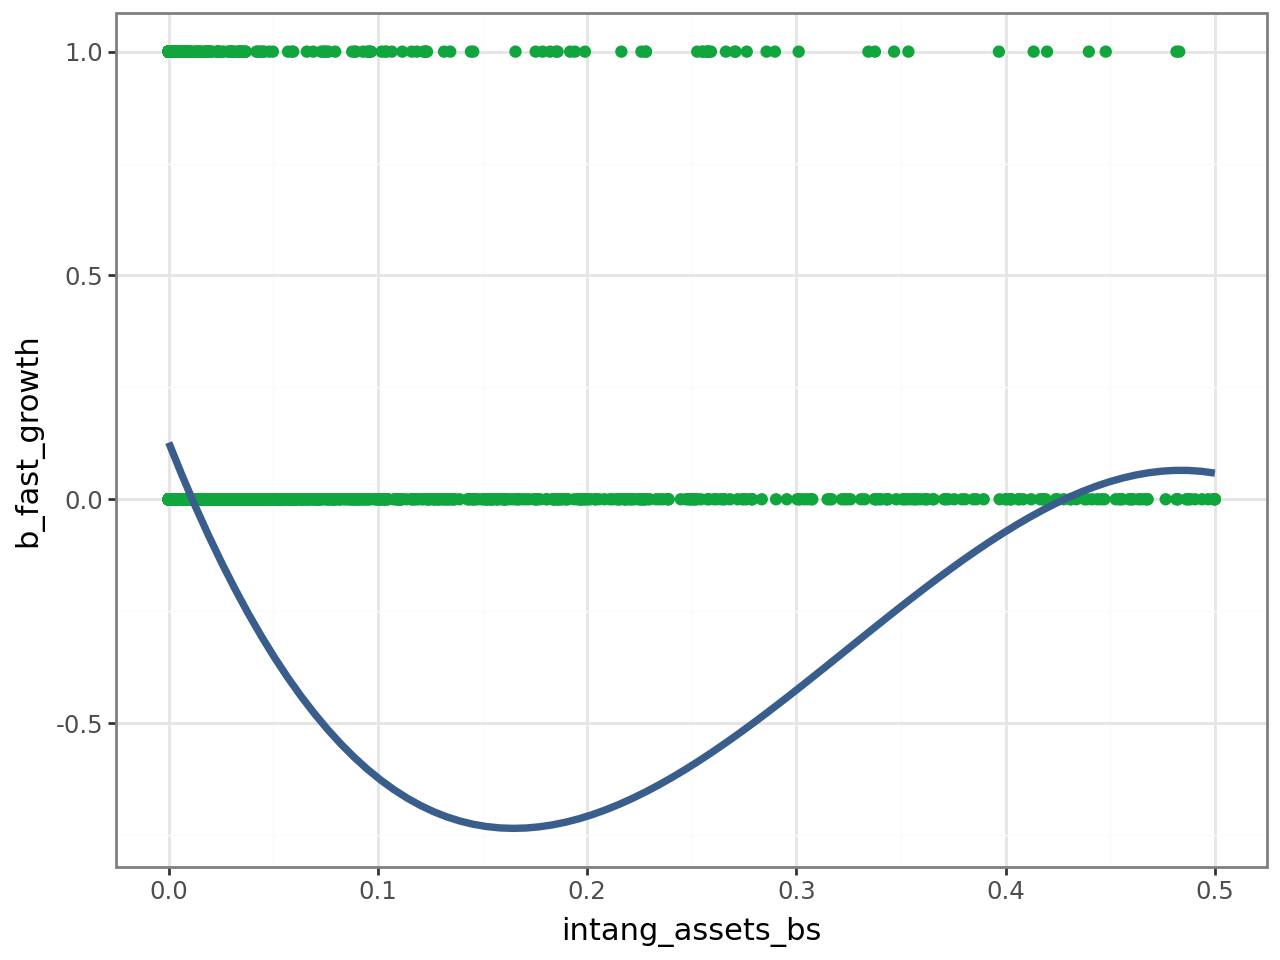

intang_assets_wins


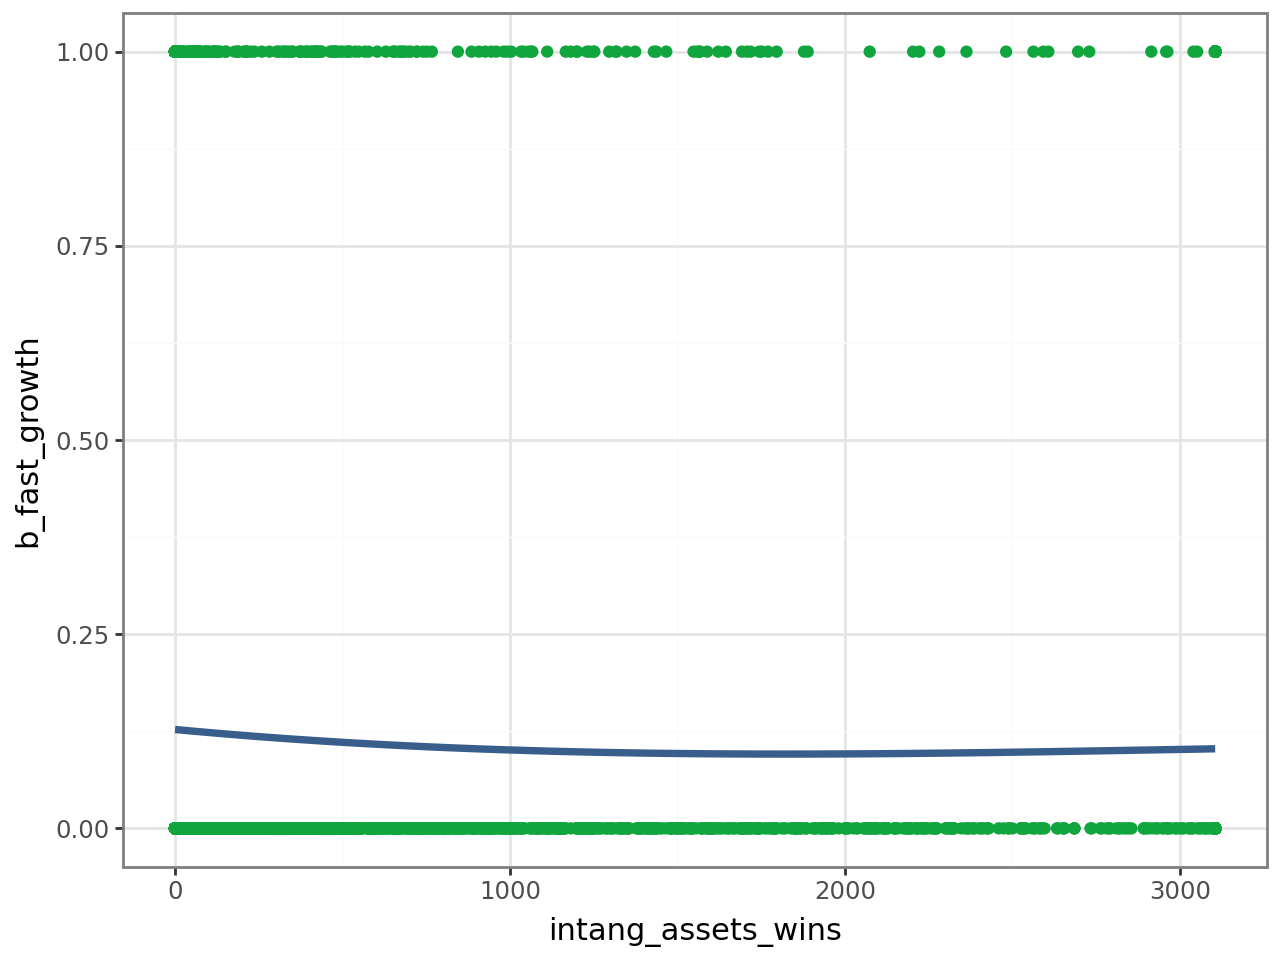

inventories_pl


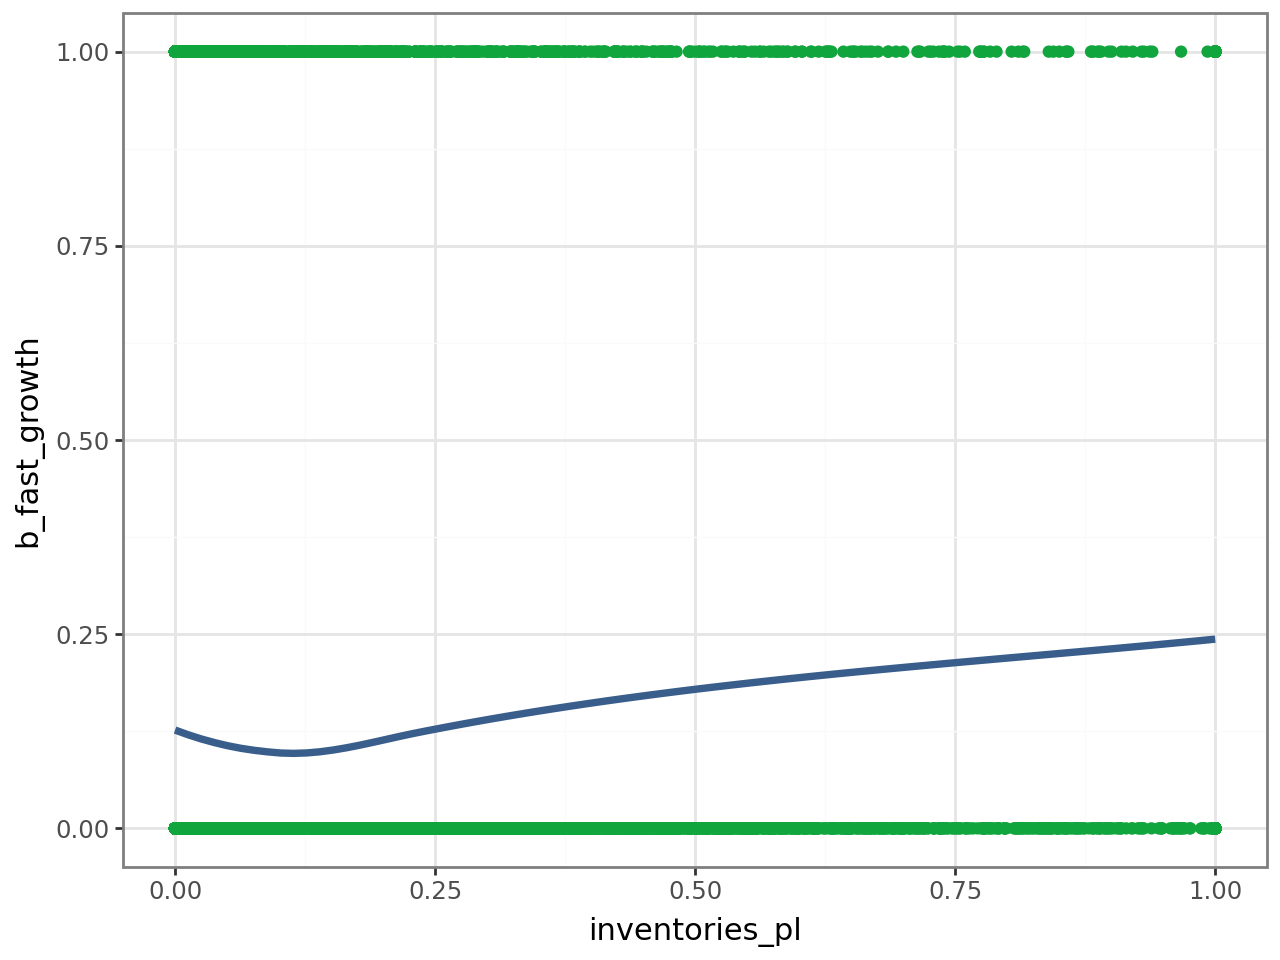

inventories_wins


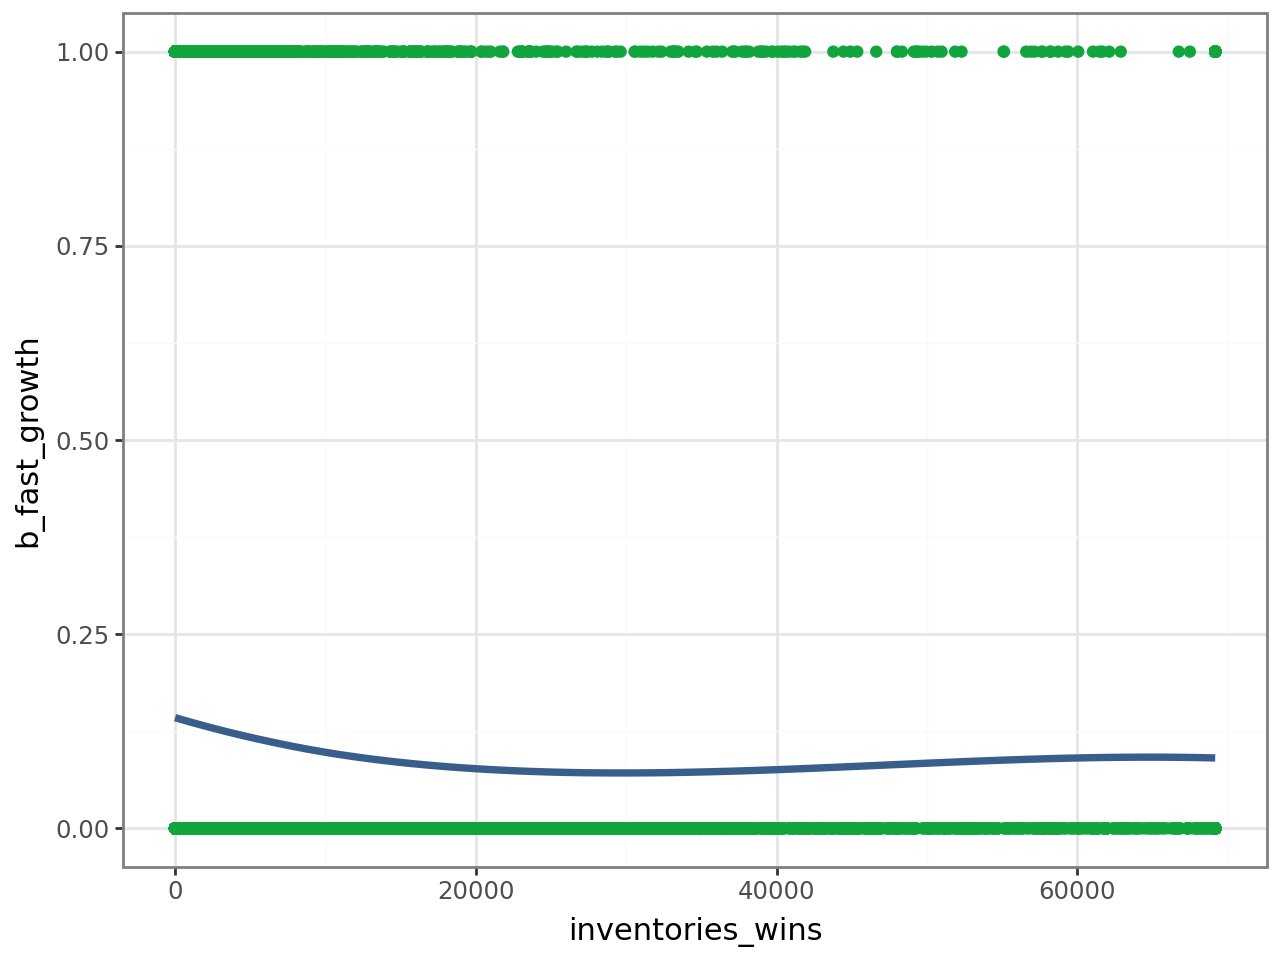

labor_avg_mod_wins


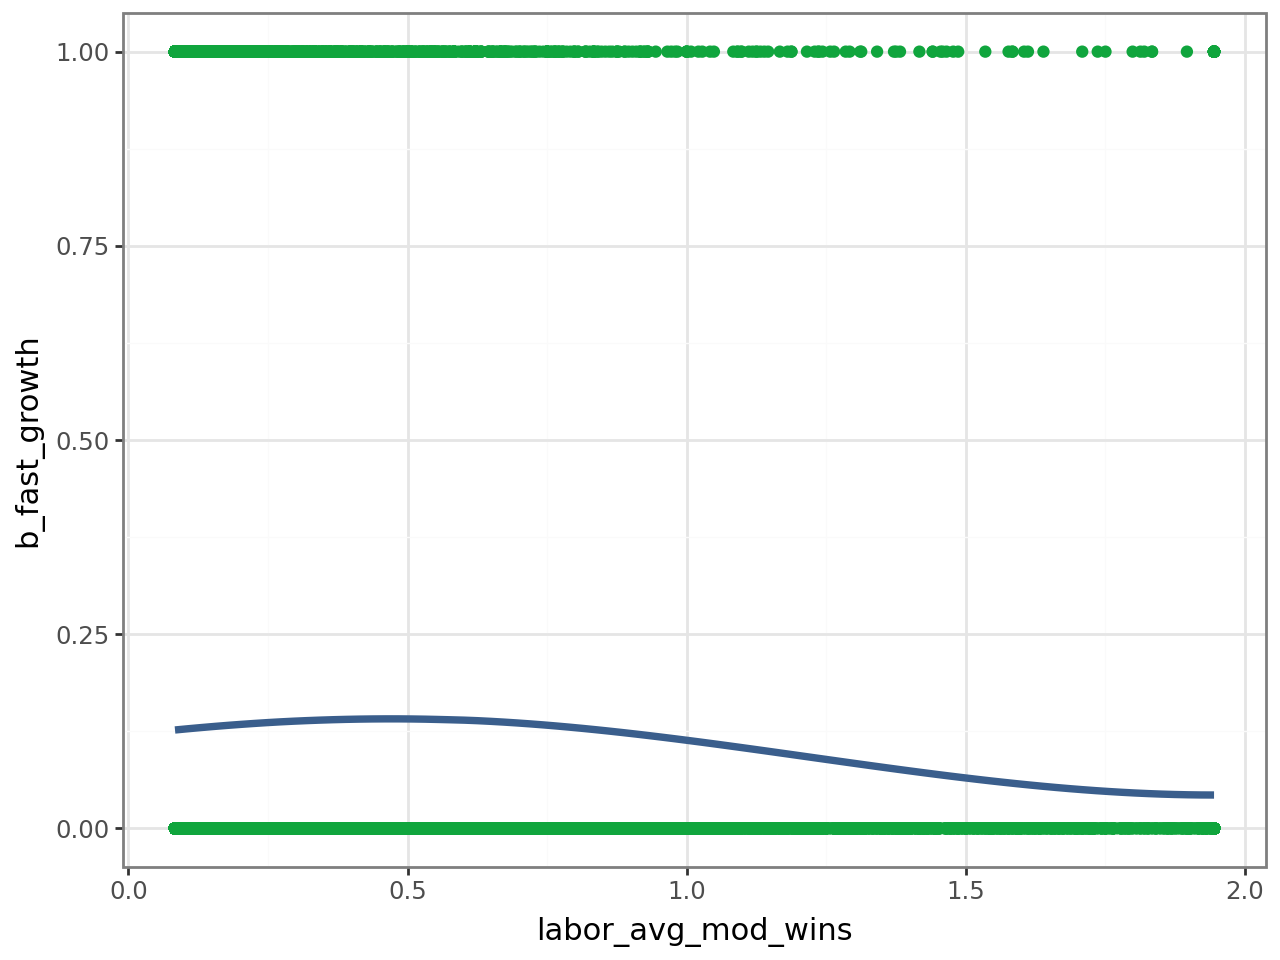

liq_assets_bs


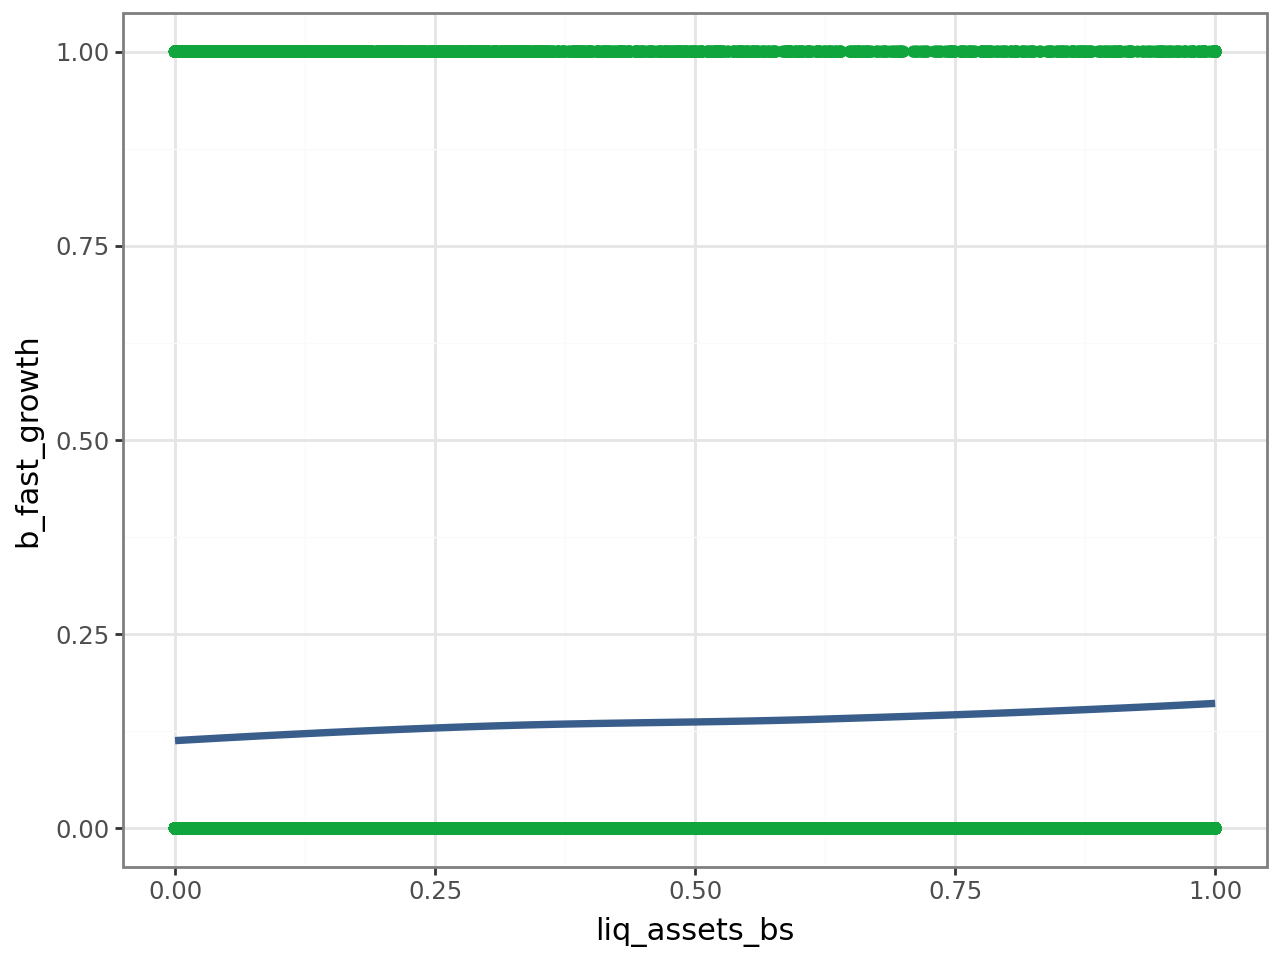

liq_assets_wins


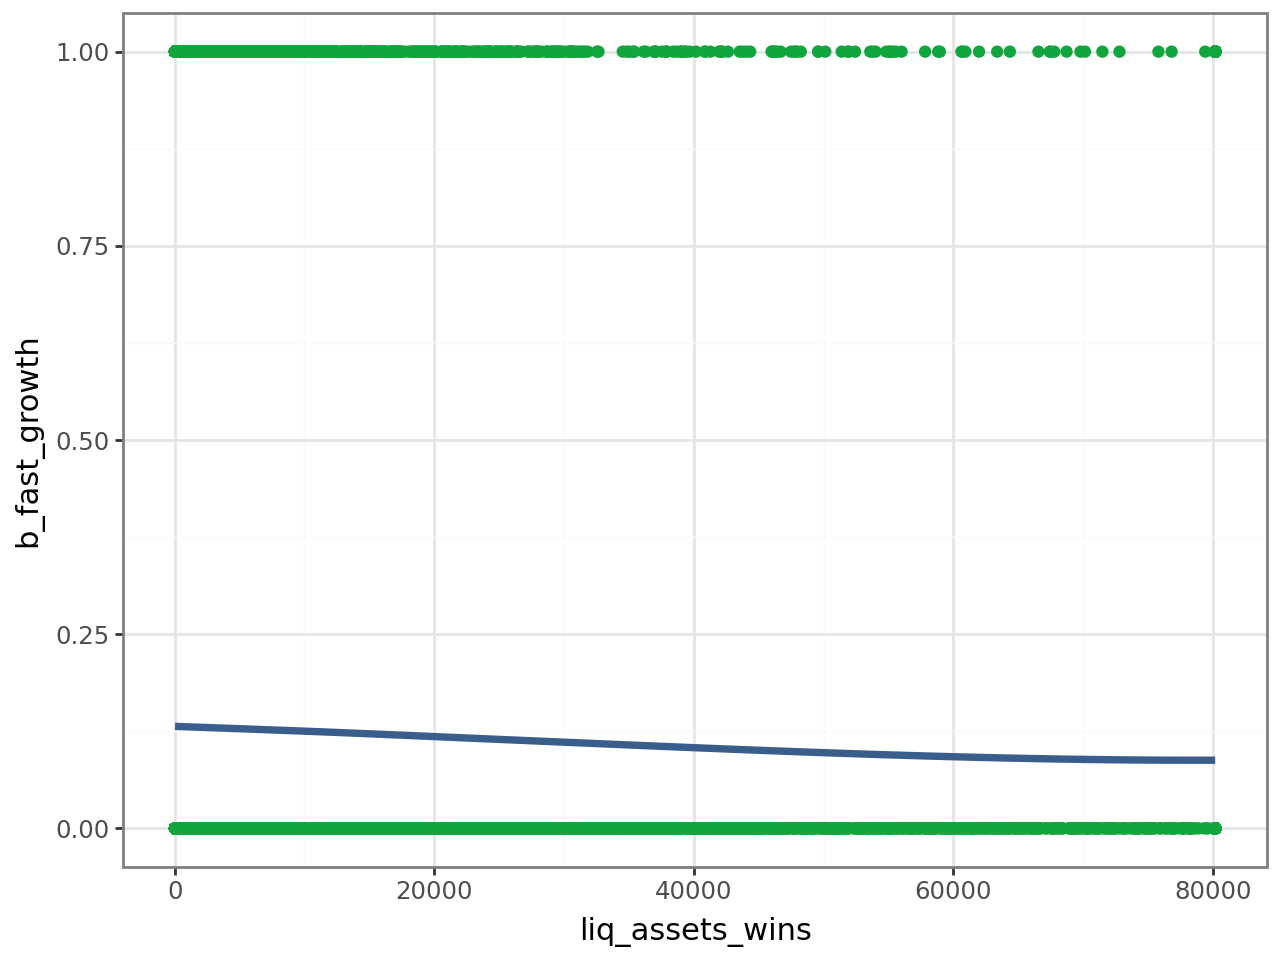

ln_curr_assets_wins


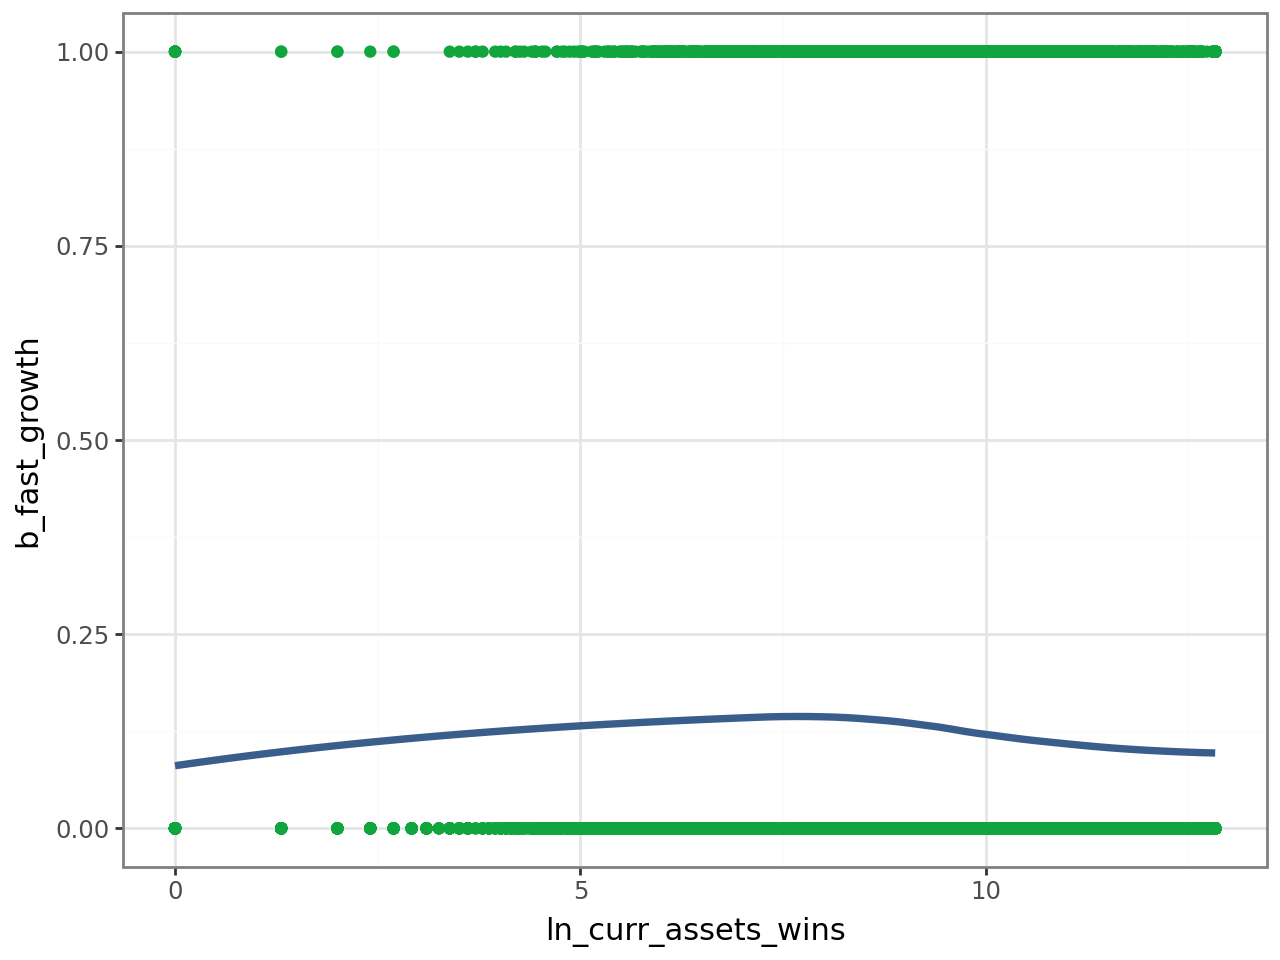

ln_fixed_assets_wins


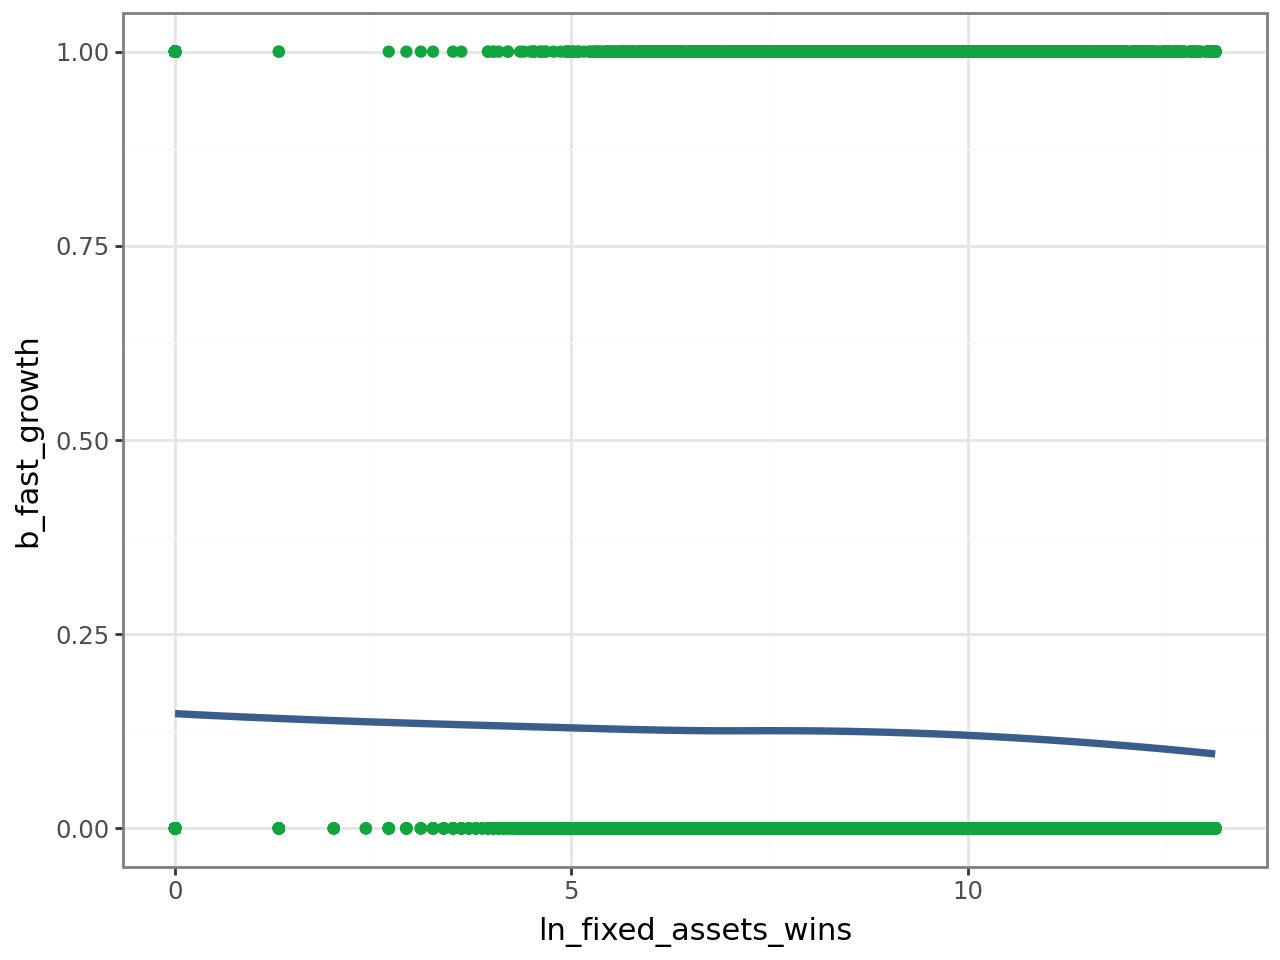

ln_intang_assets_wins


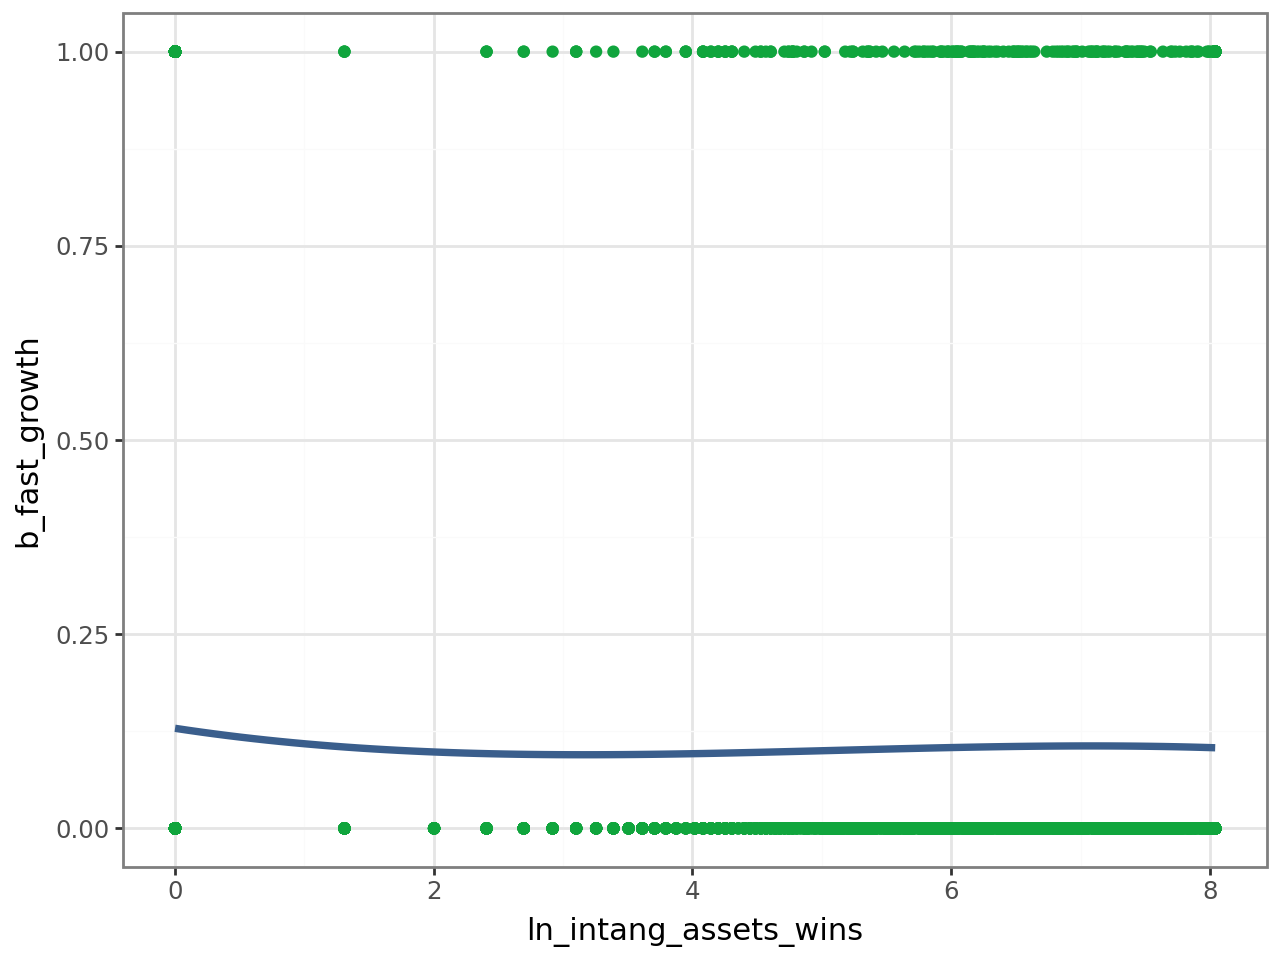

ln_sales_mil_wins


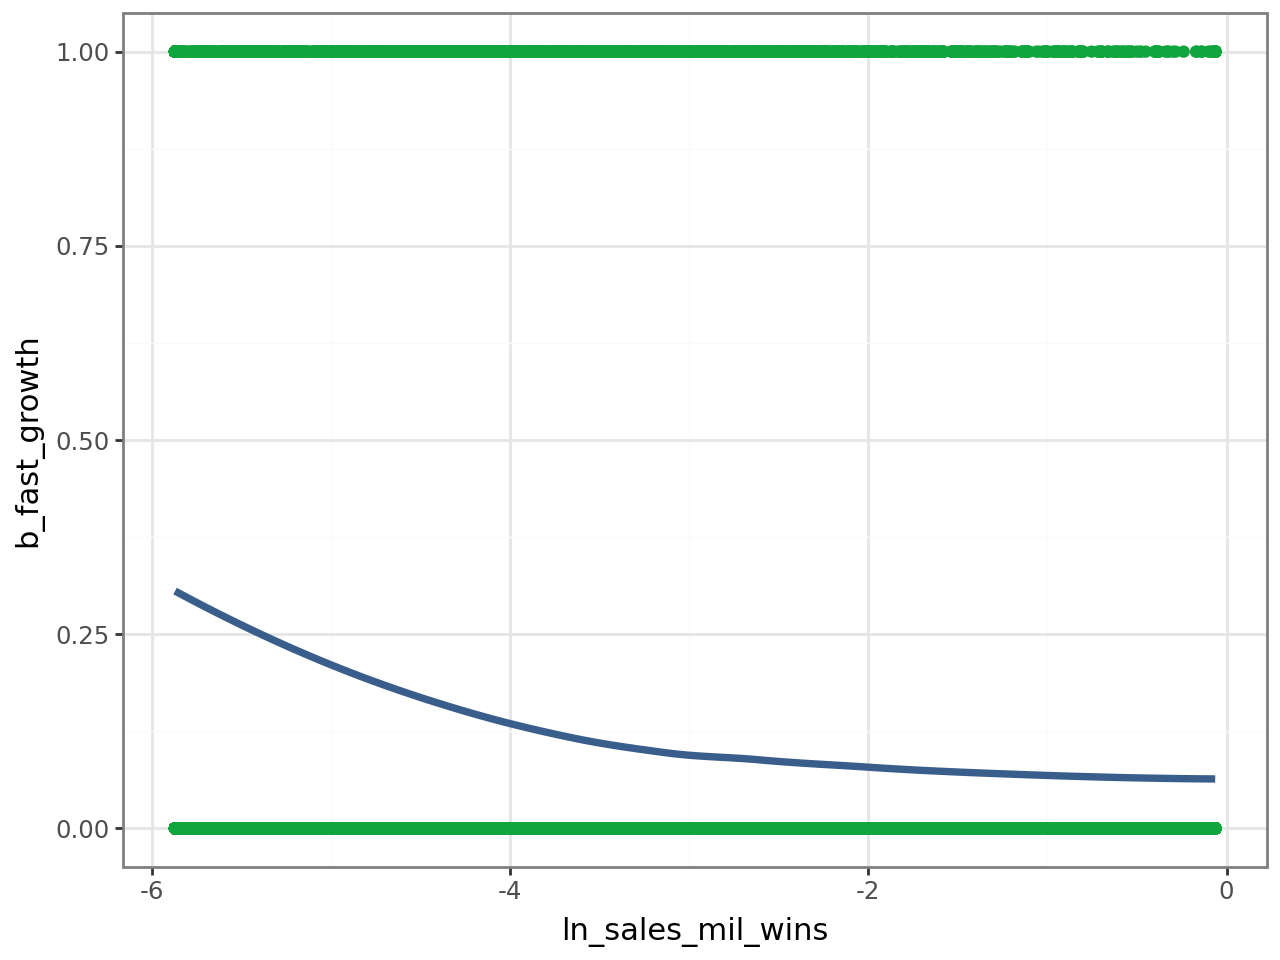

ln_sales_wins


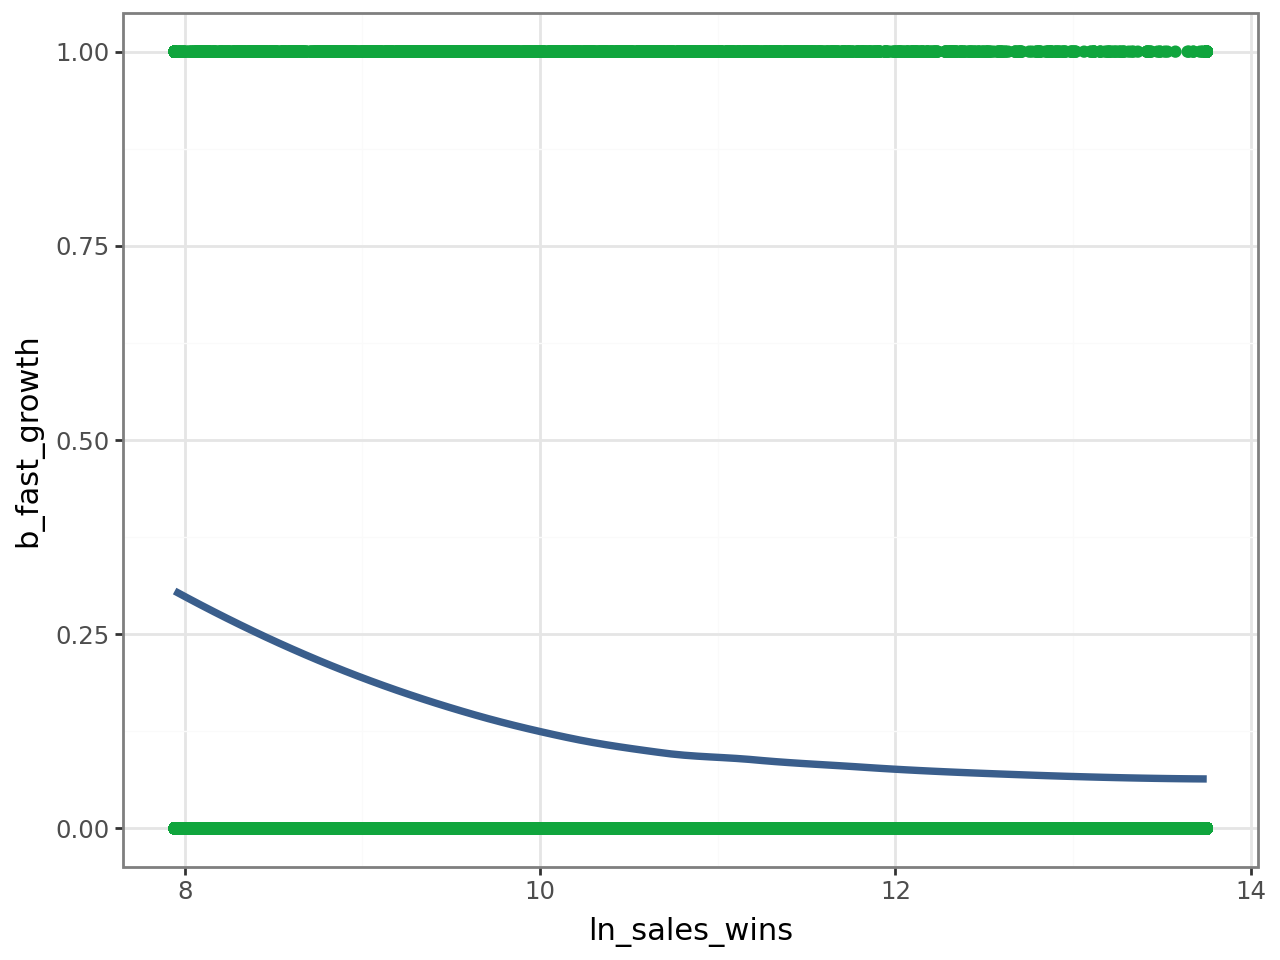

ln_total_assets_wins


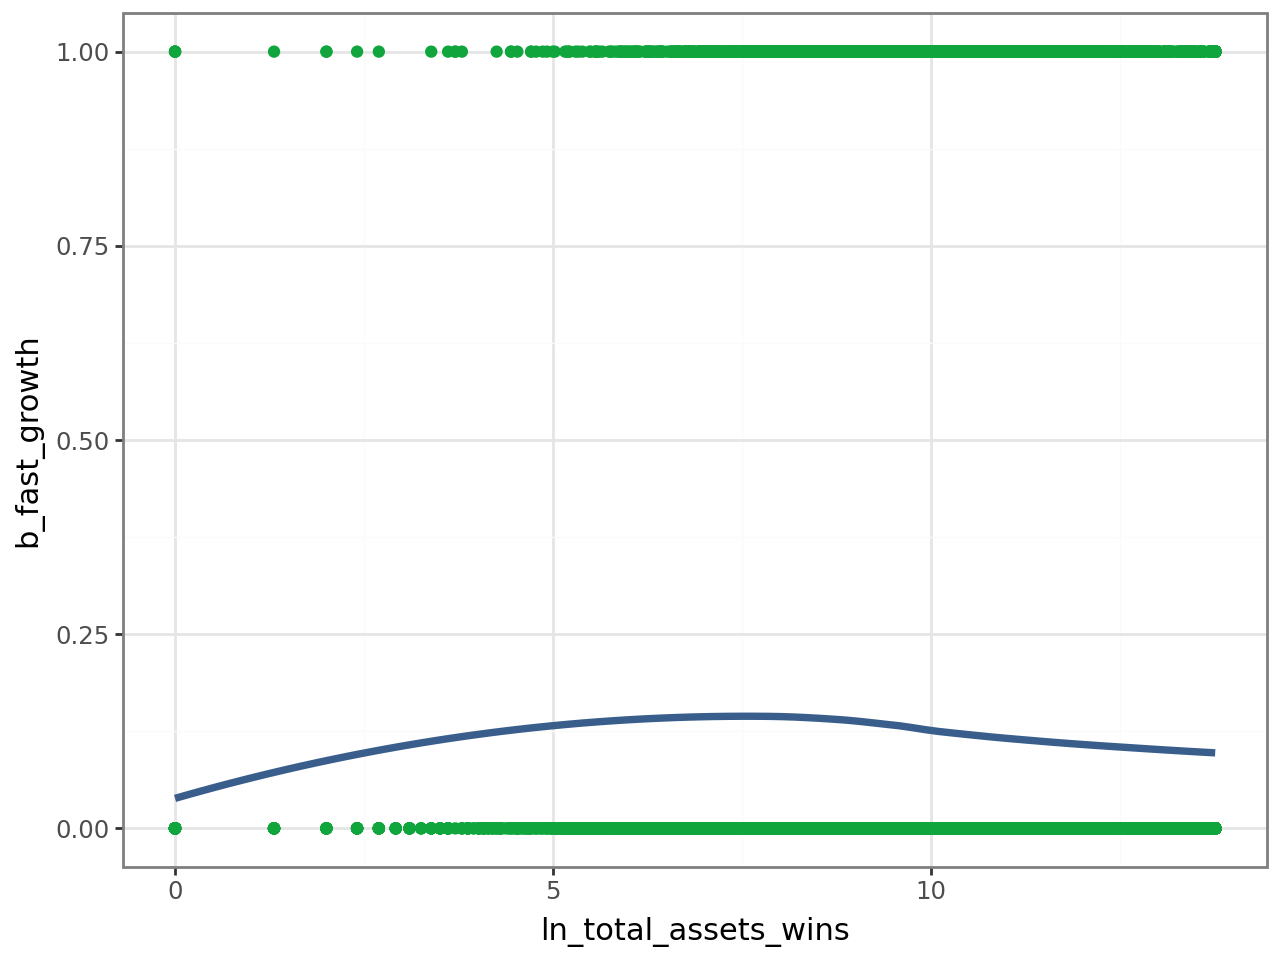

material_exp_pl


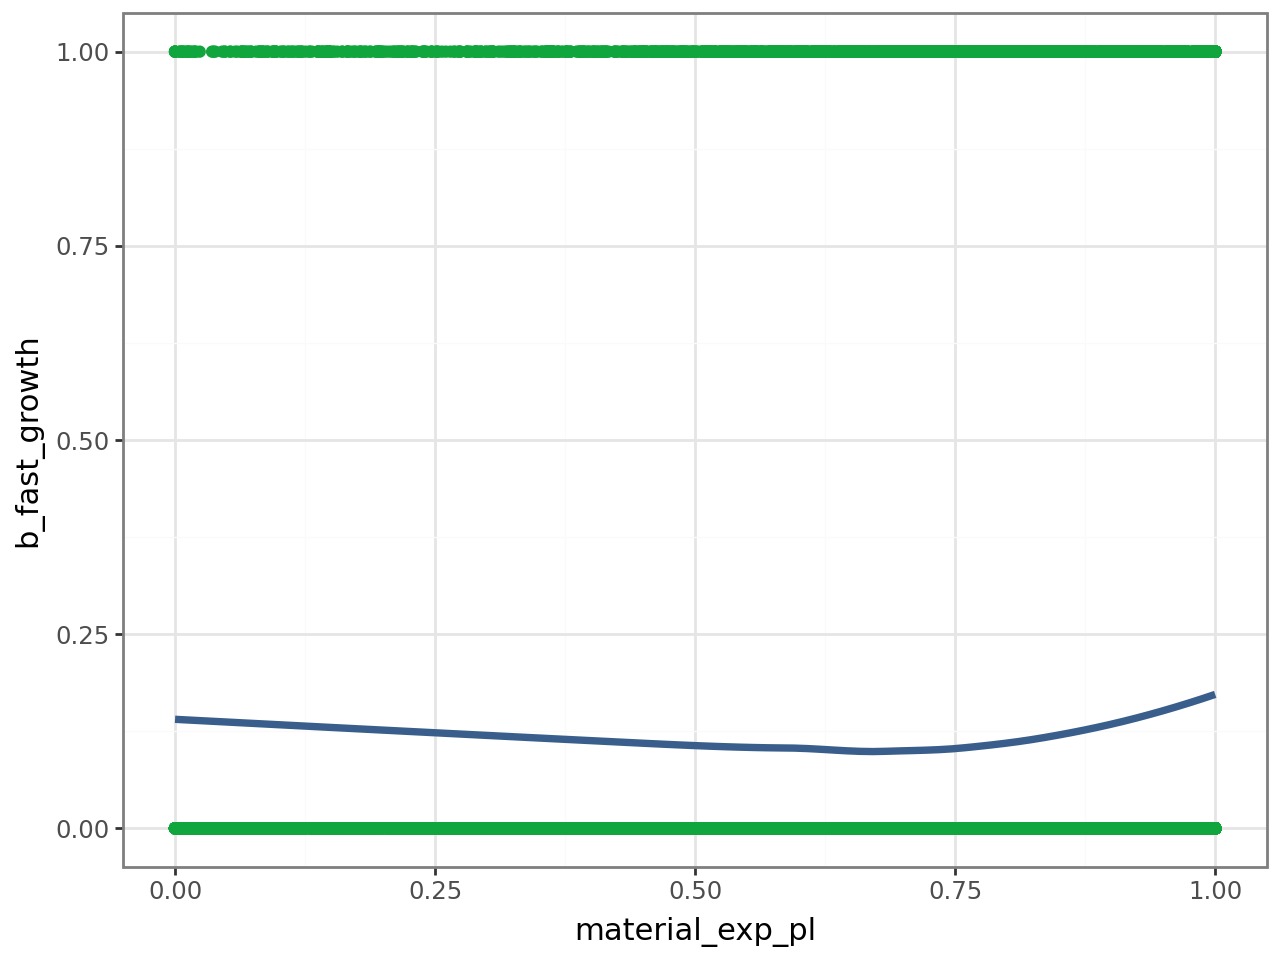

material_exp_wins


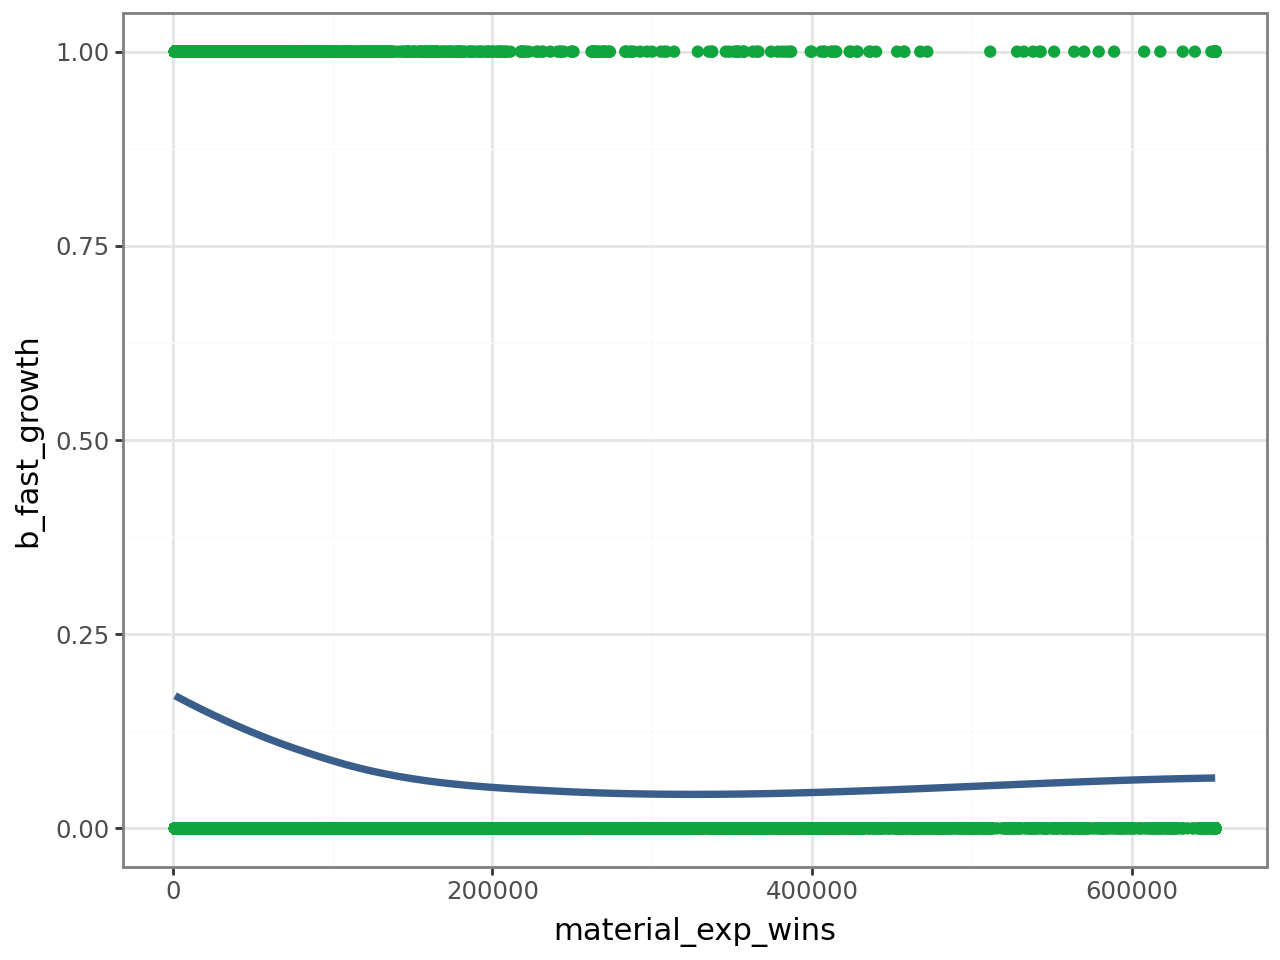

personnel_exp_pl


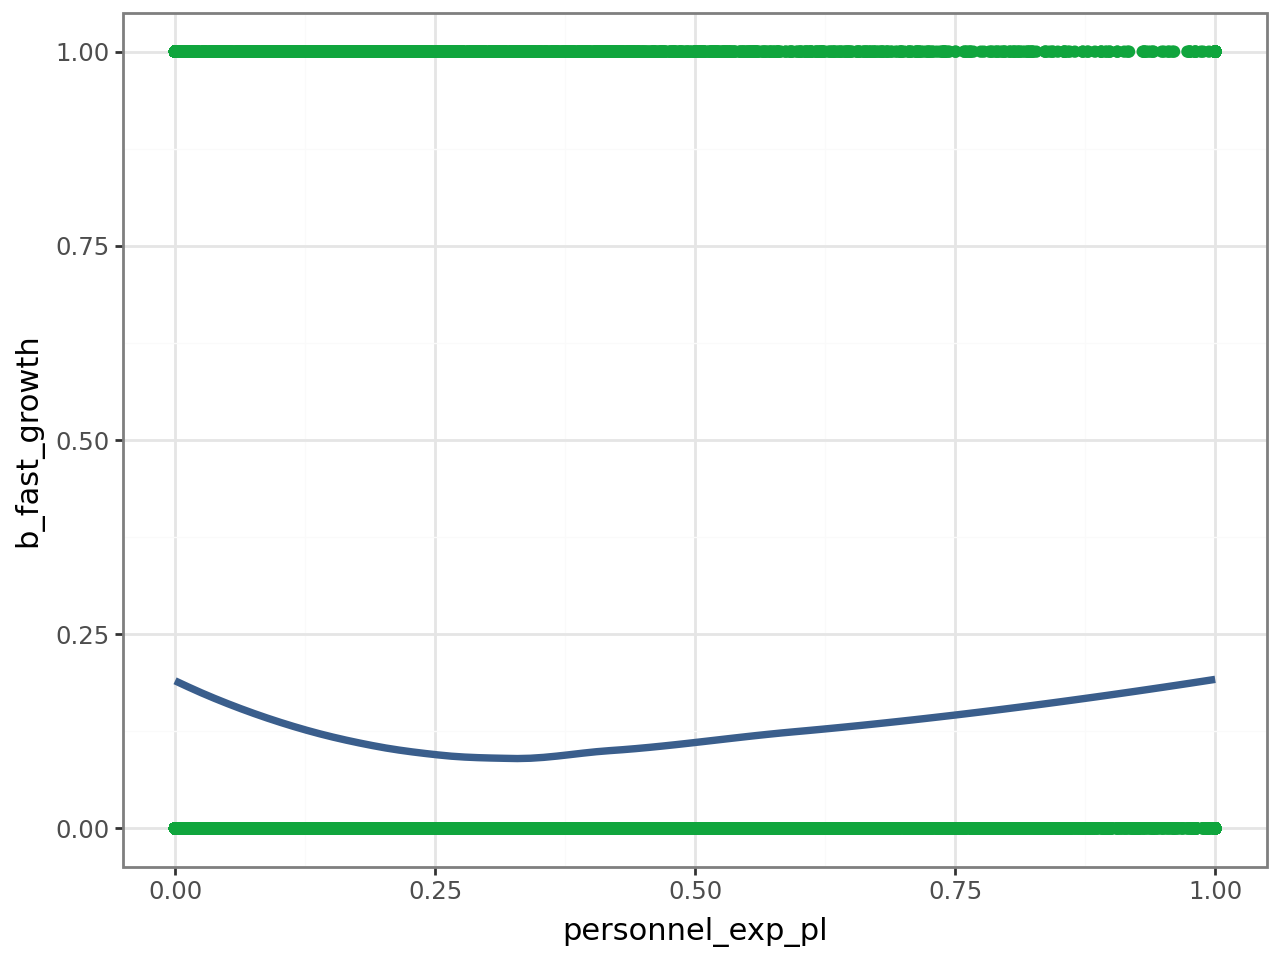

personnel_exp_wins


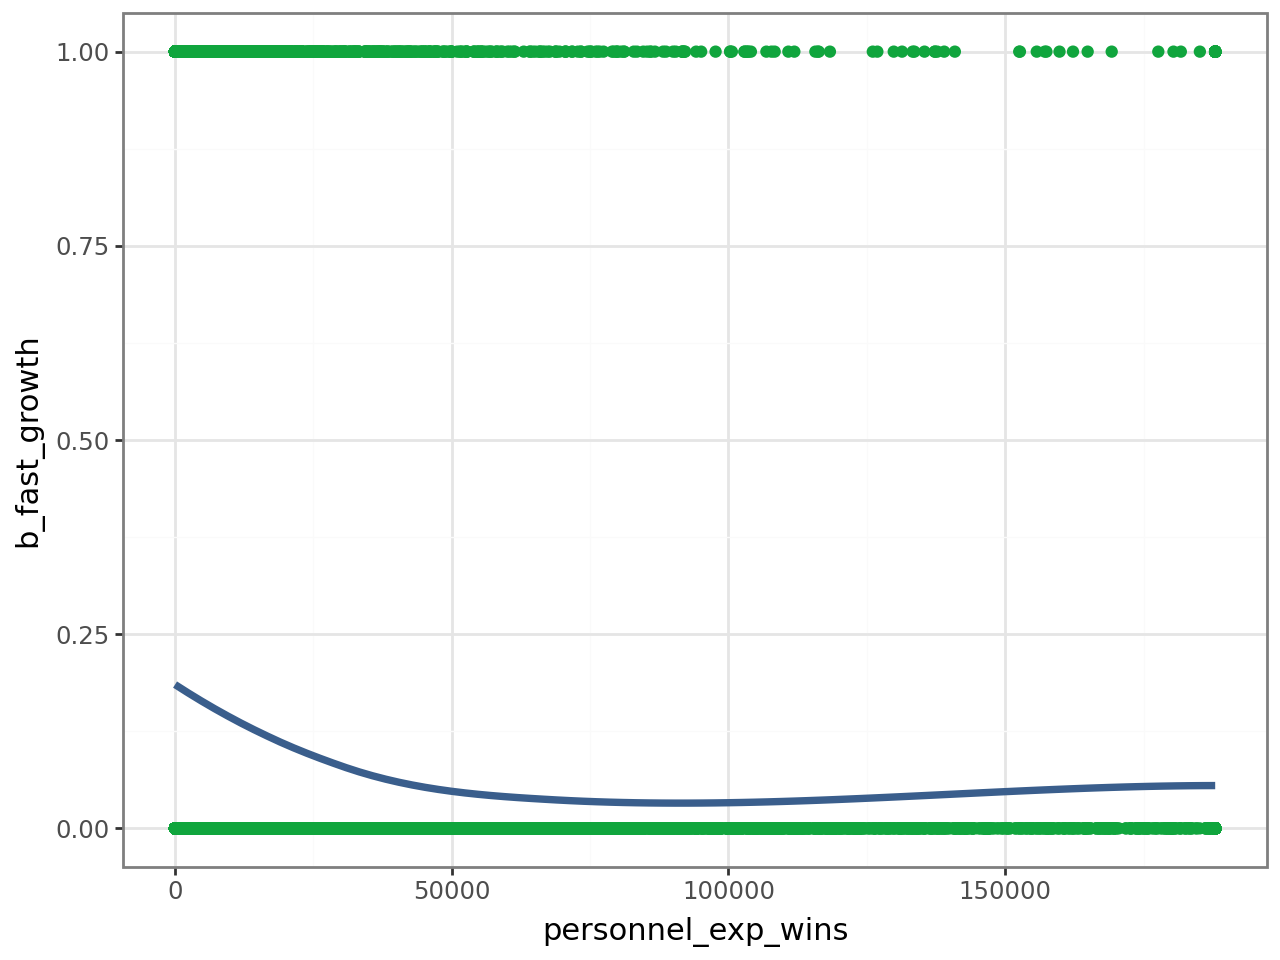

profit_loss_year_pl


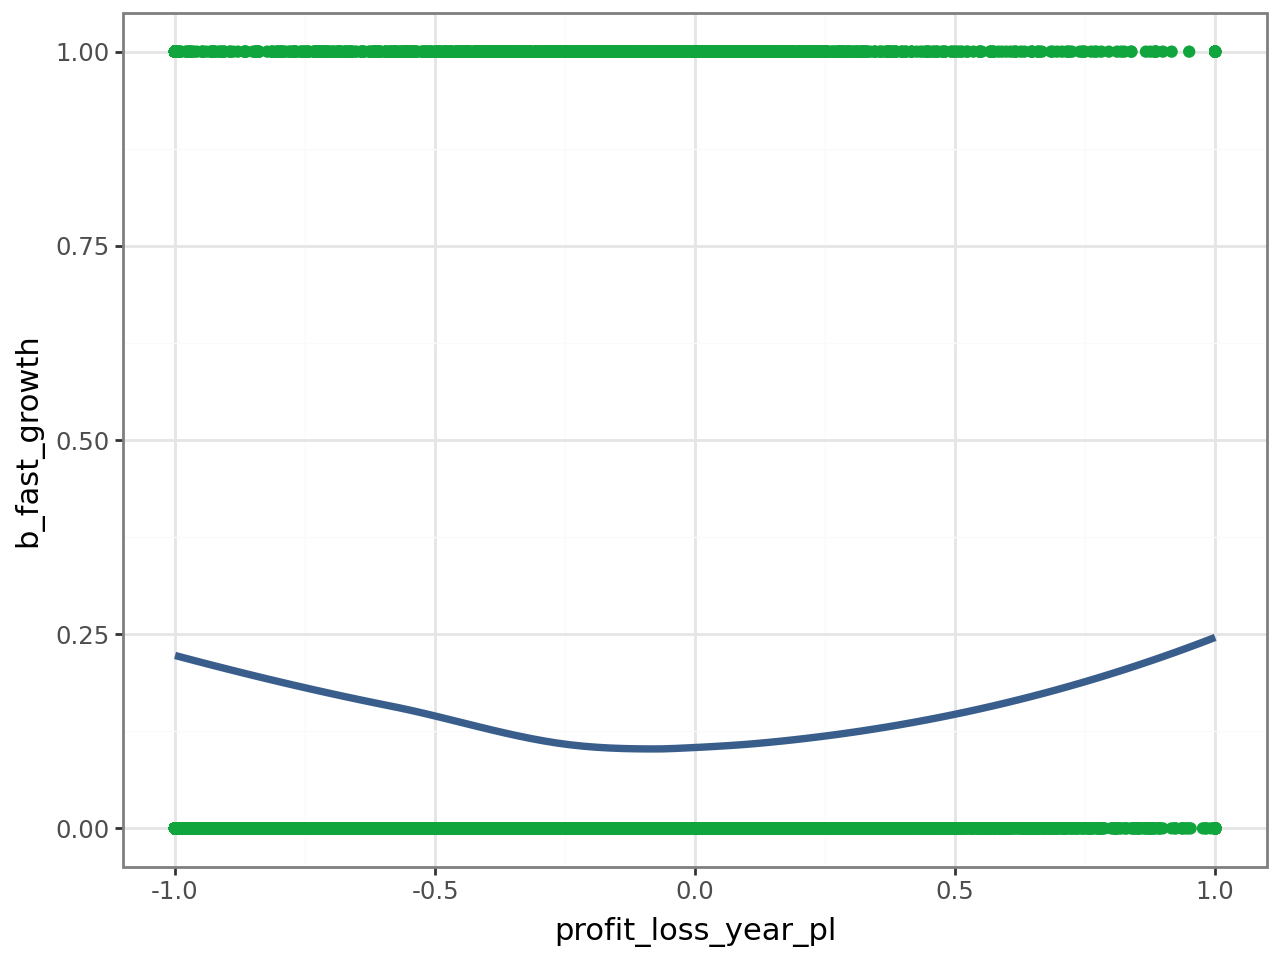

profit_loss_year_wins


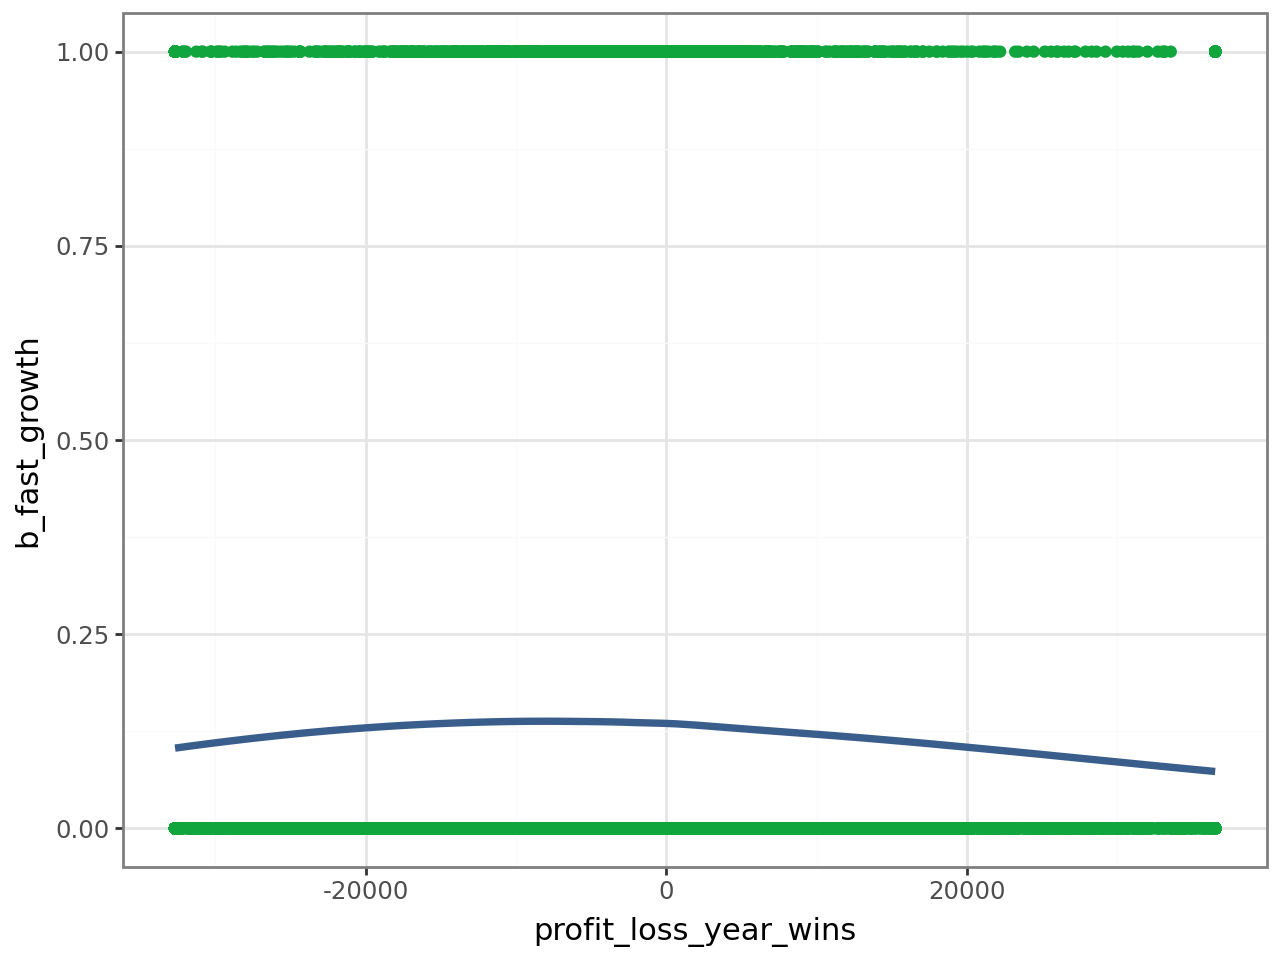

sales_mil_wins


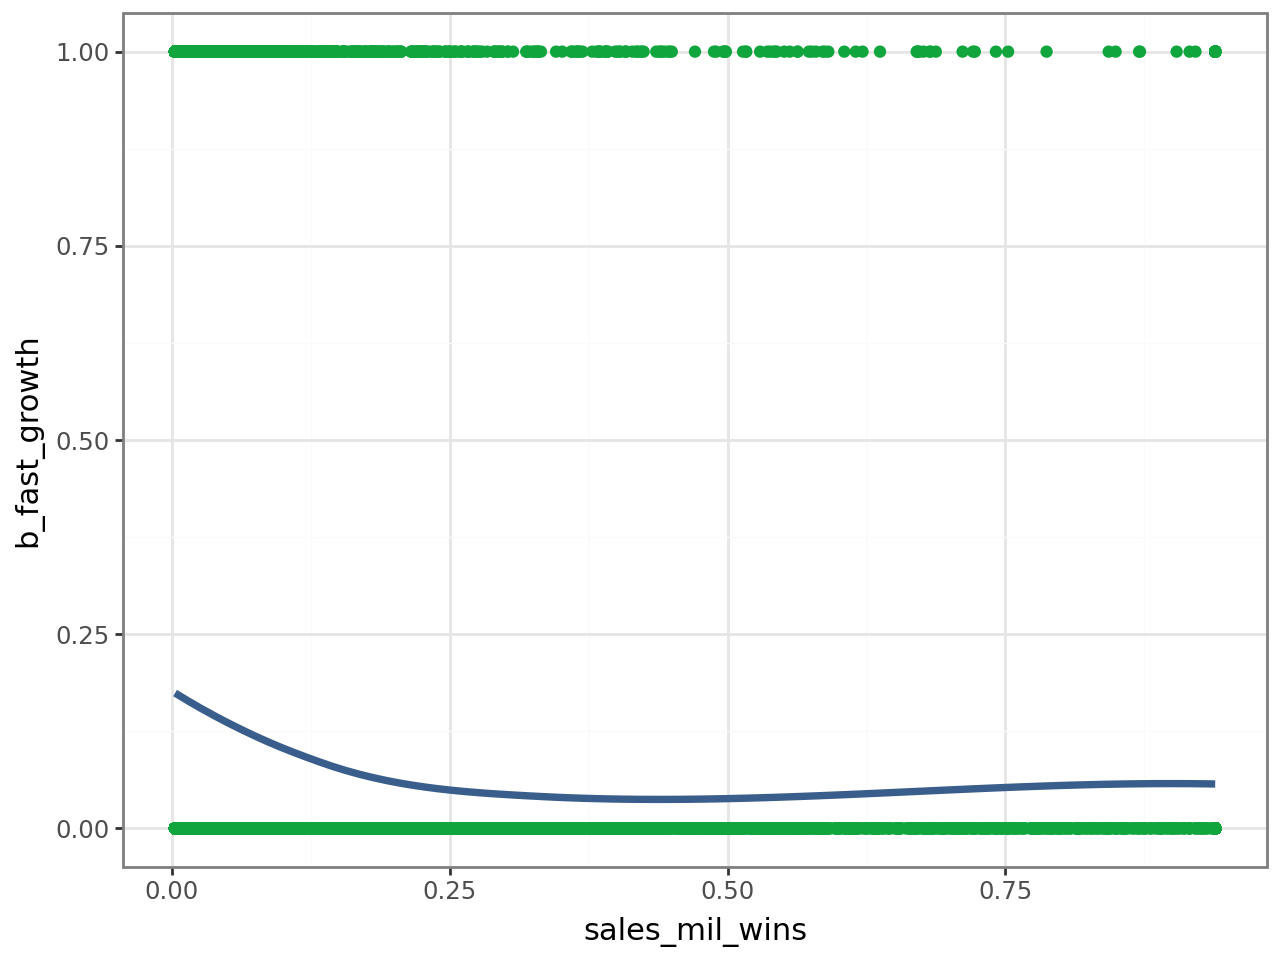

sales_wins


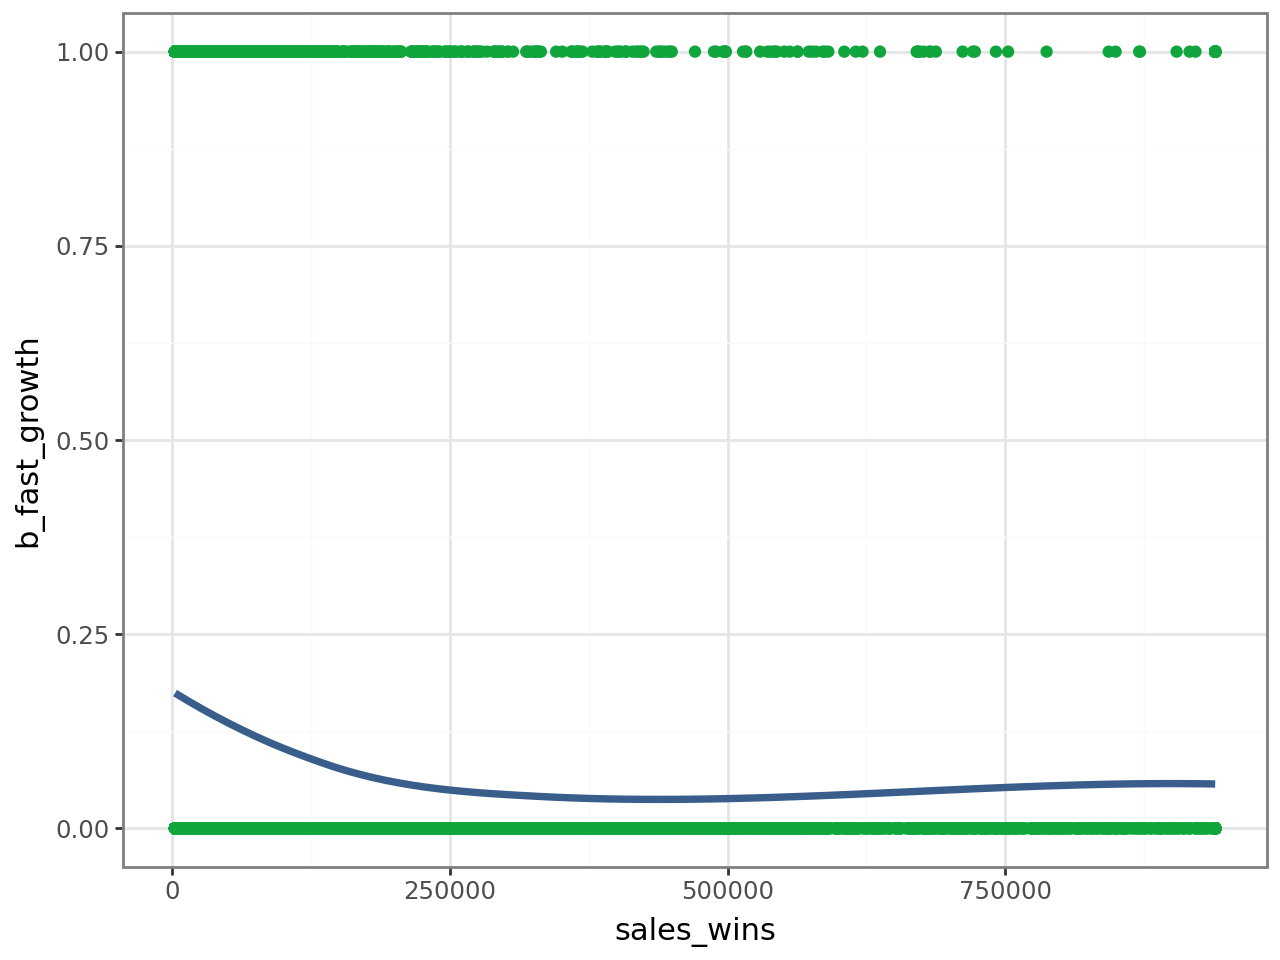

share_eq_bs


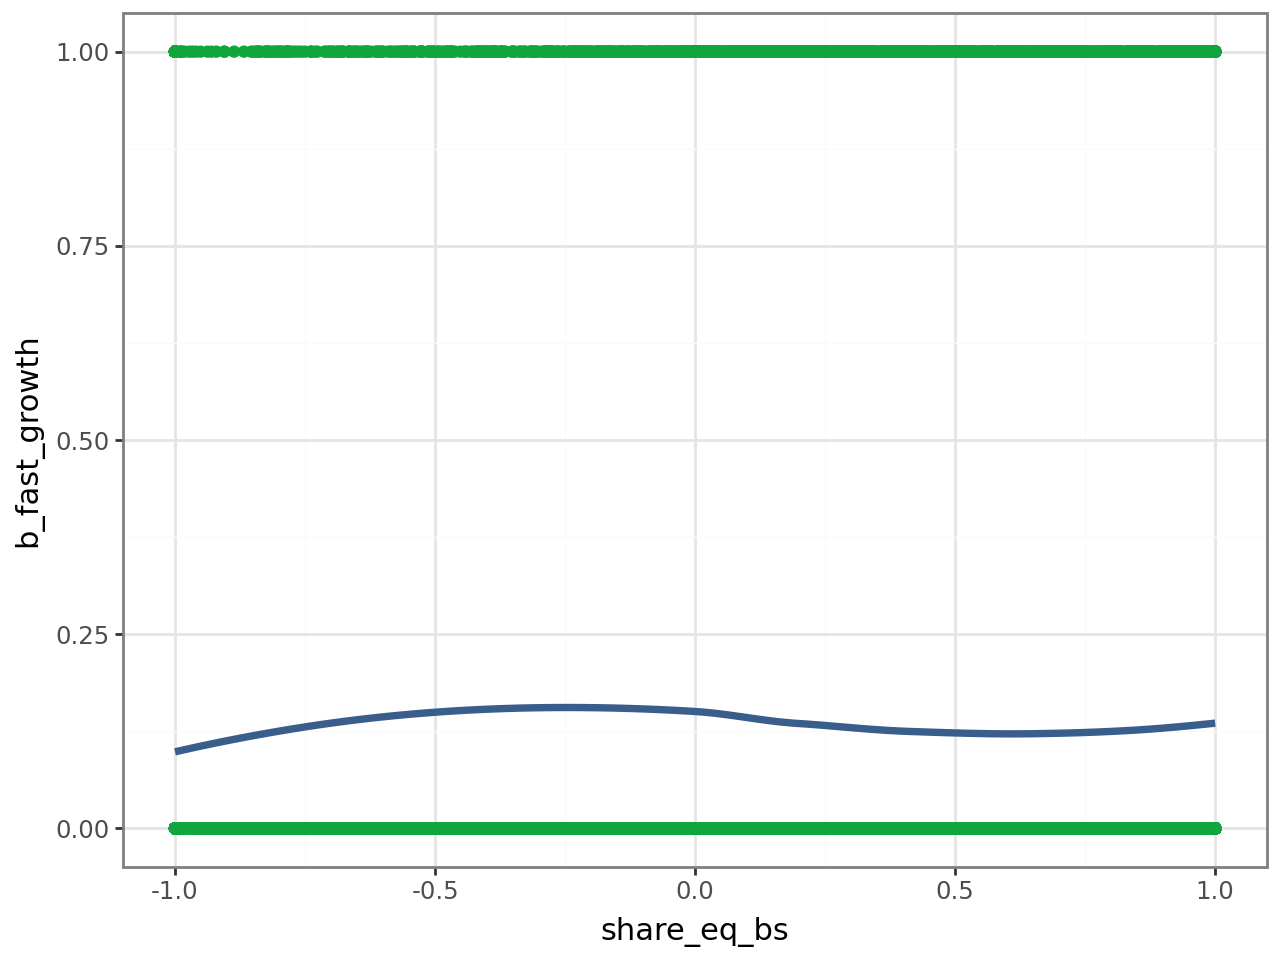

share_eq_wins


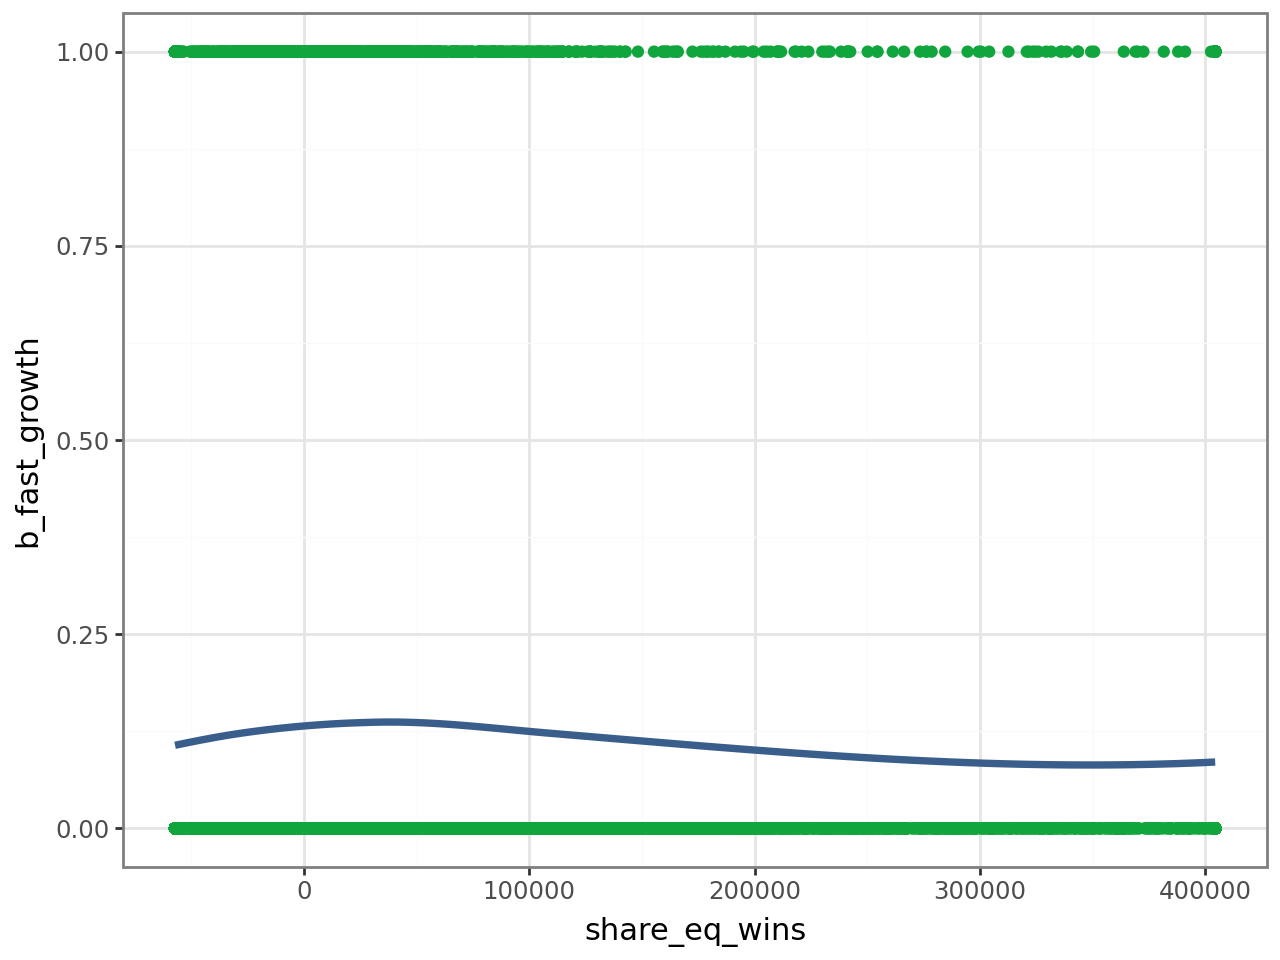

subscribed_cap_bs


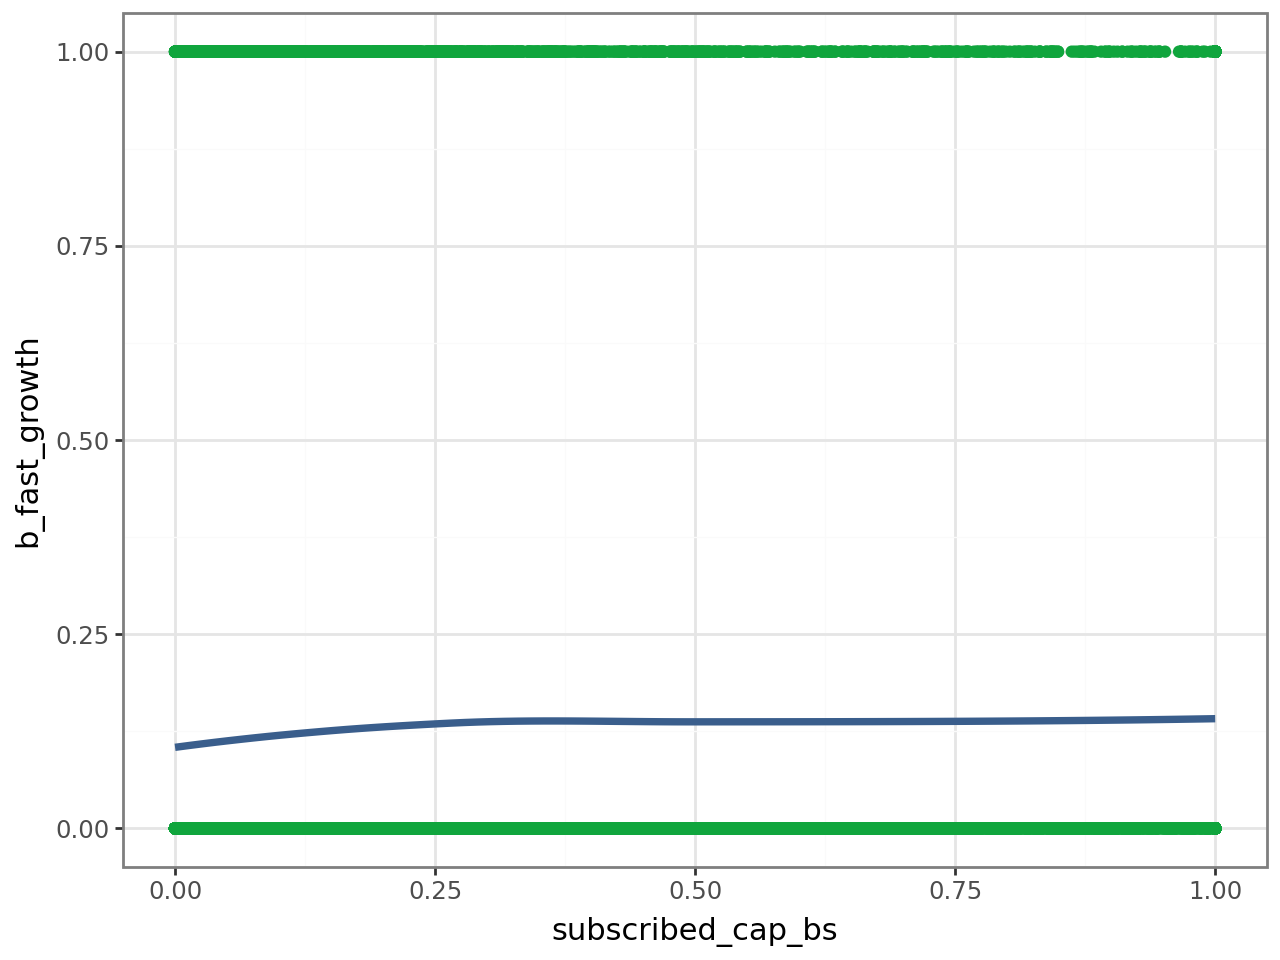

subscribed_cap_wins


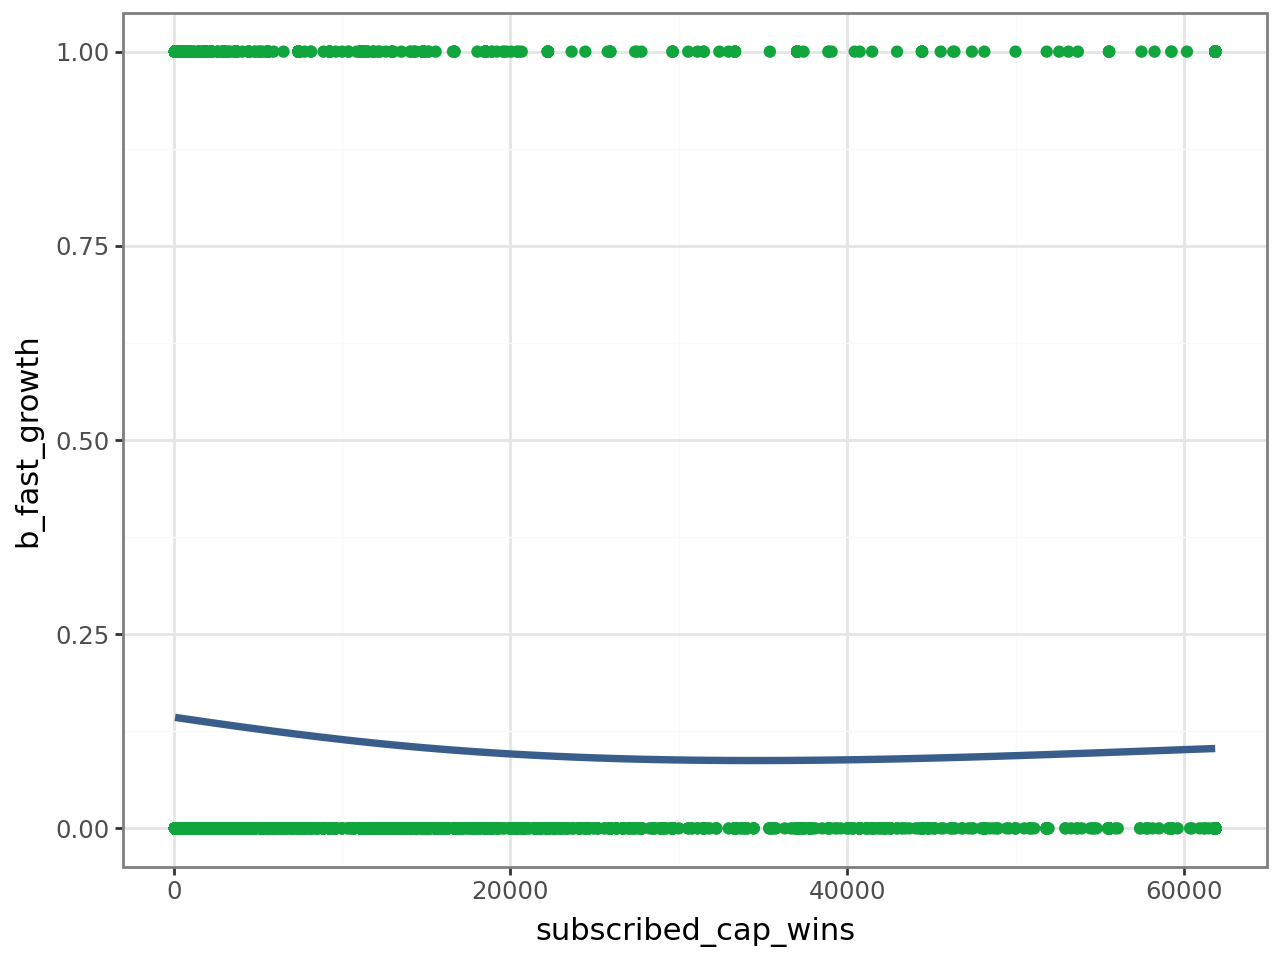

tang_assets_bs_wins


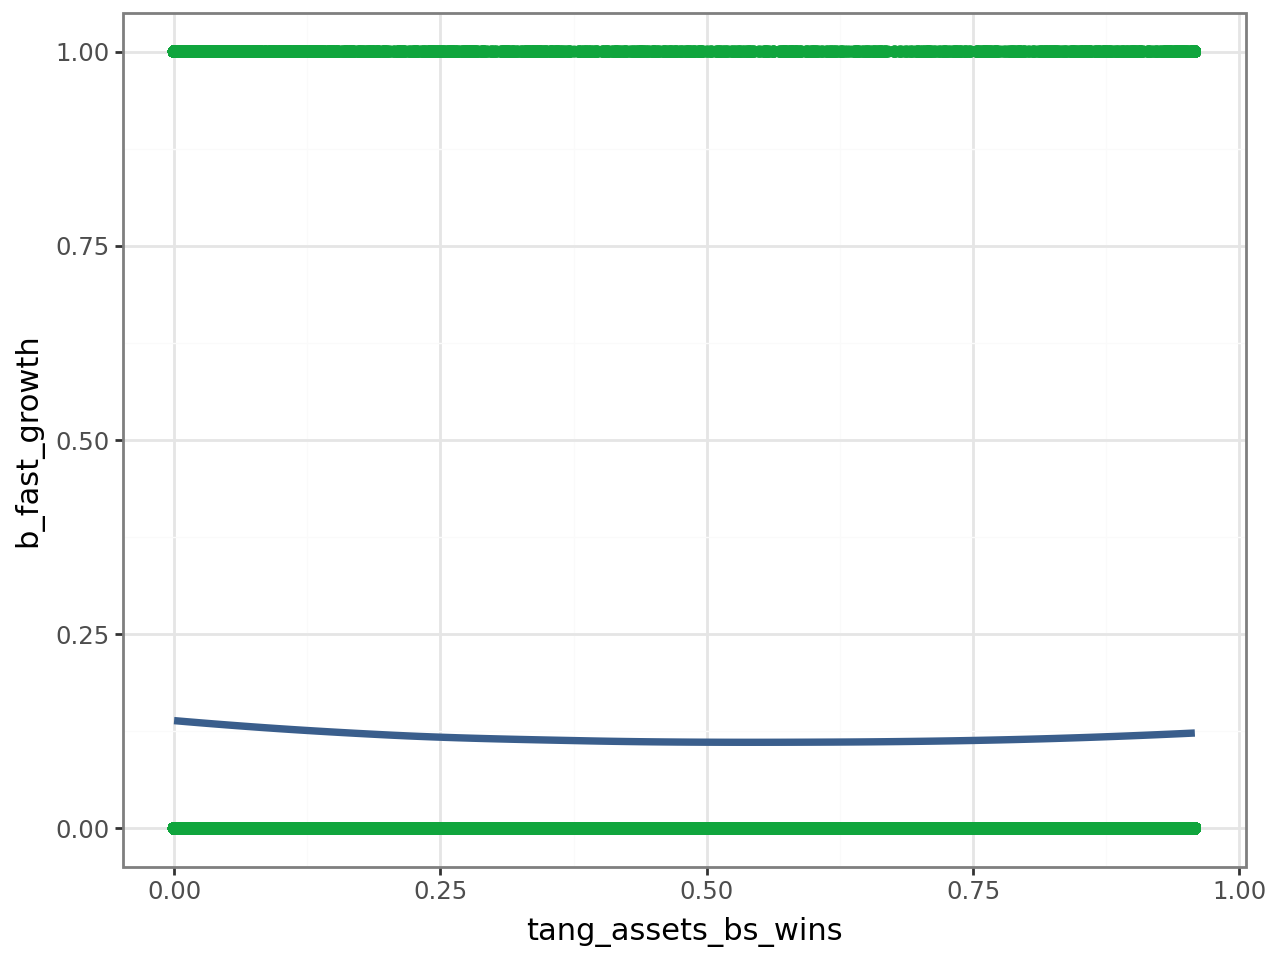

tang_assets_wins


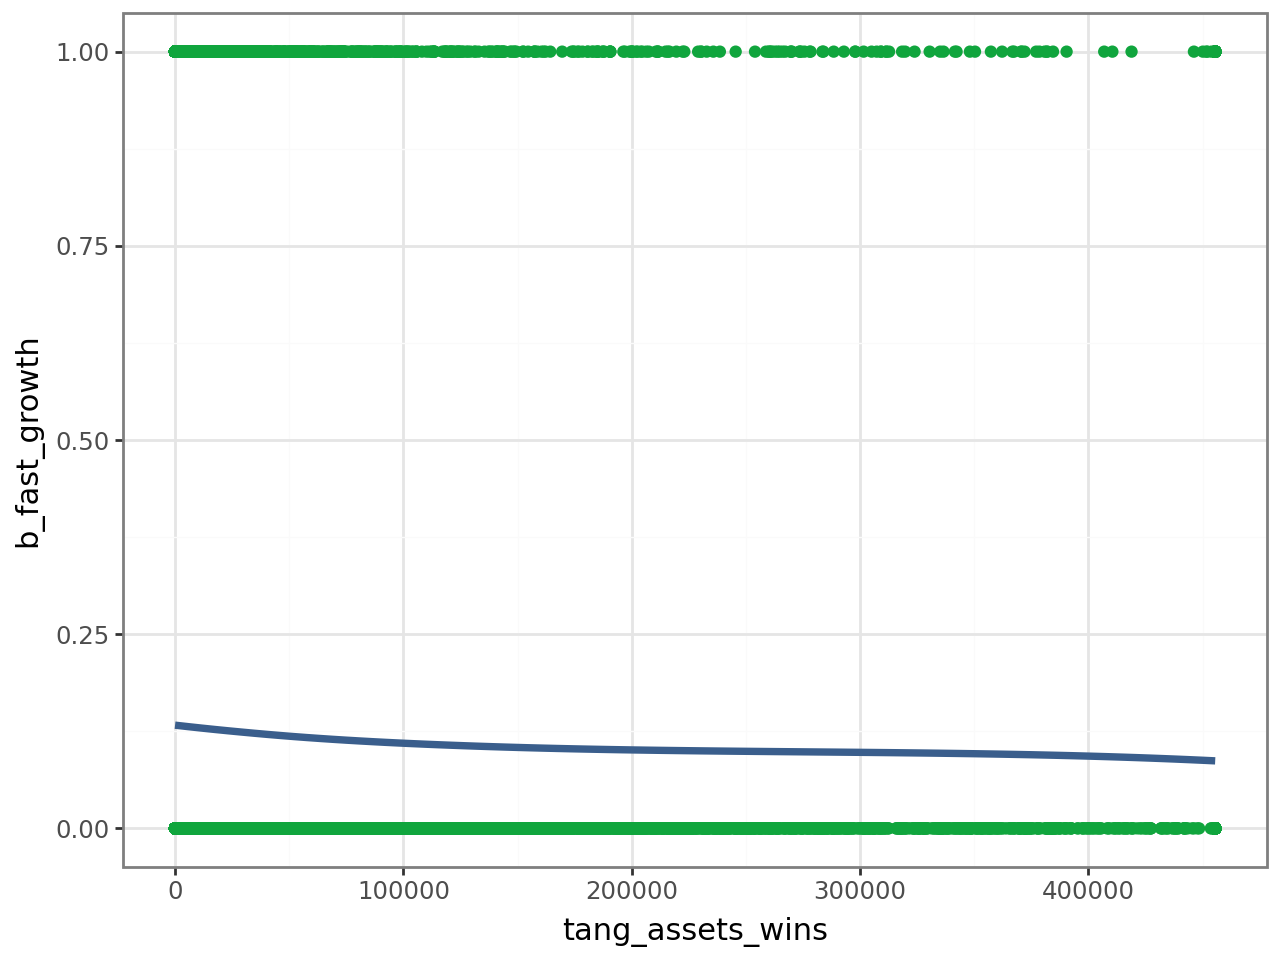

total_assets_bs_wins


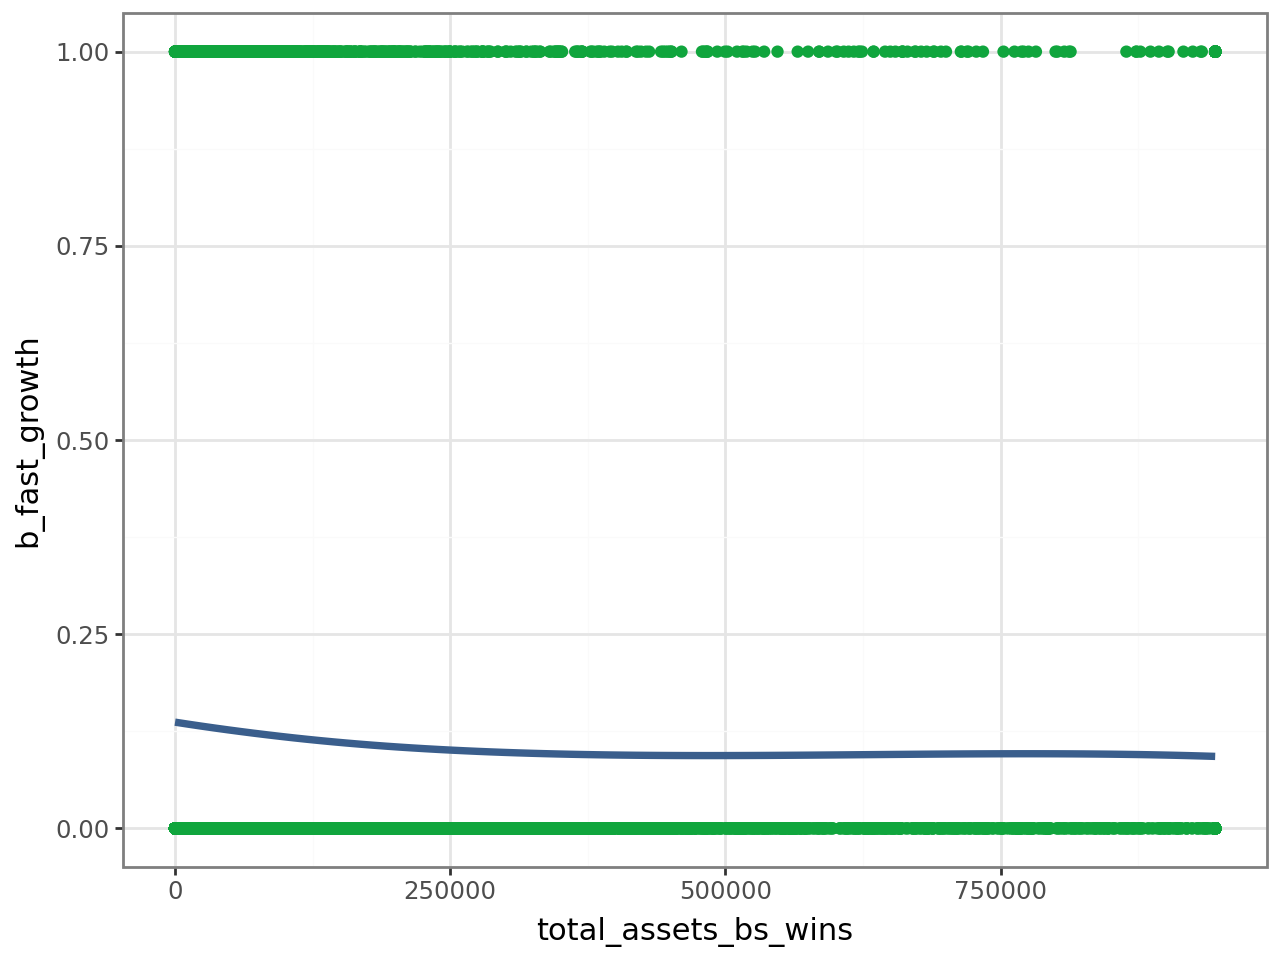

In [143]:
for c in toplot:
    print(c)
    p = (
        ggplot(data, aes(x = c, y = "b_fast_growth"))
        + geom_point(color=color[1])
        + geom_smooth(method = 'loess', color=color[0], se=False, size=1.5, span = 0.95)
        + theme_bw()
    )
    display(p)

As most of the variables have some non-linear patterns according to LOWESS estimates, I add squares and cubes.

In [145]:
for v in toplot:
    data[f'{v}_sq'] = np.power(data[v], 2)
    data[f'{v}_cu'] = np.power(data[v], 3)

Lastly, I save my cleaned workfile.

In [147]:
data.to_csv('HA2_workfile.csv', index=False)